### **THE PERFECT MOVIE RECIPE**

Hien Lê, Zafer Kocaoglu, Francesco Maizza, Anita Mezzetti, Nataliia Surianinova

Project structure:
- [DATA WRANGLING](#data_wrangling)

    1. [Features analysis](#column_analysis)
        - [Color](#color)
        - [Year](#Year)
        - [Aspect Ratio](#ar)
        - [Country](#country)
    2. [Drop Duplicates and Key Values](#drop_key)
    3. [Fill NaN values with other datasets](#fill_na)
        - [Wikipedia](#wikipedia)
        - [TMDb](#tmdb)
    4. [Filling or Removing Nan Values](#fill_remove)


- [FEATURE ENGINEERING](#feature_engineering)

    1. [Genres: One Hot Encoding](#genres)
    2. [Rating](#rating)
        - [Director](#director)
        - [Actors: actor 1, actor 2, actor 3](#actors)
        - [Rating Recent Movies](#rat_new)
    3. [Filling Missed Budget Values](#missed_budget)
    4. [Gross Budget Ratio](#ratio)
    

- [EDA (all movies)](#eda)

    1. [Univariate Analysis](#uni)

        - [Some high-level observations](#high_level)
        - [SP500 and Fed](#fed)
        - [Content rating (?)](#content_rating)
        - [(?) prominent director](#prominent_director)

    2. [Bivariate Analysis](#biv)

        - [Relationship between profitability and IMDB score](#prof_imdb)
        - [Average Gross Budget Ratio For Each Genre](#ratio_genre)

    3. [Multivariate Analysis](#multi)

        - [Influence of Social Media?](#social)

    3. [Keywords Analysis](#keys)

        - [Relation between keywords, Budget, Gross and profitability](#rel_keys)
        - [PCA](#pca)
    
    

- [EDA (USA)](#edaam)

- Classification
- Regression


In [1]:
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import collections

# sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer


from collections import OrderedDict, Counter
from matplotlib import pyplot
from random import randint

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
# import data
movie_data = pd.read_csv(r'data/movie_metadata.csv')

In [3]:
print("The features of the movie dataset are:")
print(movie_data.dtypes)

The features of the movie dataset are:
color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64

# Data Wrangling  <a name="data_wrangling"></a>


## 1) Features analysis: <a name="column_analysis"></a>

We check what columns are actually useful. In particular we analyse four of them.

### Color <a name="color"></a>

We check that the color column is binary: a film is *'black and white'* or is *'color'*. 

We drop the color column, because we want to help a modern film company and it is gonna make color films quite surely. Nowadays, the decision to produce a *'black and white'* movie is an usual choice, driven by artistic needs. 

In the next section (year) we will keep only movies produced after the 1980 (we will explain why). We can ignore the color column because mosto of recent movies are 'Color'.

Firstly we verify that *'black and white'* or is *'color'* are the only values of the column:

In [4]:
colors = movie_data.color.unique() # values in the column color
color_values = [x for x in colors if str(x) != 'nan'] # drop nan
#color_values[1] = color_values[1].strip() # delete spaces before 'black'

print(f"The color column has only {len(color_values)} different values: '{color_values[0]}' and '{color_values[1]}'.")

The color column has only 2 different values: 'Color' and ' Black and White'.


In [5]:
# dataframe years and colors:
year_color = movie_data[['color', 'title_year']] # we only need color and year
year_color = year_color[~year_color.color.isnull()] # deletete color NaN values 
year_color = year_color[~year_color.title_year.isnull()]  # deletete title NaN values 
year_color = year_color.sort_values('title_year') # sort by year

years = year_color.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years): 
    year = int(years[i]) # year
    year_movies = year_color.loc[year_color['title_year'] == years[i]].color.values # all colors of film of that year
    
    # number black and white and color movies for each year
    num_c = (year_movies == color_values[0]).sum()
    num_bw = (year_movies == color_values[1]).sum()
    
    # dataframe: for each row year, num colors, num blackwhite
    d = {'year':year , 'num_color':num_c , 'num_black_white':num_bw }
    
    if i==0 :
        year_number_colors = pd.DataFrame( data=d , index=[year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data=d , index=[year])
        year_number_colors = year_number_colors.append(d2, ignore_index=True)
        
print("For each year, we check how many films are colored and how many black and white:")
year_number_colors = year_number_colors.set_index('year')
year_number_colors.head()

For each year, we check how many films are colored and how many black and white:


num_color  num_black_white
year                            
1916          0                1
1920          0                1
1925          0                1
1927          0                1
1929          0                2

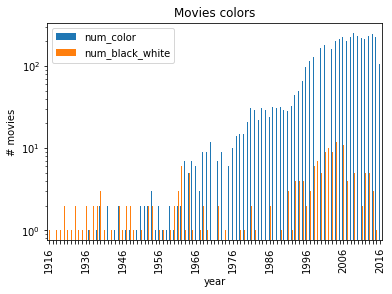

In [6]:
year_number_colors['year']=year_number_colors.index
f=year_number_colors.plot(x="year", y=["num_color", "num_black_white"], kind="bar")
plt.yscale('log', nonposy='clip')
plt.ylabel('# movies')
plt.title("Movies colors")
for ind, label in enumerate(f.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
#f.set_yscale("log")

We can see that most of movies in recent years are *'color'*, so this column is not a relevant feature. We can drop it

In [7]:
movie_data = movie_data.drop('color', axis=1) # drop color column

### Year <a name="year"></a>

Custumers' tastes change really fastly. We have already decided to drop black and white films, because they are not relevant for the analysis. In the same way, we can ignore films which were produced before 1980. As it can be seen in this histogram, this choice does not drop the majority of the movies, which were produced after 1980.

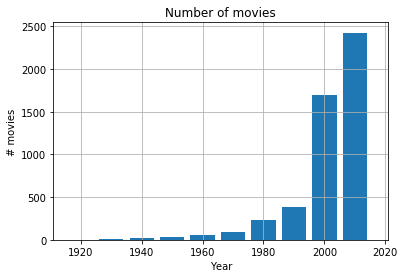

In [8]:
movie_data.title_year.hist( histtype='bar', width = 8)
plt.title("Number of movies")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

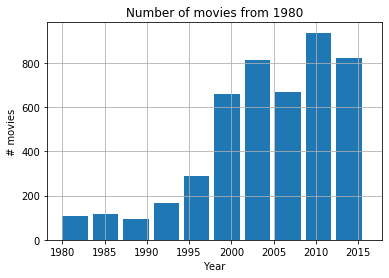

In [9]:
movie_data = movie_data[movie_data.title_year>=1980] # drop film before 1980
movie_data.title_year.hist(width = 3)
plt.title("Number of movies from 1980")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

### Aspect Ratio <a name="ar"></a>

We want to anlyse if the aspect ratio is an intresting feature. Nowadays, there are some rules which says the ratio that film-makers must use (deeper reserch in the report). For example wikipedia says (https://en.wikipedia.org/wiki/Aspect_ratio_(image)) :

The most common aspect ratios used today in the presentation of films in cinemas are 1.85:1 and 2.39:1. Two common videographic aspect ratios are 4:3 (1.3:1), the universal video format of the 20th century, and 16:9 (1.7:1), universal for high-definition television and European digital television. Other cinema and video aspect ratios exist, but are used infrequently.

We investigate for each year what aspect ratios were used. 

In [10]:
ar = movie_data.aspect_ratio.unique() 
ar = [x for x in ar if str(x) != 'nan'] # drop nan
ar = sorted(ar) # sort 

print("The aspect ratios which were used were:")
print(*ar, sep = "\n")

The aspect ratios which were used were:
1.18
1.33
1.37
1.44
1.5
1.66
1.75
1.77
1.78
1.85
1.89
2.0
2.2
2.24
2.35
2.39
2.4
2.55
2.76
16.0


In [11]:
# dataframe years and aspect ratio:
year_ar = movie_data[['title_year', 'aspect_ratio']] # we only need color and year
year_ar = year_ar[~year_ar.aspect_ratio.isnull()] # deletete color NaN values 
year_ar = year_ar[~year_ar.title_year.isnull()]  # deletete title NaN values 
year_ar = year_ar.sort_values('title_year') # sort by year

years = year_ar.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years):  
    year = int(years[i]) # year
    year_movies = year_ar.loc[year_ar['title_year'] == years[i]].aspect_ratio.values # all colors of film of that year
    
    # number of each of the aspect ratios
    num = [] 
    for j in range(len(ar)): # for each aspect ratio
        sum_ar = (year_movies == ar[j]).sum()
        num.append(sum_ar) 
    
    # dataframe: for each row year, num of each aspect ratio
    d = dict(zip(ar, num)) # dictionary to create the dataframe
    
    d['year'] = year
    
    if i==0 :
        year_number_ar = pd.DataFrame( data = d , index = [year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data = d , index = [year])
        year_number_ar = year_number_ar.append(d2, ignore_index=True)
        
print("For each year, we check the number of movies for each ratio:")
year_number_ar = year_number_ar.set_index('year')
year_number_ar.head()

For each year, we check the number of movies for each ratio:


1.18   1.33   1.37   1.44   1.50   1.66   1.75   1.77   1.78   1.85   \
year                                                                         
1980      0      0      1      0      0      0      0      0      0     11   
1981      0      0      2      0      0      0      0      0      1     15   
1982      0      0      0      0      0      0      0      0      0     12   
1983      0      0      0      0      0      0      0      0      0     12   
1984      0      0      0      0      0      0      0      0      0     21   

      1.89   2.00   2.20   2.24   2.35   2.39   2.40   2.55   2.76   16.00  
year                                                                        
1980      0      0      0      0     12      0      0      0      0      0  
1981      0      0      0      0     15      0      0      0      0      0  
1982      0      0      0      0     16      0      0      0      0      0  
1983      0      0      0      0      8      0      0      0      0      0  
1984      0      0      1      0      9      0      0      0      0      0

From this Data Frame we can see that 1.85 and 2.35 have way more movies than all the others ratios. We can plot these two and the sum of all the other and see that the other are irrelevant.

In [12]:
#we sum all the other columns: 

year_number_ar['year'] = year_number_ar.index
year_number_ar['sum'] =  year_number_ar[year_number_ar.columns[0]]
lista = [1,2,3,4,5,6,7,8,10,11,12,13,15,16,17,18,19]

for i in range(len(lista)):
    index = lista[i]
    year_number_ar['sum'] = year_number_ar['sum'] + year_number_ar[year_number_ar.columns[index]]
    

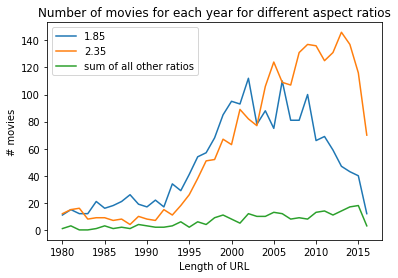

In [13]:
# plot:
# identification of the columns
ar_185 = year_number_ar.columns[9]
ar_235 = year_number_ar.columns[14]
ar_sum = year_number_ar.columns[21]


year_number_ar.plot(kind='line',x='year', y=[ar_185,ar_235, ar_sum])

plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.ylabel('# movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios")
plt.show()

This plot shows that in the last years most of the movies use only two aspect ratios. So, it is not a intresting feature: probably there is some obbligation and our film company should not use this characteristic to decide the next investment. 
    
In particular, we see a drop in the orange line after 2012. This does not mean that the customers prefer other aspect ratio. This is due to a general drop in film production. In fact, also other lines goes down. To show this we can use percentage:

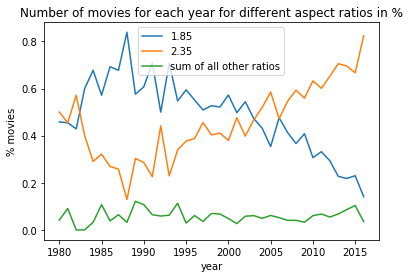

In [14]:
ar_185_perc = year_number_ar[year_number_ar.columns[9]].values
ar_235_perc = year_number_ar[year_number_ar.columns[14]].values
ar_sum_perc = year_number_ar[year_number_ar.columns[21]].values
at_tot = ar_185_perc + ar_235_perc + ar_sum_perc
years = year_number_ar.index.values


plt.plot(years,ar_185_perc/at_tot)
plt.plot(years,ar_235_perc/at_tot)
plt.plot(years,ar_sum_perc/at_tot)
plt.xlabel('year')
plt.ylabel('% movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios in %")
plt.show()

Using percentage we can notice that the 2.35 ratio remains the preveland one. The sum of all other ratios (different form 2.35 and 1.85) remains quite low. Due to the last years' rules for movie companies regarting the ratio (which must be optimal to see the movie at the cinema) we cand srop this column.

In [15]:
movie_data = movie_data.drop('aspect_ratio', axis=1) # drop aspect ratio column

### Country <a name="country"></a>

Firstly, we plot for each country, the number of movies produced there

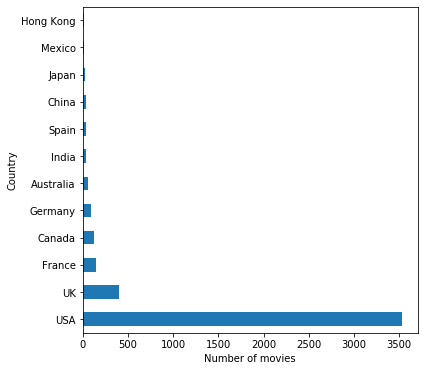

In [16]:
mlb = MultiLabelBinarizer()
country = movie_data.country.values
#encoded_country = pd.DataFrame(country, columns=mlb.classes_, index=movie_df.index)
count_country = Counter(country)
count_country = {k: v for k, v in sorted(count_country.items(), key=lambda item: item[1], reverse = True)}
count_country = dict(itertools.islice(count_country.items(), 12)) 
dd = pd.DataFrame(count_country.items())
dd = dd.set_index(0)

fig, ax = plt.subplots(figsize=(6,6))
dd.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Country')
plt.show()

We have taken our data from different sources and we do not know, for movies which are not American, in which currencies the budget and the gross are. Theoretically, reading the information of our databases, the prices should be all in dollars. However, some movies (as the Japan film 'The Host') are in Yen. 

Hence, considering that the large majority of movies are American and that we suppose to do our analysis for an American company, we can drop all movies which are not produced in USA. In this way we avoid potential and dangerous currency-related mistakes and we can focus on American people tastes.

### 2) Drop Duplicates and Key Values <a name="drop_key"></a>

From the *movie_imdb_link* we extract the IMDB_id.

In [17]:
# extraction of imdb_id 
movie_data['imdb_id'] = movie_data.movie_imdb_link.str.split('/').map(lambda row: row[4])

movie_data = movie_data.drop('movie_imdb_link', axis=1) # drop link column

We noticed that some movies are repeated. So, we cannot just set imdb_id as index: this is not an unique key right now. Before that, we have to delete duplicate rows. 

This is also the first step for the deletion of NaN values. In fact, a lot of NaN values derive from the fact that if a film is present twice, and not both lines have all the values.

In [18]:
print("Number of NaN values for each feature before dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature before dropping doplicate rows:


director_name                  0
num_critic_for_reviews        41
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        619
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                140
num_user_for_reviews          15
language                       5
country                        1
content_rating               255
budget                       375
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

From the DataFrame we delete duplicates movies. In order to do that, we sort our value for the number of NaN and we keep only the copy with the lower number of features with value NaN. 
This should not only delete duplicates, but also reduce the number of NaN for each feature.

In [19]:
movie_data = (
    movie_data.iloc[movie_data.isnull().sum(axis=1).mul(-1).argsort()] # Sort by number of NaN
        .drop_duplicates(subset='imdb_id', keep='last') # Remove duplicates taking last element
)

print("Number of NaN values for each feature after dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature after dropping doplicate rows:


director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

A lot of features have less missing values! This makes our DataFrame more consistent. Moreover, now we have an unique key: imdb_id. Now, we can set it as index.

 It is useful to match this database with the other ones, that we need to fill the NaN values. The reason why we do not use the title to match them is that the title is not an unique key: it can be inconsistent between different data sets (eg. Capitalization). 

We check that this 'imdb_id' is unique and we set it as index:

In [20]:
if movie_data.imdb_id.nunique() == len(movie_data['imdb_id'].values): 
    movie_data = movie_data.set_index('imdb_id') # add imdb_id as a new column

movie_data.head()

director_name  num_critic_for_reviews  duration  \
imdb_id                                                        
tt2638024  Amal Al-Agroobi                     NaN      62.0   
tt0304692      Harry Gantz                    12.0     105.0   
tt0488873   Andrew Berends                    12.0      90.0   
tt4462082        Jem Cohen                    12.0     111.0   
tt4607906        Valentine                     NaN       NaN   

           director_facebook_likes  actor_3_facebook_likes actor_2_name  \
imdb_id                                                                   
tt2638024                     58.0                     NaN          NaN   
tt0304692                      0.0                     NaN          NaN   
tt0488873                      0.0                     NaN          NaN   
tt4462082                      6.0                     NaN          NaN   
tt4607906                      0.0                     NaN    Valentine   

           actor_1_facebook_likes     gross              genres  \
imdb_id                                                           
tt2638024                     NaN       NaN  Documentary|Family   
tt0304692                     NaN  247740.0   Documentary|Drama   
tt0488873                     NaN       NaN     Documentary|War   
tt4462082                     NaN       NaN         Documentary   
tt4607906                    17.0       NaN             Romance   

               actor_1_name  ...  \
imdb_id                      ...   
tt2638024               NaN  ...   
tt0304692               NaN  ...   
tt0488873               NaN  ...   
tt4462082               NaN  ...   
tt4607906  Diane Sorrentino  ...   

                                               plot_keywords  \
imdb_id                                                        
tt2638024  autism|middle east|music therapy|united arab e...   
tt0304692           bisexual|explicit sex|sex|stranger|swing   
tt0488873                   american|blood|dream|patrol|tank   
tt4462082        city|city symphony|diary|essay|surveillance   
tt4607906                                                NaN   

           num_user_for_reviews  language               country  \
imdb_id                                                           
tt2638024                   NaN    Arabic  United Arab Emirates   
tt0304692                   8.0   English                   USA   
tt0488873                   7.0   English                   USA   
tt4462082                   1.0   English                   USA   
tt4607906                   NaN   English                   USA   

           content_rating    budget  title_year actor_2_facebook_likes  \
imdb_id                                                                  
tt2638024             NaN  125000.0      2013.0                    NaN   
tt0304692             NaN       NaN      2002.0                    NaN   
tt0488873             NaN  120000.0      2005.0                    NaN   
tt4462082             NaN   50000.0      2015.0                    NaN   
tt4607906           PG-13  125000.0      2015.0                    0.0   

          imdb_score movie_facebook_likes  
imdb_id                                    
tt2638024        8.2                   54  
tt0304692        4.7                   51  
tt0488873        6.6                   14  
tt4462082        6.0                    5  
tt4607906        5.1                    0  

[5 rows x 25 columns]

### 3) Fill NaN values with other datasets:  <a name="fill_na"></a>

We use these two datasets to fill NaN values
 - Wikipedia dataset
 - TMDb dataset

In [21]:
movie_data.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### Wikipedia  <a name="wikipedia"></a>

We use this dataset to fill NaN values in for these features:

- [Gross](#gross)
- [Budget](#budget)


This is the Wikipedia query that we used to download data:

```
SELECT ?movieLabel (MAX(?grosses) as ?gross) (MIN(?costs) as ?cost) (MIN(?publicationYears) as ?publicationYear) ?IMDBid
WHERE 
{
  ?movie (wdt:P31/wdt:P279*) wd:Q11424;
                             wdt:P345 ?IMDBid;
                             wdt:P2142 ?grosses;
                             wdt:P577 ?publicationDate.
  
  OPTIONAL {?movie wdt:P2130 ?costs.}
  
  BIND(YEAR(?publicationDate) AS ?publicationYears)
  
  FILTER(?publicationYears >= (1980))
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} GROUP BY ?movieLabel ?IMDBid
```

In [22]:
wiki_data = pd.read_csv('data/wiki_data.csv').drop('movieLabel', axis=1).set_index("IMDBid") # read data from the wiki_data csv
wiki_data = wiki_data.rename(columns={"gross":"gross_1"}) #rename gross column
wiki_data = wiki_data.sort_values(axis=0, by="IMDBid")
wiki_data.head()

gross_1        cost  publicationYear
IMDBid                                             
tt0074486    7000000.0    100000.0             1980
tt0076709    1950391.0         NaN             1981
tt0078788   83471511.0  31500000.0             2019
tt0079417  106000000.0         NaN             1980
tt0080339   83453539.0   3500000.0             1980

In [23]:
# merge the two dataset on the imdb_id
movie_df = movie_data.merge(wiki_data, how='left', left_index=True, right_index=True)

In [24]:
movie_df.head()

director_name  num_critic_for_reviews  duration  \
imdb_id                                                        
tt2638024  Amal Al-Agroobi                     NaN      62.0   
tt0304692      Harry Gantz                    12.0     105.0   
tt0488873   Andrew Berends                    12.0      90.0   
tt4462082        Jem Cohen                    12.0     111.0   
tt4607906        Valentine                     NaN       NaN   

           director_facebook_likes  actor_3_facebook_likes actor_2_name  \
imdb_id                                                                   
tt2638024                     58.0                     NaN          NaN   
tt0304692                      0.0                     NaN          NaN   
tt0488873                      0.0                     NaN          NaN   
tt4462082                      6.0                     NaN          NaN   
tt4607906                      0.0                     NaN    Valentine   

           actor_1_facebook_likes     gross              genres  \
imdb_id                                                           
tt2638024                     NaN       NaN  Documentary|Family   
tt0304692                     NaN  247740.0   Documentary|Drama   
tt0488873                     NaN       NaN     Documentary|War   
tt4462082                     NaN       NaN         Documentary   
tt4607906                    17.0       NaN             Romance   

               actor_1_name  ...               country  content_rating  \
imdb_id                      ...                                         
tt2638024               NaN  ...  United Arab Emirates             NaN   
tt0304692               NaN  ...                   USA             NaN   
tt0488873               NaN  ...                   USA             NaN   
tt4462082               NaN  ...                   USA             NaN   
tt4607906  Diane Sorrentino  ...                   USA           PG-13   

             budget title_year  actor_2_facebook_likes imdb_score  \
imdb_id                                                             
tt2638024  125000.0     2013.0                     NaN        8.2   
tt0304692       NaN     2002.0                     NaN        4.7   
tt0488873  120000.0     2005.0                     NaN        6.6   
tt4462082   50000.0     2015.0                     NaN        6.0   
tt4607906  125000.0     2015.0                     0.0        5.1   

           movie_facebook_likes gross_1 cost publicationYear  
imdb_id                                                       
tt2638024                    54     NaN  NaN             NaN  
tt0304692                    51     NaN  NaN             NaN  
tt0488873                    14     NaN  NaN             NaN  
tt4462082                     5     NaN  NaN             NaN  
tt4607906                     0     NaN  NaN             NaN  

[5 rows x 28 columns]

In [25]:
# we added 3 columns:
movie_data.shape, movie_df.shape

((4560, 25), (4560, 28))

Now we have some repeated columns: gross and costs.

We have to keep only one of them. Instead of deleting one without an analysis. we match them in order to delete as many NaN values as possible

**Gross:** <a name="gross"></a>

In [26]:
# gross :   gross from movie dataset
# gorss_1 : gross from wiki dataset

gross_movie_na = movie_df.gross.isna()

for i in range(len(gross_movie_na)): # for each film
    if gross_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.gross[i] = movie_df.gross_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('gross_1', axis=1) # drop link gross wiki column

**Budget:** <a name="budget"></a>

In [27]:
# budget :   cost from movie dataset
# cost :     cost from wiki dataset

cost_movie_na = movie_df.budget.isna()

for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.cost[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['cost','publicationYear'], axis=1) # drop link cost wiki column

Now we can see that the number of movies with empty values in gross and budget has decreased :)

In [28]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       359
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### TMDb  <a name="tmdb"></a>

We repeat the same steps for this dataset, which is used to fill NaN values in
- [Budget](#budget_1)
- [Keywords](#keywords)

In [29]:
tmdb_data = pd.read_csv('data/tmdb_movies_data.csv').set_index("imdb_id") # read data from the wiki_data csv
tmdb_data = tmdb_data.rename(columns={"budget":"budget_1"}) #rename gross column
tmdb_data = tmdb_data[['budget_1','keywords']]

tmdb_data.head()

budget_1                                           keywords
imdb_id                                                                
tt0369610  150000000  monster|dna|tyrannosaurus rex|velociraptor|island
tt1392190  150000000   future|chase|post-apocalyptic|dystopia|australia
tt2908446  110000000  based on novel|revolution|dystopia|sequel|dyst...
tt2488496  200000000              android|spaceship|jedi|space opera|3d
tt2820852  190000000                car race|speed|revenge|suspense|car

In [30]:
movie_df = movie_df.merge(tmdb_data, how='left', left_index=True, right_index=True)
movie_df.head()

director_name  num_critic_for_reviews  duration  \
imdb_id                                                       
tt0035423   James Mangold                   125.0     123.0   
tt0080339    Jim Abrahams                   134.0      88.0   
tt0080453  Randal Kleiser                    36.0     104.0   
tt0080455     John Landis                   125.0     148.0   
tt0080487    Harold Ramis                    71.0      98.0   

           director_facebook_likes  actor_3_facebook_likes  \
imdb_id                                                      
tt0035423                    446.0                   821.0   
tt0080339                    104.0                   318.0   
tt0080453                    116.0                    83.0   
tt0080455                    644.0                   326.0   
tt0080487                  11000.0                   484.0   

                 actor_2_name  actor_1_facebook_likes       gross  \
imdb_id                                                             
tt0035423      Natasha Lyonne                 20000.0  47095453.0   
tt0080339       Lloyd Bridges                   628.0  83400000.0   
tt0080453  Christopher Atkins                  1000.0  58853106.0   
tt0080455     Aretha Franklin                  1000.0  54200000.0   
tt0080487  Rodney Dangerfield                 13000.0  39800000.0   

                              genres    actor_1_name  ... language  country  \
imdb_id                                               ...                     
tt0035423     Comedy|Fantasy|Romance    Hugh Jackman  ...  English      USA   
tt0080339                     Comedy    Peter Graves  ...  English      USA   
tt0080453    Adventure|Drama|Romance  Brooke Shields  ...  English      USA   
tt0080455  Action|Comedy|Crime|Music    John Belushi  ...  English      USA   
tt0080487               Comedy|Sport     Bill Murray  ...  English      USA   

           content_rating      budget  title_year actor_2_facebook_likes  \
imdb_id                                                                    
tt0035423           PG-13  48000000.0      2001.0                 1000.0   
tt0080339              PG   3500000.0      1980.0                  575.0   
tt0080453               R   4500000.0      1980.0                  511.0   
tt0080455               R  27000000.0      1980.0                  809.0   
tt0080487               R   6000000.0      1980.0                  573.0   

           imdb_score movie_facebook_likes    budget_1  \
imdb_id                                                  
tt0035423         6.4                    0         0.0   
tt0080339         7.8                16000   3500000.0   
tt0080453         5.7                    0   4500000.0   
tt0080455         7.9                14000  27000000.0   
tt0080487         7.4                    0   6000000.0   

                                                    keywords  
imdb_id                                                       
tt0035423  lover (female)|love of one's life|time travel|...  
tt0080339          chicago|alcohol|cataclysm|guitar|medicine  
tt0080453  sexual identity|shipwreck|lovers|stranded|maro...  
tt0080455           dancing|prison|chicago|country music|nun  
tt0080487            golf|underwear|sport|golf course|gopher  

[5 rows x 27 columns]

**Budget:** <a name="budget_1"></a>

In [31]:
# budget :   cost from movie dataset
# budget_1 :     cost from TDM  dataset

cost_movie_na = movie_df.budget.isna()

for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.budget_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('budget_1', axis=1) # drop link cost wiki column

**Keywords:**  <a name="keywords"></a>

In [32]:
# plot_keywords :    from movie dataset
# keywords :      from TDM  dataset

keywords_movie_na = movie_df.plot_keywords.isna()

for i in range(len(keywords_movie_na)): # for each film
    if keywords_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.plot_keywords[i] = movie_df.keywords[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['keywords'], axis=1) # drop link cost wiki column

In [33]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                129
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       171
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

## 4) Filling or Removing NaN Values  <a name="fill_remove"></a>

In [34]:
# for now we fill gross and budget NaN in this way, then we will fill them in a smarter way
movie_df.gross = movie_df.gross.fillna(movie_df.gross.median())
movie_df.budget = movie_df.budget.fillna(0)

In [35]:
NotFamous = {'actor_2_name': 'No Second Actor', 'actor_1_name': 'No Actor', 'actor_3_name': 'No Third Actor'}
movie_df = movie_df.fillna(value=NotFamous)

NotFBlikes = {'actor_3_facebook_likes': 0, 'actor_2_facebook_likes': 0, 'actor_1_facebook_likes': 0}
movie_df = movie_df.fillna(value=NotFBlikes)

NotRated = {'content_rating': 'Not Rated'}
movie_df = movie_df.fillna(value=NotRated)

In [36]:
# we manually searched for them 
movie_df.loc['tt3949660', 'facenumber_in_poster']=4
movie_df.loc['tt0903624', 'facenumber_in_poster']=1
movie_df.loc['tt3567288', 'facenumber_in_poster']=0
movie_df.loc['tt0989757', 'facenumber_in_poster']=2
movie_df.loc['tt1929263', 'facenumber_in_poster']=0
movie_df.loc['tt3014666', 'facenumber_in_poster']=6

In [37]:
movie_df=movie_df.dropna()
movie_df=movie_df.replace({'content_rating': {'Unrated': 'Not Rated'}})
movie_df.head()

director_name  num_critic_for_reviews  duration  \
imdb_id                                                       
tt0035423   James Mangold                   125.0     123.0   
tt0080339    Jim Abrahams                   134.0      88.0   
tt0080453  Randal Kleiser                    36.0     104.0   
tt0080455     John Landis                   125.0     148.0   
tt0080487    Harold Ramis                    71.0      98.0   

           director_facebook_likes  actor_3_facebook_likes  \
imdb_id                                                      
tt0035423                    446.0                   821.0   
tt0080339                    104.0                   318.0   
tt0080453                    116.0                    83.0   
tt0080455                    644.0                   326.0   
tt0080487                  11000.0                   484.0   

                 actor_2_name  actor_1_facebook_likes       gross  \
imdb_id                                                             
tt0035423      Natasha Lyonne                 20000.0  47095453.0   
tt0080339       Lloyd Bridges                   628.0  83400000.0   
tt0080453  Christopher Atkins                  1000.0  58853106.0   
tt0080455     Aretha Franklin                  1000.0  54200000.0   
tt0080487  Rodney Dangerfield                 13000.0  39800000.0   

                              genres    actor_1_name  ...  \
imdb_id                                               ...   
tt0035423     Comedy|Fantasy|Romance    Hugh Jackman  ...   
tt0080339                     Comedy    Peter Graves  ...   
tt0080453    Adventure|Drama|Romance  Brooke Shields  ...   
tt0080455  Action|Comedy|Crime|Music    John Belushi  ...   
tt0080487               Comedy|Sport     Bill Murray  ...   

                                               plot_keywords  \
imdb_id                                                        
tt0035423  bridge|brooklyn bridge|falling down an elevato...   
tt0080339  air traffic controller|airplane|airport|pilot|...   
tt0080453  coming of age|island|poison|teenage boy|teenag...   
tt0080455                 band|catholic|money|parolee|prison   
tt0080487       caddy|country club|golf course|gopher|nudity   

           num_user_for_reviews  language country  content_rating      budget  \
imdb_id                                                                         
tt0035423                 316.0   English     USA           PG-13  48000000.0   
tt0080339                 427.0   English     USA              PG   3500000.0   
tt0080453                 140.0   English     USA               R   4500000.0   
tt0080455                 319.0   English     USA               R  27000000.0   
tt0080487                 250.0   English     USA               R   6000000.0   

           title_year actor_2_facebook_likes imdb_score movie_facebook_likes  
imdb_id                                                                       
tt0035423      2001.0                 1000.0        6.4                    0  
tt0080339      1980.0                  575.0        7.8                16000  
tt0080453      1980.0                  511.0        5.7                    0  
tt0080455      1980.0                  809.0        7.9                14000  
tt0080487      1980.0                  573.0        7.4                    0  

[5 rows x 25 columns]

In [38]:
movie_df.isna().sum()

director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

# Feature Engineering and pre-data processing   <a name="feature_engineering"></a>

## 1) Genres: One Hot Encoding  <a name="genres"></a>

In [39]:
mlb = MultiLabelBinarizer()
genres = movie_df.genres.str.split("|")
encoded_genres = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_, index=movie_df.index)
encoded_genres

Action  Adventure  Animation  Biography  Comedy  Crime  \
imdb_id                                                             
tt0035423       0          0          0          0       1      0   
tt0080339       0          0          0          0       1      0   
tt0080453       0          1          0          0       0      0   
tt0080455       1          0          0          0       1      1   
tt0080487       0          0          0          0       1      0   
...           ...        ...        ...        ...     ...    ...   
tt4733536       1          0          0          0       1      0   
tt4786282       0          0          0          0       0      0   
tt4824308       0          0          0          0       0      0   
tt5078326       0          0          0          0       1      0   
tt5215952       0          0          0          0       0      0   

           Documentary  Drama  Family  Fantasy  ...  Musical  Mystery  News  \
imdb_id                                         ...                           
tt0035423            0      0       0        1  ...        0        0     0   
tt0080339            0      0       0        0  ...        0        0     0   
tt0080453            0      1       0        0  ...        0        0     0   
tt0080455            0      0       0        0  ...        0        0     0   
tt0080487            0      0       0        0  ...        0        0     0   
...                ...    ...     ...      ...  ...      ...      ...   ...   
tt4733536            0      1       0        0  ...        0        0     0   
tt4786282            0      0       0        0  ...        0        0     0   
tt4824308            0      1       0        0  ...        0        0     0   
tt5078326            0      1       0        0  ...        0        0     0   
tt5215952            0      0       0        1  ...        0        1     0   

           Romance  Sci-Fi  Short  Sport  Thriller  War  Western  
imdb_id                                                           
tt0035423        1       0      0      0         0    0        0  
tt0080339        0       0      0      0         0    0        0  
tt0080453        1       0      0      0         0    0        0  
tt0080455        0       0      0      0         0    0        0  
tt0080487        0       0      0      1         0    0        0  
...            ...     ...    ...    ...       ...  ...      ...  
tt4733536        0       1      0      0         0    0        0  
tt4786282        0       0      0      0         0    0        0  
tt4824308        0       0      0      0         0    0        0  
tt5078326        0       0      0      0         0    0        0  
tt5215952        0       0      0      0         1    0        0  

[4397 rows x 23 columns]

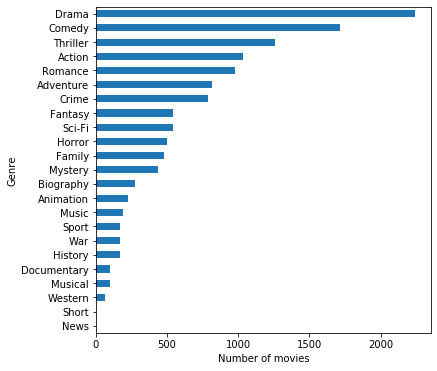

In [40]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

We can group togheter similar genres, in order to decrease the number of columns

In [41]:
# Mystery|Thriller|Horror
sum_gen = encoded_genres[['Mystery','Thriller','Horror']].sum(axis=1)
encoded_genres['Mystery_Thriller_Horror'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Mystery','Thriller','Horror'], axis=1) #drop other

#Sci-Fi|Fantasy
sum_gen = encoded_genres[['Sci-Fi','Fantasy']].sum(axis=1)
encoded_genres['Sci-Fi_Fantasy'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Sci-Fi','Fantasy'], axis=1) #drop other

#Family|Animation
sum_gen = encoded_genres[['Family','Animation']].sum(axis=1)
encoded_genres['Family_Animation'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Family','Animation'], axis=1) #drop other

#Action|Adventure
sum_gen = encoded_genres[['Action','Adventure']].sum(axis=1)
encoded_genres['Action_Adventure'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Action','Adventure'], axis=1) #drop other

#History|War
sum_gen = encoded_genres[['History','War']].sum(axis=1)
encoded_genres['History_War'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['History','War'], axis=1) #drop other


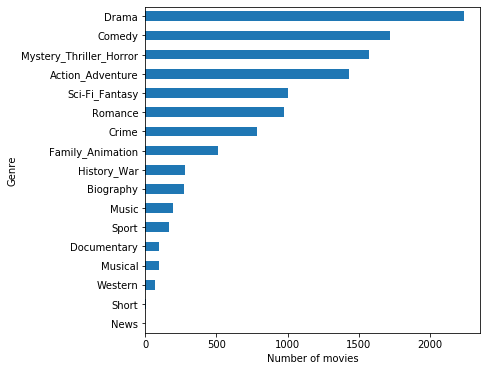

In [42]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

At this point we can put togheter genres which are not common:

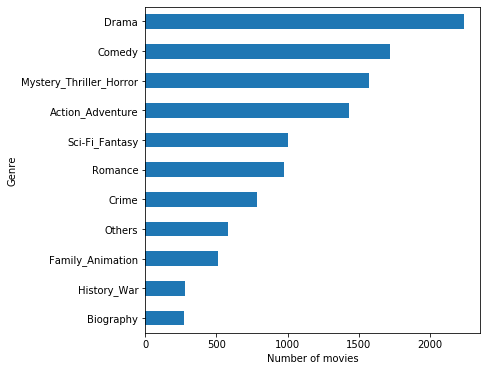

In [43]:
#Other
other = ['Music','Sport','Documentary','Musical','Western','Short','News']

sum_gen = encoded_genres[other].sum(axis=1)
encoded_genres['Others'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(other, axis=1) #drop other

# Add genres columns to movie_df
movie_df = movie_df.merge(encoded_genres,how='left', left_index=True, right_index=True)

count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()


## 2) Rating <a name="rating"></a>

For each director and actor we assign a rank, which considers different features which characterise him/her. It will be useful to identify the most important who contruìibute to the movie.


### Director <a name="genres"></a>

In [44]:
group_director = movie_df.groupby('director_name') # group the database for the director
directors = list(movie_df.director_name.values) #director list
directors_unique =list(OrderedDict.fromkeys(directors)) # no duplicates

#number of movies for each director
#counter = collections.Counter(directors)
results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')
directors.head()

num_movies
director                 
James Mangold           8
Jim Abrahams            1
Randal Kleiser          2
John Landis             3
Harold Ramis            8

In the regression, we cannot use variables which are consequnces, as movie_facebook_likes. However, we can use them to understand how much a director is famous. If a film has a lot of likes, its director will probably earn a good reputation.

Same reasoning for imdb_score

In [45]:
# mean movie_facebook_likes for the movies did by that director
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)

directors.head(10)

num_movies  imdb_score
director                             
James Mangold           8    7.075000
Jim Abrahams            1    7.800000
Randal Kleiser          2    6.200000
John Landis             3    6.966667
Harold Ramis            8    6.550000
Nancy Walker            1    4.500000
Michael Apted           6    6.516667
Brian De Palma         12    6.683333
David Lynch             4    7.700000
Irvin Kershner          2    7.500000

Director:


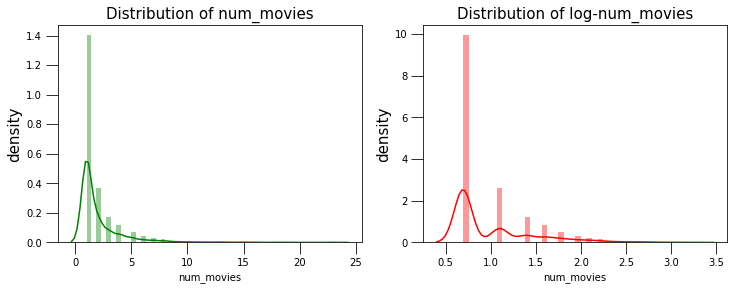

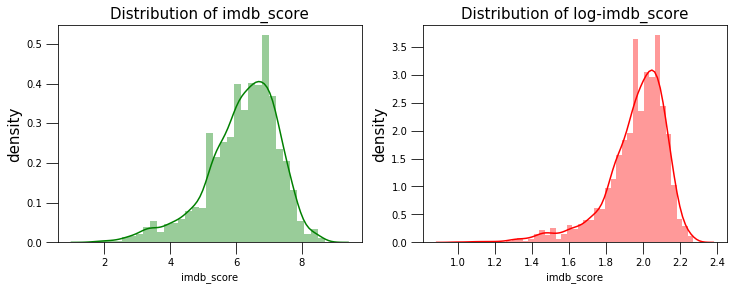

In [46]:
print("Director:")
for col in ["num_movies", "imdb_score"]:
    _, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
    sns.distplot(directors[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(directors[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

Using these three features, we can create a ranking for the directors. We consider 10 levels. If a director is in level 10, he is really important: he has done a lot of movies with high ranking. 

In order to do that, we 
- trasform this variables in values between 0 and 1
- do the mean of each column (same weight for each feature)
- create 10 groups

In [47]:
#we divide wach value for the max of that column in order to have values between 0 and 1
directors.num_movies = directors.num_movies/directors.num_movies.max()

directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/2 + directors.imdb_score*1/2
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]


directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

directors.head(10)

num_movies  imdb_score     mean_  director_rank
director                                                         
Steven Spielberg           1    0.864068  0.932034             10
Clint Eastwood      0.826087    0.828191  0.827139              8
Woody Allen         0.782609    0.797573  0.790091              8
Martin Scorsese     0.695652    0.880747    0.7882              8
Spike Lee           0.695652    0.755029   0.72534              7
Ridley Scott        0.652174    0.809195  0.730685              7
Renny Harlin        0.652174    0.660536  0.656355              7
Steven Soderbergh   0.652174    0.767816  0.709995              7
Oliver Stone        0.608696    0.798851  0.703773              7
Tim Burton          0.608696    0.810345   0.70952              7

In [48]:
print("Less influent directors:")
directors.sort_values(by=['director_rank']).head()

Less influent directors:


num_movies  imdb_score     mean_  director_rank
director                                                          
Joe Marino          0.0434783    0.298851  0.171164              1
Terence Young       0.0434783    0.310345  0.176912              1
Joseph Sargent      0.0434783    0.321839  0.182659              1
Vondie Curtis-Hall  0.0434783    0.241379  0.142429              1
Alex Zamm           0.0434783    0.264368  0.153923              1

### Recent movies

In [49]:
movie_recent_df = movie_df[movie_df.title_year>2000]
group_director = movie_recent_df.groupby('director_name') 
directors = list(movie_recent_df.director_name.values) 
directors_unique =list(OrderedDict.fromkeys(directors))

results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')

# mean movie_facebook_likes for the movies did by that director
likes =   group_director.mean().movie_facebook_likes
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)
directors = directors.merge(likes, how='left', left_index=True, right_index=True)
directors.num_movies = directors.num_movies/directors.num_movies.max()
directors.movie_facebook_likes = directors.movie_facebook_likes/directors.movie_facebook_likes.max()
directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/3 + directors.imdb_score*1/3 + directors.movie_facebook_likes*1/3
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]


directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

directors.head(15)

num_movies  imdb_score  movie_facebook_likes     mean_  \
director                                                                       
Christopher Nolan       0.583333    0.967159              0.860414  0.803636   
Steven Spielberg               1    0.831418              0.173028  0.668149   
Clint Eastwood                 1    0.844828              0.163298  0.669375   
Peter Jackson           0.666667    0.913793              0.359733  0.646731   
Stephen Chbosky        0.0833333    0.919540              1.000000  0.667625   
Damien Chazelle        0.0833333    0.977011              0.984733  0.681693   
Woody Allen             0.916667    0.796238              0.109934  0.607613   
Ridley Scott            0.833333    0.803448              0.275573  0.637451   
Martin Scorsese         0.583333    0.894910              0.285714  0.587986   
Zack Snyder             0.583333    0.821018              0.448201  0.617517   
James Wan               0.583333    0.827586              0.392585  0.601168   
David Fincher                0.5    0.879310              0.393130  0.590813   
Quentin Tarantino       0.416667    0.937931              0.561832   0.63881   
Alejandro G. Iñárritu   0.416667    0.887356              0.508397   0.60414   
Joss Whedon                 0.25    0.904215              0.648855  0.601023   

                       director_rank  
director                              
Christopher Nolan                 10  
Steven Spielberg                   8  
Clint Eastwood                     8  
Peter Jackson                      8  
Stephen Chbosky                    8  
Damien Chazelle                    8  
Woody Allen                        7  
Ridley Scott                       7  
Martin Scorsese                    7  
Zack Snyder                        7  
James Wan                          7  
David Fincher                      7  
Quentin Tarantino                  7  
Alejandro G. Iñárritu              7  
Joss Whedon                        7

### Actors <a name="actors"></a>
- [Actor1](#a1)
- [Actor2](#a2)
- [Actor3](#a3)

we do not want to use directly the column of actors_facebook_likes because we would like also to consider how many films they have done. 

**Actor 1** <a name="a1"></a>

In [50]:
# actor_1_name
actor1 = movie_df.groupby('actor_1_name') # group the database for the actor_1_name
actors1 = list(movie_df.actor_1_name.values) #director list
actors1_unique =list(OrderedDict.fromkeys(actors1)) # no duplicates

#number of movies for each actor1
results = [actors1.count(x) for x in actors1_unique] #number of films
actors1 = pd.DataFrame([actors1_unique, results], index=['actors1', 'num_movies']).T
actors1 = actors1.set_index('actors1')

# mean actor_1_facebook_likes for the movies did by that director
num_likes = actor1.mean().actor_1_facebook_likes
actors1 = actors1.merge(num_likes, how='left', left_index=True, right_index=True)

actors1.head(5)

num_movies  actor_1_facebook_likes
actors1                                          
Hugh Jackman           18                 20000.0
Peter Graves            1                   628.0
Brooke Shields          1                  1000.0
John Belushi            1                  1000.0
Bill Murray            26                 13000.0

Actor1:


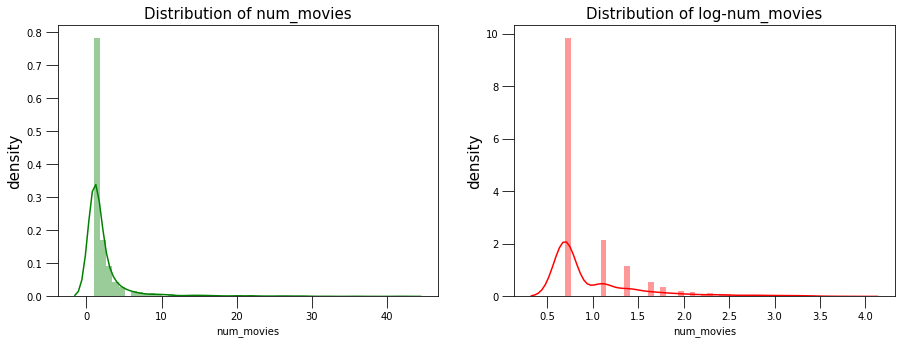

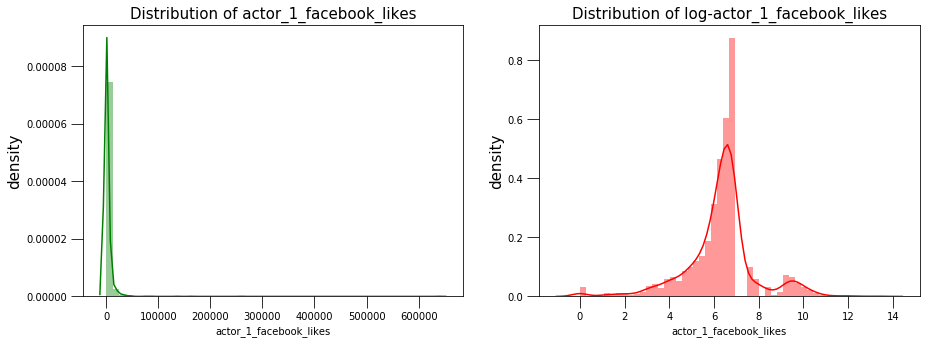

In [51]:
print("Actor1:")
for col in ["num_movies", "actor_1_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors1[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors1[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [52]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors1.num_movies = actors1.num_movies/actors1.num_movies.max()
# log for facebook likes
max_likes = np.log(actors1.actor_1_facebook_likes.max())
actors1.actor_1_facebook_likes = [1 if x == 0 else x for x in actors1.actor_1_facebook_likes.values] # edit zeros to use log
actors1.actor_1_facebook_likes = np.log(actors1.actor_1_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors1['mean_'] = actors1.num_movies*1/2 + actors1.actor_1_facebook_likes*1/2
massimo = actors1.mean_.max()
actors1['actor1_rank'] = [int(x) for x in actors1.mean_/massimo*10]

actors1 = actors1.sort_values(['actor1_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Actor',0,0,0,0]],columns=['actors1','num_movies','actor_1_facebook_likes','mean_','actor1_rank']).set_index('actors1')
actors1 = actors1.append(df2)

In [53]:
actors1.head(10)

num_movies  actor_1_facebook_likes     mean_  actor1_rank
actors1                                                                    
Robert De Niro             1                0.747897  0.873948           10
Johnny Depp         0.857143                0.792614  0.824878            9
Nicolas Cage        0.761905                0.702559  0.732232            8
Denzel Washington   0.690476                0.732887  0.711681            8
J.K. Simmons        0.690476                0.754405  0.722441            8
Matt Damon          0.690476                0.708546  0.699511            8
Robin Williams      0.642857                0.807794  0.725325            8
Bruce Willis        0.666667                0.708546  0.687606            7
Steve Buscemi       0.642857                0.702559  0.672708            7
Bill Murray         0.619048                0.708546  0.663797            7

**Actor 2** <a name="a2"></a>

In [54]:
# actor_2_name
actor2 = movie_df.groupby('actor_2_name') # group the database for the actor_2_name
actors2 = list(movie_df.actor_2_name.values) #director list
actors2_unique =list(OrderedDict.fromkeys(actors2)) # no duplicates

#number of movies for each actor2
results = [actors2.count(x) for x in actors2_unique] #number of films
actors2 = pd.DataFrame([actors2_unique, results], index=['actors2', 'num_movies']).T
actors2 = actors2.set_index('actors2')

# mean actor_2_facebook_likes for the movies did by that director
num_likes = actor2.mean().actor_2_facebook_likes
actors2 = actors2.merge(num_likes,how='left', left_index=True, right_index=True)

actors2.head(5)

num_movies  actor_2_facebook_likes
actors2                                              
Natasha Lyonne              2                  1000.0
Lloyd Bridges               1                   575.0
Christopher Atkins          1                   511.0
Aretha Franklin             1                   809.0
Rodney Dangerfield          1                   573.0

Actor2:


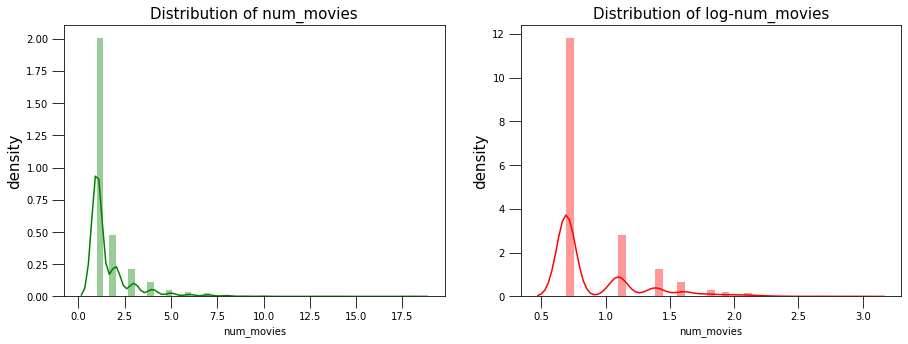

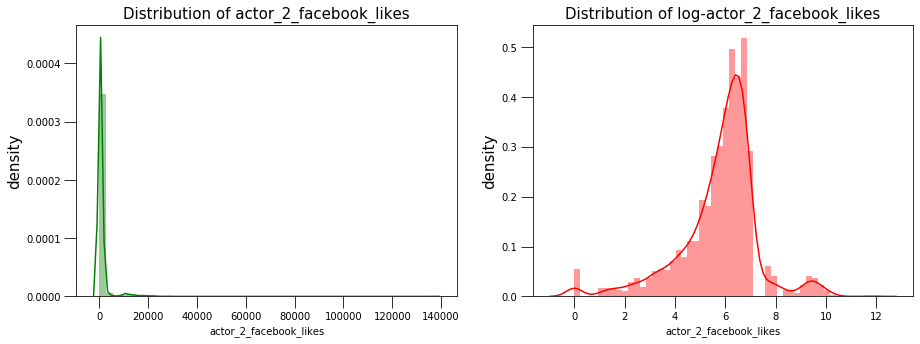

In [55]:
print("Actor2:")
for col in ["num_movies", "actor_2_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors2[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors2[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [56]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors2.num_movies = actors2.num_movies/actors2.num_movies.max()
# log for facebook likes
max_likes = np.log(actors2.actor_2_facebook_likes.max())
actors2.actor_2_facebook_likes = [1 if x == 0 else x for x in actors2.actor_2_facebook_likes.values] # edit zeros to use log
actors2.actor_2_facebook_likes = np.log(actors2.actor_2_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors2['mean_'] = actors2.num_movies*1/2 + actors2.actor_2_facebook_likes*1/2
massimo = actors2.mean_.max()
actors2['actor2_rank'] = [int(x) for x in actors2.mean_/massimo*10]

actors2 = actors2.sort_values(['actor2_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Second Actor',0,0,0,0]],columns=['actors2','num_movies','actor_2_facebook_likes','mean_','actor2_rank']).set_index('actors2')
actors2 = actors2.append(df2)

actors2.head(10)

num_movies  actor_2_facebook_likes     mean_  actor2_rank
actors2                                                                  
Morgan Freeman           1                0.786765  0.893383           10
Charlize Theron   0.777778                0.769799  0.773788            8
Brad Pitt         0.722222                0.786765  0.754494            8
Meryl Streep      0.555556                0.786765   0.67116            7
Adam Sandler      0.555556                0.786765   0.67116            7
James Franco      0.555556                0.786765   0.67116            7
Bruce Willis           0.5                0.800889  0.650445            7
Will Ferrell           0.5                0.759841   0.62992            7
Kate Winslet      0.444444                0.807155    0.6258            7
Robert Duvall     0.444444                0.676915   0.56068            6

**Actor 3** <a name="a3"></a>

In [57]:
# actor_3_name
actor3 = movie_df.groupby('actor_3_name') # group the database for the actor_3_name
actors3 = list(movie_df.actor_3_name.values) #director list
actors3_unique =list(OrderedDict.fromkeys(actors3)) # no duplicates

#number of movies for each actor3
results = [actors3.count(x) for x in actors3_unique] #number of films
actors3 = pd.DataFrame([actors3_unique, results], index=['actors3', 'num_movies']).T
actors3 = actors3.set_index('actors3')

# mean actor_3_facebook_likes for the movies did by that director
num_likes = actor3.mean().actor_3_facebook_likes
actors3 = actors3.merge(num_likes,how='left', left_index=True, right_index=True)

actors3.head(5)

num_movies  actor_3_facebook_likes
actors3                                               
Bradley Whitford             1                   821.0
Barbara Billingsley          1                   318.0
Leo McKern                   2                    83.0
Ray Charles                  1                   326.0
Brian Doyle-Murray           2                   484.0

Actor3:


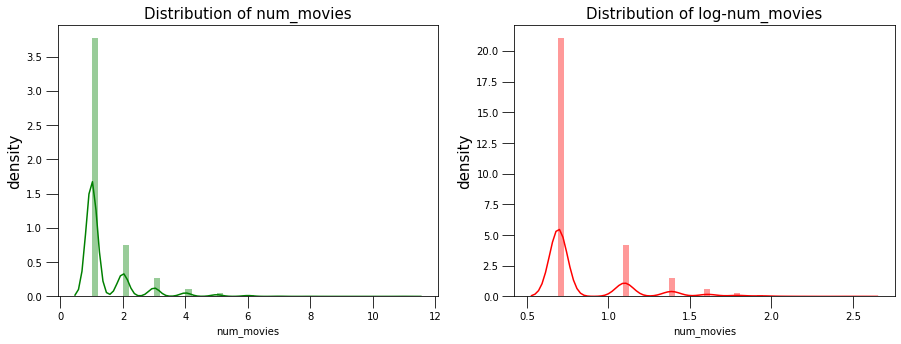

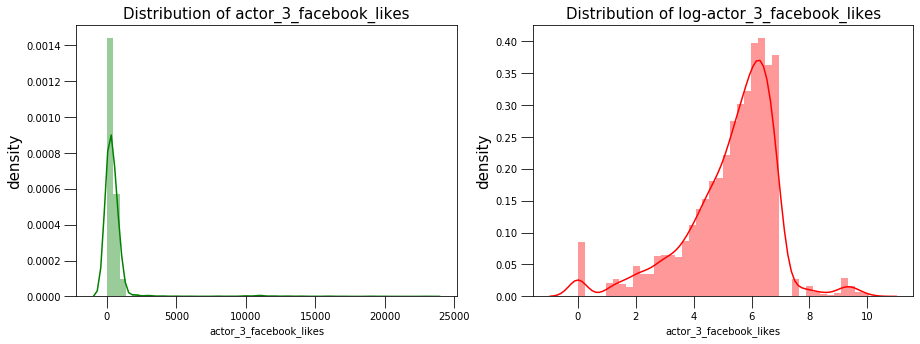

In [58]:
print("Actor3:")
for col in ["num_movies", "actor_3_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors3[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors3[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [59]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors3.num_movies = actors3.num_movies/actors3.num_movies.max()
# log for facebook likes
max_likes = np.log(actors3.actor_3_facebook_likes.max())
actors3.actor_3_facebook_likes = [1 if x == 0 else x for x in actors3.actor_3_facebook_likes.values] # edit zeros to use log
actors3.actor_3_facebook_likes = np.log(actors3.actor_3_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors3['mean_'] = actors3.num_movies*1/2 + actors3.actor_3_facebook_likes*1/2
massimo = actors3.mean_.max()
actors3['actor3_rank'] = [int(x) for x in actors3.mean_/massimo*10]

actors3 = actors3.sort_values(['actor3_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Third Actor',0,0,0,0]],columns=['actors3','num_movies','actor_3_facebook_likes','mean_','actor3_rank']).set_index('actors3')
actors3 = actors3.append(df2)

actors3.head()

num_movies  actor_3_facebook_likes     mean_  actor3_rank
actors3                                                                
Anne Hathaway   0.545455                0.926558  0.736006           10
Steve Coogan    0.727273                0.687801  0.707537            9
Kirsten Dunst   0.545455                0.825833  0.685644            9
Steve Carell    0.545455                0.881554  0.713504            9
Gary Oldman     0.454545                0.917068  0.685807            9

Add director and actors ratings to movie_df:

In [60]:
movie_df['imdb_id'] = movie_df.index
movie_df = pd.merge(left=movie_df, right=directors.director_rank , left_on='director_name', right_on='director')
movie_df = pd.merge(left=movie_df, right=actors1.actor1_rank , left_on='actor_1_name', right_on='actors1')
movie_df = pd.merge(left=movie_df, right=actors2.actor2_rank , left_on='actor_2_name', right_on='actors2')
movie_df = pd.merge(left=movie_df, right=actors3.actor3_rank , left_on='actor_3_name', right_on='actors3')

movie_df = movie_df.sort_values(by='imdb_id').drop_duplicates(subset='imdb_id', keep='last').set_index('imdb_id')
movie_df

director_name  num_critic_for_reviews  duration  \
imdb_id                                                          
tt0035423      James Mangold                   125.0     123.0   
tt0080487       Harold Ramis                    71.0      98.0   
tt0080549      Michael Apted                    46.0     124.0   
tt0080661     Brian De Palma                   121.0     104.0   
tt0080678        David Lynch                   117.0     124.0   
...                      ...                     ...       ...   
tt4733536          Nick Love                    16.0      86.0   
tt4786282  David F. Sandberg                   159.0      81.0   
tt4824308       Harold Cronk                    29.0     120.0   
tt5078326       Thomas Lilti                    18.0     102.0   
tt5215952        Hong-jin Na                    77.0     156.0   

           director_facebook_likes  actor_3_facebook_likes  \
imdb_id                                                      
tt0035423                    446.0                   821.0   
tt0080487                  11000.0                   484.0   
tt0080549                    150.0                   572.0   
tt0080661                      0.0                   517.0   
tt0080678                      0.0                   452.0   
...                            ...                     ...   
tt4733536                     63.0                   175.0   
tt4786282                     26.0                   300.0   
tt4824308                     18.0                   295.0   
tt5078326                     12.0                     2.0   
tt5215952                     43.0                     0.0   

                 actor_2_name  actor_1_facebook_likes       gross  \
imdb_id                                                             
tt0035423      Natasha Lyonne                 20000.0  47095453.0   
tt0080487  Rodney Dangerfield                 13000.0  39800000.0   
tt0080549    Beverly D'Angelo                   874.0  79900000.0   
tt0080661     David Margulies                   754.0  31899000.0   
tt0080678       Anne Bancroft                 12000.0  26010864.0   
...                       ...                     ...         ...   
tt4733536   Christopher Berry                   489.0  25003072.0   
tt4786282        Amiah Miller                  2000.0  56536016.0   
tt4824308        Robin Givens                   634.0  20773070.0   
tt5078326         Félix Moati                   541.0  25003072.0   
tt5215952        Jun Kunimura                    45.0    770629.0   

                                    genres         actor_1_name  ...  \
imdb_id                                                          ...   
tt0035423           Comedy|Fantasy|Romance         Hugh Jackman  ...   
tt0080487                     Comedy|Sport          Bill Murray  ...   
tt0080549    Biography|Drama|Music|Musical         Sissy Spacek  ...   
tt0080661         Mystery|Romance|Thriller      Angie Dickinson  ...   
tt0080678                  Biography|Drama      Anthony Hopkins  ...   
...                                    ...                  ...  ...   
tt4733536       Action|Comedy|Drama|Sci-Fi        Eddie Griffin  ...   
tt4786282                           Horror          Billy Burke  ...   
tt4824308                            Drama  Benjamin A. Onyango  ...   
tt5078326                     Comedy|Drama      François Cluzet  ...   
tt5215952  Fantasy|Horror|Mystery|Thriller       Jung-min Hwang  ...   

          Mystery_Thriller_Horror  Sci-Fi_Fantasy  Family_Animation  \
imdb_id                                                               
tt0035423                       0               1                 0   
tt0080487                       0               0                 0   
tt0080549                       0               0                 0   
tt0080661                       1               0                 0   
tt0080678                       0               0                 0   
...              

## 2b) Rating Recent Movies <a name="rat_new"></a>

In this section we searched for the most famous actor and the most prominent director after 2000. 

In [61]:
movie_recent_df = movie_df[movie_df.title_year>2000] # select movies after 2000

**Director**

In [62]:
group_director = movie_recent_df.groupby('director_name') 
directors = list(movie_recent_df.director_name.values) 
directors_unique =list(OrderedDict.fromkeys(directors))

results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')

# mean movie_facebook_likes for the movies did by that director
likes =   group_director.mean().movie_facebook_likes
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)
directors = directors.merge(likes, how='left', left_index=True, right_index=True)
directors.num_movies = directors.num_movies/directors.num_movies.max()
directors.movie_facebook_likes = directors.movie_facebook_likes/directors.movie_facebook_likes.max()
directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/3 + directors.imdb_score*1/3 + directors.movie_facebook_likes*1/3
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]

directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

string_dir = color.BOLD + directors.index[0] + color.END
print(f"The most prominent director after 2000 is {string_dir}")

The most prominent director after 2000 is Christopher Nolan


**Actor 1** <a name="a1"></a>

In [63]:
# actor_1_name
actor1 = movie_recent_df.groupby('actor_1_name') # group the database for the actor_1_name
actors1 = list(movie_recent_df.actor_1_name.values) #director list
actors1_unique =list(OrderedDict.fromkeys(actors1)) # no duplicates

#number of movies for each actor1
results = [actors1.count(x) for x in actors1_unique] #number of films
actors1 = pd.DataFrame([actors1_unique, results], index=['actors1', 'num_movies']).T
actors1 = actors1.set_index('actors1')

# mean actor_1_facebook_likes for the movies did by that director
num_likes = actor1.mean().actor_1_facebook_likes
actors1 = actors1.merge(num_likes, how='left', left_index=True, right_index=True)

#we divide wach value for the max of that column in order to have values between 0 and 1
actors1.num_movies = actors1.num_movies/actors1.num_movies.max()
# log for facebook likes
max_likes = np.log(actors1.actor_1_facebook_likes.max())
actors1.actor_1_facebook_likes = [1 if x == 0 else x for x in actors1.actor_1_facebook_likes.values] # edit zeros to use log
actors1.actor_1_facebook_likes = np.log(actors1.actor_1_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors1['mean_'] = actors1.num_movies*1/2 + actors1.actor_1_facebook_likes*1/2
massimo = actors1.mean_.max()
actors1['actor1_rank'] = [int(x) for x in actors1.mean_/massimo*10]

actors1 = actors1.sort_values(['actor1_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Actor',0,0,0,0]],columns=['actors1','num_movies','actor_1_facebook_likes','mean_','actor1_rank']).set_index('actors1')
actors1 = actors1.append(df2)

string_act = color.BOLD + actors1.index[0] + color.END
print(f"The most prominent director after 2000 is {string_act}")

The most prominent director after 2000 is Johnny Depp


## 4) Fill Missed Budget Values <a name="missed_budget"></a>

In this section we fil missed values for the budget

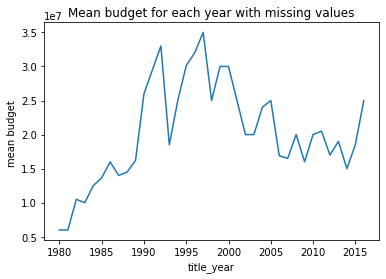

In [64]:
# Mean budget for each year with missing values

grouped_by_year = movie_df.groupby("title_year").budget.median()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean budget ")
plt.title("Mean budget for each year with missing values")
plt.show()

Even if the mean of budgets of each year is not zero, it can happens that the budget of some movies is zero (this means that the value was missed and we replaced it with zero)

In [65]:
# missed values
zero_budget = (movie_df.budget == 0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 246


For each movie we have a rank of its director and its cast. These elements are the ones which influence most the movie's budget. Another feature which influence the cost of a movie is the genre. We will rank every movie considering cast/director and its genre

**cast/director**

In [66]:
# rank for the cast considering its 3 actors rank
fill_budget_df = movie_df[['actor1_rank','actor2_rank','actor3_rank']]

In [67]:
# the protagonist has a bigger weight than others: 50% first actor, 30% second actor, 20% third actor
fill_budget_df['rank_cast'] = fill_budget_df.actor1_rank * 0.5 + fill_budget_df.actor2_rank * 0.30 + fill_budget_df.actor2_rank * 0.2
fill_budget_df.head()

actor1_rank  actor2_rank  actor3_rank  rank_cast
imdb_id                                                    
tt0035423            6            3            5        4.5
tt0080487            7            3            5        5.0
tt0080549            3            4            4        3.5
tt0080661            2            3            4        2.5
tt0080678            6            4            5        5.0

In [68]:
fill_budget_df = fill_budget_df.drop(columns= ['actor1_rank','actor2_rank','actor3_rank'])
fill_budget_df['director_rank'] = movie_df.director_rank
fill_budget_df.head()

rank_cast  director_rank
imdb_id                            
tt0035423        4.5              5
tt0080487        5.0              3
tt0080549        3.5              4
tt0080661        2.5              3
tt0080678        5.0              4

**genre**

Some genres requires a bigger investment. We found some articles which proves that (see Report). In particular, the most expensive are
- Action_Adventure
- Sci-Fi_Fantasy
- History_War

Average 65 milion

Then there is
- Animation

Average 60 milion

Others have a mean of 20 milion.

Then we can assign to each movie a rank based on genre average cost:

In [69]:
movie_genres = movie_df[[
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War','Others']]

movie_genres.to_csv('data/data_genre.csv')

movie_genres.head()

Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  \
imdb_id                                                                        
tt0035423          0       1      0      0        1                        0   
tt0080487          0       1      0      0        0                        0   
tt0080549          1       0      0      1        0                        0   
tt0080661          0       0      0      0        1                        1   
tt0080678          1       0      0      1        0                        0   

           Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  \
imdb_id                                                                      
tt0035423               1                 0                 0            0   
tt0080487               0                 0                 0            0   
tt0080549               0                 0                 0            0   
tt0080661               0                 0                 0            0   
tt0080678               0                 0                 0            0   

           Others  
imdb_id            
tt0035423       0  
tt0080487       1  
tt0080549       1  
tt0080661       0  
tt0080678       0

In [70]:
genre_rank = []

for i in range(len(movie_genres)): #for each movie
    index = movie_genres.index[i]
    rowData = movie_genres.loc[ index , : ] # all genres of one movie
    
    if rowData.Action_Adventure==1 or rowData['Sci-Fi_Fantasy']==1 or rowData.History_War==1 :
        genre_rank.append(1)
    elif rowData.Family_Animation==1 :
        genre_rank.append(round(float(60/65),2))
    else :
        genre_rank.append(round(float(60/65),2))


In [71]:
fill_budget_df['genre_rank'] = genre_rank
fill_budget_df = fill_budget_df.sort_values('director_rank', ascending=False) #sort values

# scale 0-1 also for rank_cast and director_rank
fill_budget_df.rank_cast = fill_budget_df.rank_cast/fill_budget_df.rank_cast.max()
fill_budget_df.director_rank = [round(float(x),2) for x in fill_budget_df.director_rank]
fill_budget_df.director_rank = fill_budget_df.director_rank/fill_budget_df.director_rank.max()


Warning!!!! remember to comment that this is a ranking of importance. it does not mean that the costs are 0.3 0.3 0.3

We suppose each is equally important:

In [72]:
fill_budget_df['rank_for_budget'] = fill_budget_df.mean(axis=1)
fill_budget_df.head()

rank_cast  director_rank  genre_rank  rank_for_budget
imdb_id                                                         
tt0372784       0.65            1.0        1.00         0.883333
tt0468569       0.65            1.0        1.00         0.883333
tt1375666       0.60            1.0        1.00         0.866667
tt0278504       0.40            1.0        0.92         0.773333
tt1345836       0.55            1.0        1.00         0.850000

In [73]:
fill_budget_df = fill_budget_df.drop(columns= ['rank_cast','director_rank','genre_rank'])
fill_budget_df['budget'] = movie_df.budget
fill_budget_df = fill_budget_df.sort_values('rank_for_budget', ascending=False) #sort values
fill_budget_df.head()

rank_for_budget       budget
imdb_id                                
tt1057500         0.900000   60000000.0
tt0372784         0.883333  150000000.0
tt0468569         0.883333  185000000.0
tt0482571         0.866667   40000000.0
tt0118607         0.866667   36000000.0

Now each film has a rank of features which influence the budget. Keep all of them would be too complicate, then we identify a rank of 20 values.


In [74]:
massimo = fill_budget_df.rank_for_budget.max()
fill_budget_df['rank_for_budget_integer'] = [int(x) for x in fill_budget_df.rank_for_budget/massimo*2*10]
fill_budget_df.head()

rank_for_budget       budget  rank_for_budget_integer
imdb_id                                                         
tt1057500         0.900000   60000000.0                       20
tt0372784         0.883333  150000000.0                       19
tt0468569         0.883333  185000000.0                       19
tt0482571         0.866667   40000000.0                       19
tt0118607         0.866667   36000000.0                       19

In [75]:
# mean of each rank of budget, ignoring movies with missing budget (which would bias the mean)

# ignore zero budget movies
movies_with_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget==0].index)
movies_with_budget_df = movies_with_budget_df.drop(columns='rank_for_budget')
data = movies_with_budget_df.groupby(movies_with_budget_df.rank_for_budget_integer)
data = data.mean()
data.head()

budget
rank_for_budget_integer              
7                        1.100000e+06
8                        7.212500e+06
9                        6.648255e+06
10                       2.178331e+07
11                       2.816008e+07

Now for each rank (no movies under rank = 7) we have the mean of its movies. We can assign this value of budget to movies with missing budget

In [76]:
movies_missing_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget>0].index)
movies_missing_budget_df = movies_missing_budget_df.drop(columns='rank_for_budget')
movies_missing_budget_df.head()

budget  rank_for_budget_integer
imdb_id                                   
tt0319829     0.0                       14
tt0119051     0.0                       14
tt0893382     0.0                       13
tt0455499     0.0                       13
tt1172570     0.0                       13

In [77]:
print(f"We check that they are actually {len(movies_missing_budget_df)} movies")

We check that they are actually 246 movies


In [78]:
# fill values
for i in range(len(movies_missing_budget_df)):
    index = movies_missing_budget_df.index[i]
    rowData = movies_missing_budget_df.loc[ index , : ] # all genres of one movie
    rank_movie = int(rowData.rank_for_budget_integer)
    
    budget_movie =  data.loc[ rank_movie , : ].budget

    movie_df.update(
        movie_df.loc[movie_df.index == index, 'budget'].replace(0.0, budget_movie, regex=True)
    )

In [79]:
# we should have filled all zero budget values. check:
zero_budget = (movie_df.budget==0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 0


## 4) Gross Budget Ratio  <a name="ratio"></a>

We create the gross budget ratio feature, an important feature to understand the profitability of the movies. Note that the creation of this variable does not cause any probles because we have substitue every zero budget values in the [Filling Missed Budget Values](#missed_budget) part.

In [80]:
movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget

In [81]:
movie_df.to_csv('data/data_regression_median.csv')

# Exploratory Data Analysis (EDA) All movies  <a name="eda"></a>


## 1) Univariate Analysis <a name="uni"></a>

### Some high-level observations <a name="high_level"></a>

Firstly, we plot a general description of our data:

In [82]:
movie_df.describe()

num_critic_for_reviews     duration  director_facebook_likes  \
count             3966.000000  3966.000000              3966.000000   
mean               156.002521   108.126576               737.732980   
std                123.516388    21.246351              2947.447455   
min                  1.000000    14.000000                 0.000000   
25%                 65.000000    94.000000                 8.000000   
50%                128.000000   104.000000                54.000000   
75%                215.000000   118.000000               214.000000   
max                813.000000   330.000000             23000.000000   

       actor_3_facebook_likes  actor_1_facebook_likes         gross  \
count             3966.000000             3966.000000  3.966000e+03   
mean               706.133384             7375.525719  4.785363e+07   
std               1783.490418            15949.037026  6.876485e+07   
min                  0.000000                0.000000  6.180800e+01   
25%                157.000000              680.000000  7.446117e+06   
50%                405.000000             1000.000000  2.500307e+07   
75%                664.000000            12000.000000  5.838524e+07   
max              23000.000000           640000.000000  1.200264e+09   

       num_voted_users  cast_total_facebook_likes  facenumber_in_poster  \
count     3.966000e+03                3966.000000           3966.000000   
mean      9.304042e+04               10872.025466              1.400908   
std       1.450373e+05               19308.720843              2.074560   
min       5.000000e+00                   0.000000              0.000000   
25%       1.238425e+04                1621.750000              0.000000   
50%       4.263250e+04                3638.000000              1.000000   
75%       1.098888e+05               15389.750000              2.000000   
max       1.689764e+06              656730.000000             43.000000   

       num_user_for_reviews  ...  Sci-Fi_Fantasy  Family_Animation  \
count           3966.000000  ...     3966.000000       3966.000000   
mean             295.587746  ...        0.222642          0.116994   
std              393.473976  ...        0.416073          0.321454   
min                1.000000  ...        0.000000          0.000000   
25%               79.000000  ...        0.000000          0.000000   
50%              175.000000  ...        0.000000          0.000000   
75%              361.000000  ...        0.000000          0.000000   
max             5060.000000  ...        1.000000          1.000000   

       Action_Adventure  History_War       Others  director_rank  actor1_rank  \
count       3966.000000  3966.000000  3966.000000    3966.000000  3966.000000   
mean           0.319213     0.064297     0.132123       3.840898     3.942007   
std            0.466231     0.245311     0.338667       1.328000     1.976958   
min            0.000000     0.000000     0.000000       1.000000     0.000000   
25%            0.000000     0.000000     0.000000       3.000000     3.000000   
50%            0.000000     0.000000     0.000000       4.000000     3.000000   
75%            1.000000     0.000000     0.000000       5.000000     5.000000   
max            1.000000     1.000000     1.000000      10.000000    10.000000   

       actor2_rank  actor3_rank  gross_budget_ratio  
count  3966.000000  3966.000000         3966.000000  
mean      3.380484     4.517398            8.689927  
std       1.380539     1.597310          130.490720  
min       0.000000     0.000000            0.000017  
25%       3.000000     4.000000            0.446382  
50%       3.000000     5.000000            1.108586  
75%       4.000000     5.000000            2.372303  
max      10.000000    10.000000         7194.485533  

[8 rows x 31 columns]

### distribution
Distribution of the main numerical features of the data set
Due  the  right-skewed  of  the  distribution  of  budget  andgross earning, it is appropriate to consider the log trasformation of these variables

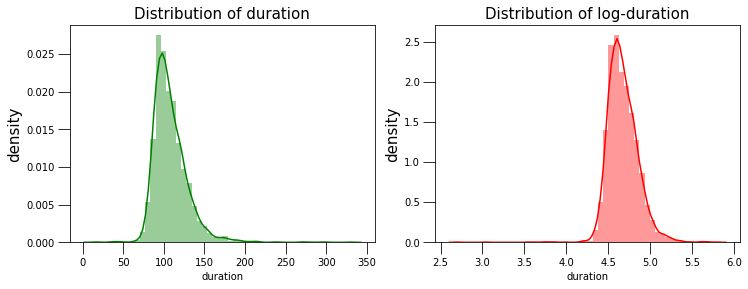

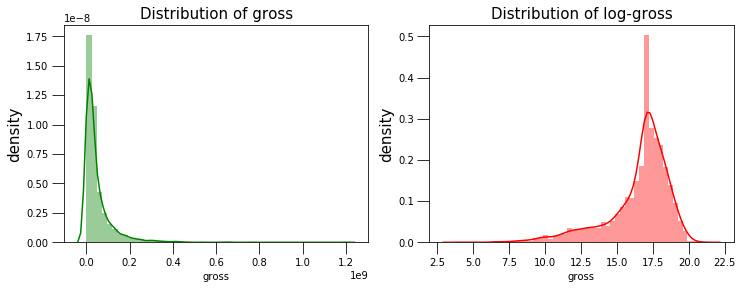

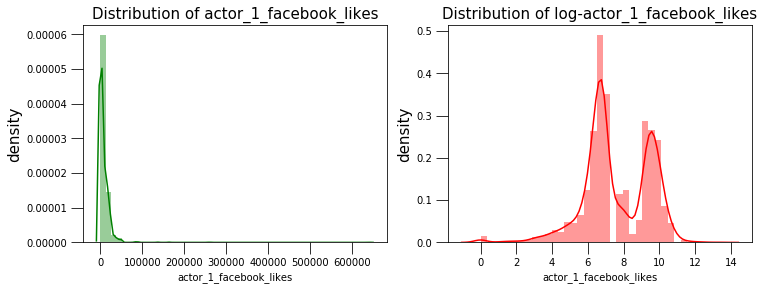

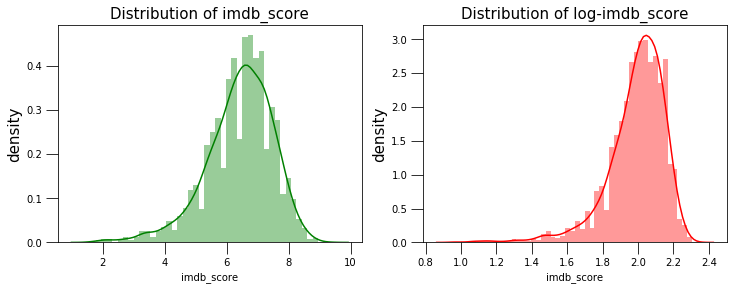

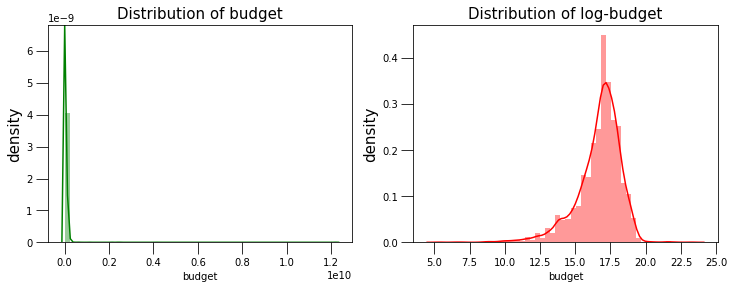

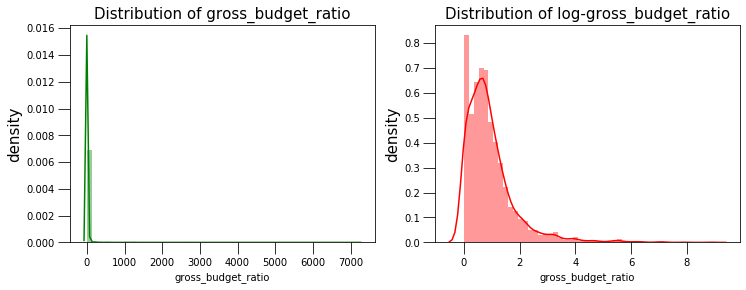

In [83]:



for col in ["duration", "gross", "actor_1_facebook_likes","imdb_score","budget","gross_budget_ratio"]:
    
    _, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
    sns.distplot(movie_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movie_df[col].fillna(0) + 1), color="r", ax=ax2)
    
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
        
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

we can see that distribution of budget and gross of movies are not so explanatory. This is due to the fact the the data sets includes both boxoffice movies and documentaries that have a significant difference in marketing and financial needs.
So it might be interesting to look at the number of movies by genre. 


#### Summary statistics of relevant variables

In [84]:
grossde=movie_df['gross'].describe()
budgetde=movie_df['budget'].describe()
ratiogb=movie_df['gross_budget_ratio'].describe()
profitde=(movie_df['gross']-movie_df['budget']).describe()
summary = pd.DataFrame([grossde,budgetde,profitde,ratiogb]).T
summary.columns.values[2] = "profits"
summary#summary statistics of relevant variables

gross        budget       profits  gross_budget_ratio
count  3.966000e+03  3.966000e+03  3.966000e+03         3966.000000
mean   4.785363e+07  4.322898e+07  4.624658e+06            8.689927
std    6.876485e+07  2.193372e+08  2.233179e+08          130.490720
min    6.180800e+01  2.180000e+02 -1.221330e+10            0.000017
25%    7.446117e+06  9.000000e+06 -1.103094e+07            0.446382
50%    2.500307e+07  2.380000e+07  1.611380e+06            1.108586
75%    5.838524e+07  4.867173e+07  2.320307e+07            2.372303
max    1.200264e+09  1.221550e+10  1.174264e+09         7194.485533

### SP500 and FED <a name="fed"></a>

Now, we plot the **SP 500** (see Report for details) for a comparison with the global economy

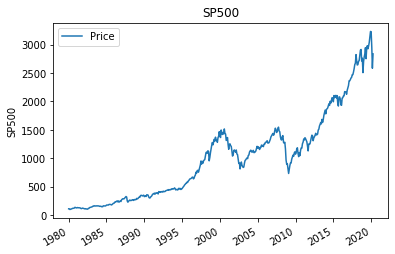

In [85]:
sp500 = (pd.read_csv(r'data/SeP500.csv')).iloc[::-1]
index = pd.period_range(start="01-01-1980", end="04-01-2020", freq="M")
sp500.index=index
sp500['Price'] = sp500['Price'].str.replace(',', '')
sp500['Price'] = sp500['Price'].astype(float)
sp500price=sp500.Price.resample("A").mean()
sp500.plot(x_compat=True)
plt.title("SP500") # fra check the title
plt.ylabel("SP500")
plt.show()

**FED**

Interest rate as index of required return

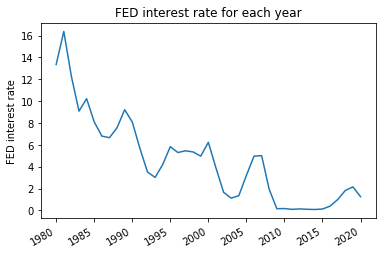

In [86]:
fed = (pd.read_csv(r'data/fed.csv'))#.iloc[::-1]

index = pd.period_range(start="01-01-1980", end="03-01-2020", freq="M")
fed.index=index

fed['FEDFUNDS'] = fed['FEDFUNDS'].astype(float)
fedrate=fed.FEDFUNDS.resample("A").mean()
fedrate.plot(x_compat=True)
plt.ylabel("FED interest rate")
plt.title("FED interest rate for each year")
plt.show()

### Trends mean gross/budget ratio overtime

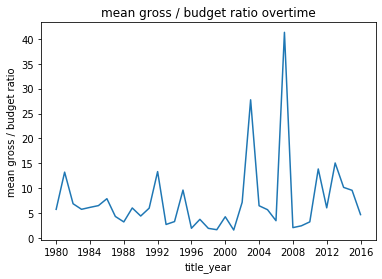

In [87]:

movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget
grouped_by_year = movie_df.groupby("title_year").gross_budget_ratio.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean gross / budget ratio")
plt.xticks(np.arange(min(grouped_by_year.index), max(grouped_by_year.index)+1, 4))
plt.title("mean gross / budget ratio overtime")
plt.show()

## 2) Bivariate Analysis <a name="biv"></a>
 
With this analysis we want to find out the relationship between a factor with the two indicators of a film's success: profitability and IMDB score.



### Relationship between profitability and IMDB score <a name="prof_imdb"></a>

In [88]:
movies_with_valid_profit = movie_df[movie_df.gross_budget_ratio<=20]

### Correlation imdb_score and gross_budget_ratio

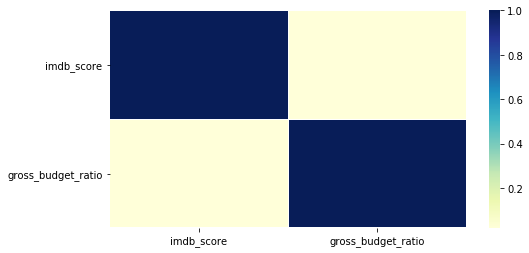

In [89]:
# again, don't see much influence here (between what?)

pivot=movie_df[['imdb_score',"gross_budget_ratio"]]
pivot=pivot[pivot.gross_budget_ratio<=20]
corp = pivot.apply(lambda x: pd.factorize(x)[0])#scaling 
corp=corp.corr()
plt.figure(figsize=(8, 4))
ax = sns.heatmap(corp, xticklabels=corp.columns, yticklabels=corp.columns, 
                 linewidths=.2, cmap="YlGnBu")
plt.yticks(rotation=0)  
plt.show()

In [90]:
## finction for writing the correlation explicitely in the pairplot
def cor(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 15, xycoords = ax.transAxes)
    

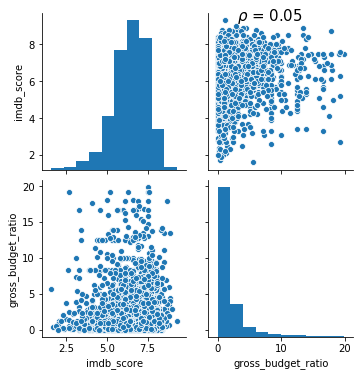

In [91]:
grid=sns.pairplot(data=movie_df[movie_df.gross_budget_ratio<=20], vars=["imdb_score", "gross_budget_ratio"])
grid = grid.map_upper(cor)

If we remove the outliers of profitability ratio, we see that to have a profitability ratio higher than 5, a movie must have an IMDb score of 4 and above.

In [92]:
movies_with_imdb_classmean=[]
movies_with_imdb_classmean.append(movie_df[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].gross_budget_ratio.mean())
movies_with_imdb_classmean.append(movie_df[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].gross_budget_ratio.mean()) 

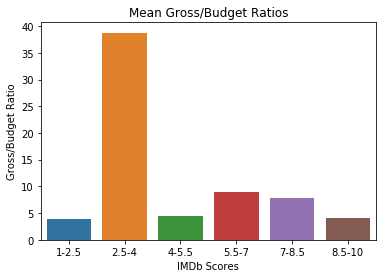

In [93]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean)
plt.xticks(rotation=0)
plt.ylabel("Gross/Budget Ratio")
plt.xlabel('IMDb Scores')
plt.title(f"Mean Gross/Budget Ratios")
plt.show()

In [94]:
movies_with_gb_classmean=[]
movies_with_gb_classmean.append(movie_df[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].imdb_score.mean())
movies_with_gb_classmean.append(movie_df[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(20<movie_df.gross_budget_ratio)].imdb_score.mean())

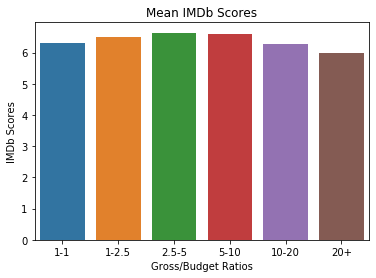

In [95]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean)
plt.xticks(rotation=0)
plt.ylabel("IMDb Scores")
plt.xlabel('Gross/Budget Ratios')
plt.title(f"Mean IMDb Scores")
plt.show()

## 3) Multivariate Analysis <a name="multi"></a>

## influnce of ranks on profitability


In [96]:
datara=movie_df[['imdb_score','director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio']]      
#datara = datara.apply(lambda x: pd.factorize(x)[0])
corre=datara.corr()

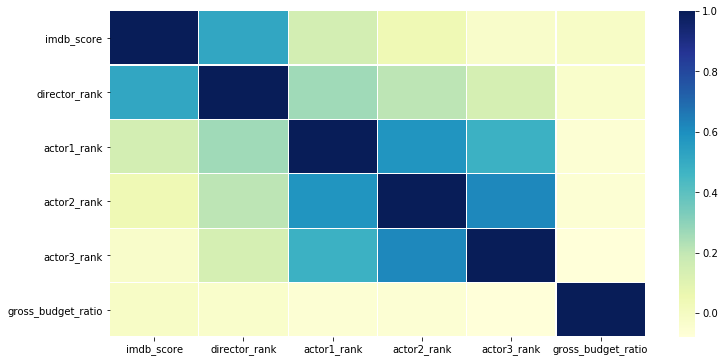

In [97]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(corre, xticklabels=corre.columns, yticklabels=corre.columns, 
                 linewidths=.2, cmap="YlGnBu")

we can see that on average the rank of the director and cast does not have an  impact on profitability. However, it is still worth check if this is a trend that is valid also fot top directors and actors since they are a significant part of the budget of a movie

### Influence of Social Media? <a name="social"></a>


In [98]:
datapi=movie_df[["cast_total_facebook_likes", "movie_facebook_likes", "director_facebook_likes",'imdb_score',"gross_budget_ratio","title_year"]]
datapi=datapi.loc[datapi.title_year>2009]
datapi=datapi.drop("title_year", axis=1)
datapi = datapi.apply(lambda x: pd.factorize(x)[0])
core=datapi.corr()


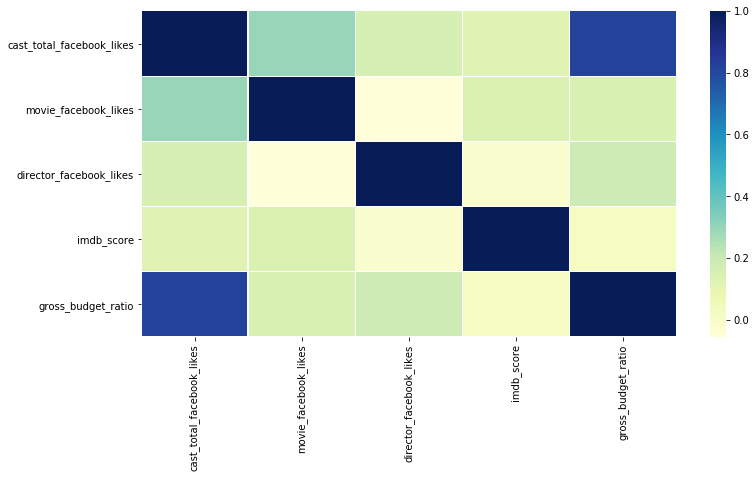

In [99]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(core, xticklabels=core.columns, yticklabels=core.columns, 
                 linewidths=.2, cmap="YlGnBu")

Here, we realize that IMDb score and movie facebook likes might be related. Hence, we analyze these two variables.

In [100]:
movies_with_imdb_classmean2=[]
movies_with_imdb_classmean2.append(datapi[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].cast_total_facebook_likes.mean())
movies_with_imdb_classmean2.append(datapi[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].cast_total_facebook_likes.mean()) 

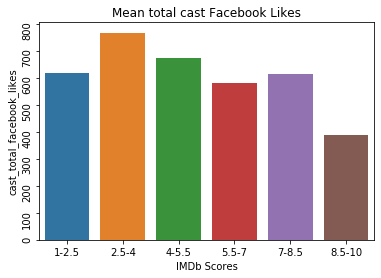

In [101]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast_total_facebook_likes")
plt.xlabel('IMDb Scores')
plt.title(f"Mean total cast Facebook Likes")
plt.yticks(rotation=90)
plt.show()

In [102]:
movies_with_gb_classmean2=[]
movies_with_gb_classmean2.append(datapi[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].cast_total_facebook_likes.mean())
movies_with_gb_classmean2.append(datapi[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(20<movie_df.gross_budget_ratio)].cast_total_facebook_likes.mean())

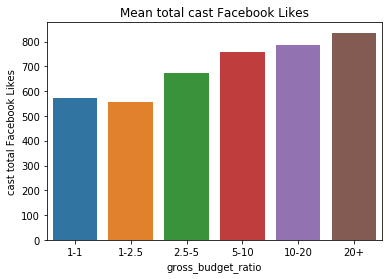

In [103]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast total Facebook Likes")
plt.xlabel('gross_budget_ratio')
plt.title(f"Mean total cast Facebook Likes")
plt.show()


### 3. Effect of Genre on Profitability and IMDb Score

### I. Profitability

In [104]:
##using genres_col,
GenreProf = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War','Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].mean()
GenreNumber = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War', 'Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].count()

In [105]:
Genrestable = GenreProf.to_frame()
Genrestable1 = Genrestable.reset_index()
Genrestable2 = Genrestable1.sort_values(by=['gross_budget_ratio'],ascending=False)

In [106]:
GenreNumber1 = GenreNumber.reset_index()

GenreNumber2 = GenreNumber1.reindex(Genrestable2.index)

In [107]:
Genrestable2

Action_Adventure  Biography  Comedy  Crime  Drama  Family_Animation  \
181                 1          0       0      0      0                 0   
28                  0          0       0      0      1                 0   
209                 1          0       0      0      1                 1   
238                 1          0       1      0      0                 0   
5                   0          0       0      0      0                 0   
..                ...        ...     ...    ...    ...               ...   
99                  0          0       1      0      1                 0   
127                 0          0       1      1      1                 1   
94                  0          0       1      0      1                 0   
69                  0          0       1      0      0                 0   
282                 1          0       1      1      1                 0   

     History_War  Mystery_Thriller_Horror  Others  Romance  Sci-Fi_Fantasy  \
181            1                        0       1        0               0   
28             0                        1       1        1               1   
209            0                        0       1        0               0   
238            1                        0       0        0               0   
5              0                        1       0        1               0   
..           ...                      ...     ...      ...             ...   
99             1                        0       0        0               0   
127            0                        0       0        0               0   
94             0                        0       1        1               1   
69             0                        0       1        0               1   
282            0                        1       0        1               0   

     gross_budget_ratio  
181           12.501536  
28            10.001229  
209            9.395195  
238            8.530000  
5              8.047961  
..                  ...  
99             0.012206  
127            0.007442  
94             0.001359  
69             0.001218  
282            0.000017  

[296 rows x 12 columns]

In [108]:
GenreNumber2

Action_Adventure  Biography  Comedy  Crime  Drama  Family_Animation  \
181                 1          0       0      0      0                 0   
28                  0          0       0      0      1                 0   
209                 1          0       0      0      1                 1   
238                 1          0       1      0      0                 0   
5                   0          0       0      0      0                 0   
..                ...        ...     ...    ...    ...               ...   
99                  0          0       1      0      1                 0   
127                 0          0       1      1      1                 1   
94                  0          0       1      0      1                 0   
69                  0          0       1      0      0                 0   
282                 1          0       1      1      1                 0   

     History_War  Mystery_Thriller_Horror  Others  Romance  Sci-Fi_Fantasy  \
181            1                        0       1        0               0   
28             0                        1       1        1               1   
209            0                        0       1        0               0   
238            1                        0       0        0               0   
5              0                        1       0        1               0   
..           ...                      ...     ...      ...             ...   
99             1                        0       0        0               0   
127            0                        0       0        0               0   
94             0                        0       1        1               1   
69             0                        0       1        0               1   
282            0                        1       0        1               0   

     gross_budget_ratio  
181                   1  
28                    1  
209                   1  
238                   1  
5                     3  
..                  ...  
99                    1  
127                   1  
94                    1  
69                    1  
282                   1  

[296 rows x 12 columns]

From the 2 dataframe above, we see that 3 movies with genres Drama,Crime and Romance together achieved 5.3 gross/budget ratio. However, since number of movies are low it might be due to some outlier. Hence, we try to analyze highest number of movies with the same genre combination.

In [109]:
GenreNumber3=GenreNumber2.sort_values(by=['gross_budget_ratio'],ascending=False)
Genrestable3 = Genrestable2.reindex(GenreNumber3.index)

In [110]:
GenreNumber3

Action_Adventure  Biography  Comedy  Crime  Drama  Family_Animation  \
15                  0          0       0      0      1                 0   
3                   0          0       0      0      0                 0   
88                  0          0       1      0      1                 0   
90                  0          0       1      0      1                 0   
64                  0          0       1      0      0                 0   
..                ...        ...     ...    ...    ...               ...   
283                 1          1       0      0      0                 0   
166                 0          1       1      1      1                 0   
11                  0          0       0      0      0                 1   
10                  0          0       0      0      0                 1   
282                 1          0       1      1      1                 0   

     History_War  Mystery_Thriller_Horror  Others  Romance  Sci-Fi_Fantasy  \
15             0                        0       0        0               0   
3              0                        1       0        0               0   
88             0                        0       0        0               0   
90             0                        0       0        1               0   
64             0                        0       0        0               0   
..           ...                      ...     ...      ...             ...   
283            0                        0       0        0               0   
166            0                        1       0        1               0   
11             0                        0       1        0               0   
10             0                        0       0        0               1   
282            0                        1       0        1               0   

     gross_budget_ratio  
15                  162  
3                   160  
88                  157  
90                  156  
64                  155  
..                  ...  
283                   1  
166                   1  
11                    1  
10                    1  
282                   1  

[296 rows x 12 columns]

In [111]:
Genrestable3

Action_Adventure  Biography  Comedy  Crime  Drama  Family_Animation  \
15                  0          0       0      0      1                 0   
3                   0          0       0      0      0                 0   
88                  0          0       1      0      1                 0   
90                  0          0       1      0      1                 0   
64                  0          0       1      0      0                 0   
..                ...        ...     ...    ...    ...               ...   
283                 1          1       0      0      0                 0   
166                 0          1       1      1      1                 0   
11                  0          0       0      0      0                 1   
10                  0          0       0      0      0                 1   
282                 1          0       1      1      1                 0   

     History_War  Mystery_Thriller_Horror  Others  Romance  Sci-Fi_Fantasy  \
15             0                        0       0        0               0   
3              0                        1       0        0               0   
88             0                        0       0        0               0   
90             0                        0       0        1               0   
64             0                        0       0        0               0   
..           ...                      ...     ...      ...             ...   
283            0                        0       0        0               0   
166            0                        1       0        1               0   
11             0                        0       1        0               0   
10             0                        0       0        0               1   
282            0                        1       0        1               0   

     gross_budget_ratio  
15             1.822991  
3              3.954018  
88             2.080593  
90             2.319489  
64             2.244205  
..                  ...  
283            1.128571  
166            1.137931  
11             1.210078  
10             1.254668  
282            0.000017  

[296 rows x 12 columns]

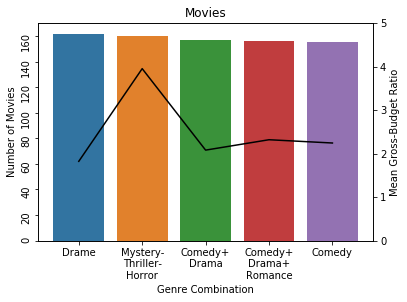

In [112]:
plt.figure() 
genres =['Drame','Mystery-\nThriller-\nHorror','Comedy+\nDrama','Comedy+\nDrama+\nRomance','Comedy']
sns.barplot(genres, GenreNumber3.gross_budget_ratio[:5])
#Genrestable3.gross_budget_ratio[:5].plot(secondary_y=True)
plt.xticks(rotation=0)
plt.ylabel("Number of Movies")
plt.xlabel('Genre Combination')
plt.title(f"Movies")
plt.xticks(rotation=0)
plt.yticks(rotation=90)

axes2 = plt.twinx()
axes2.plot(genres, Genrestable3.gross_budget_ratio[:5], color='k')
axes2.set_ylim(0, 5)
axes2.set_ylabel('Mean Gross-Budget Ratio')


plt.show()

Here, we see that at the top 5 places all combinations have more than 140 movies. Hence, we can comment more confidently. We see that most of the segments include Drama in it and all of them has gross/budget ratio higher than 1.8 which is a nice number for film makers. By looking at the data, we can say that:
1. Drama Only ~ 1.8
2. Mystery-Thriller-Horror ~ 3.95
3. Drama + Comedy ~ 2.1
4. Drama + Comedy + Romance ~2.3
5. Comedy Only ~ 2.2

Hence, it might be logical to make a drama movie with some comedy and romance in it.

### Let's look at films from a prominent director  <a name="prominent_director"></a>

cambia il titolo e fai una mini spiegazione introduttiva di cosa fai in questa sezione

In [113]:
director = "Christopher Nolan" # change this variable if you want to look into another director
director_films = movie_df.query(f"director_name == '{director}'").sort_values(by="title_year")
genres_col={'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others'}

In [114]:
## genres of films directed and years in which a movie has been released
sums=director_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(director_films.title_year.value_counts())
print("\n")

Genres' counter

Group  Sci-Fi_Fantasy = 3
Group  Family_Animation = 0
Group  Others = 0
Group  Romance = 0
Group  Crime = 1
Group  Drama = 4
Group  Mystery_Thriller_Horror = 6
Group  Action_Adventure = 5
Group  History_War = 0
Group  Comedy = 0
Group  Biography = 0


Number of films per year 

2014.0    1
2012.0    1
2010.0    1
2008.0    1
2006.0    1
2005.0    1
2002.0    1
2000.0    1
Name: title_year, dtype: int64




### Gross budget levels overtime

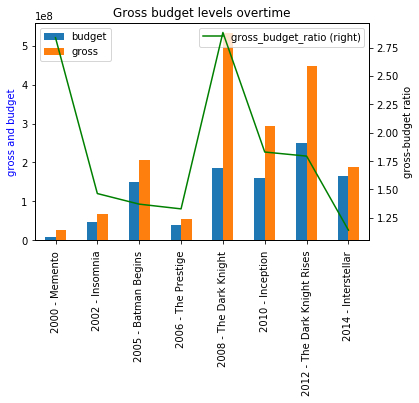

In [115]:
director_titles_years = director_films["title_year"].map(int).map(str) + " - " + director_films["movie_title"].map(str)  
graph=director_films["budget"].to_frame()
graph['gross_budget_ratio']=director_films["gross_budget_ratio"]
graph['gross']=director_films["gross"]
graph.index=director_titles_years

ax = plt.subplot(111)
ax2= ax.twinx()
graph.gross_budget_ratio.plot(ax=ax2, style='g-', secondary_y=True, legend='ratio')
ax.set_ylabel('gross and budget', color='b')
graph.plot(ax=ax,y=["budget", "gross"], kind="bar")
plt.ylabel("gross-budget ratio")
ax.tick_params(axis='x', rotation=90)
leg = ax.get_legend()
leg.remove()        # remove it from ax
ax2.add_artist(leg) # add it to ax2
leg._set_loc(2)
plt.title("Gross budget levels overtime")
plt.show()

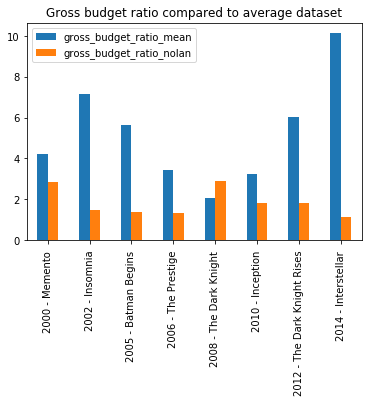

In [116]:
grouped_by_yearn = movie_df.groupby("title_year").gross_budget_ratio.mean()
grouped_by_yearn = grouped_by_yearn[grouped_by_yearn.index.isin(director_films.title_year)]
grouped_by_yearn=grouped_by_yearn.to_frame()
grouped_by_yearn.index=graph.index

grouped_by_yearn.rename(columns={"gross_budget_ratio": "gross_budget_ratio_mean"}, inplace=True)
grouped_by_yearn['gross_budget_ratio_nolan']=graph.gross_budget_ratio
ax = plt.subplot(111)
grouped_by_yearn.plot(ax=ax,y=["gross_budget_ratio_mean",'gross_budget_ratio_nolan'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title("Gross budget ratio compared to average dataset")
plt.show()

### cast total facebook likes for films of our porminient director

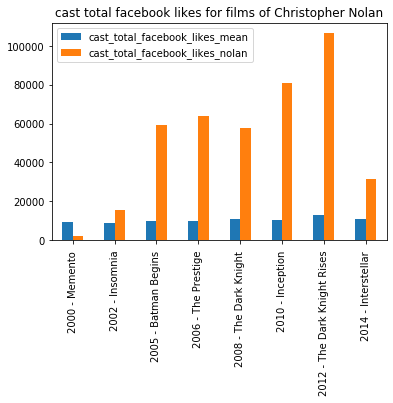

In [117]:
grouped_by_yearn = movie_df.groupby("title_year").cast_total_facebook_likes.mean()
grouped_by_yearn = grouped_by_yearn[grouped_by_yearn.index.isin(director_films.title_year)]
grouped_by_yearn=grouped_by_yearn.to_frame()
grouped_by_yearn.index=graph.index
subdata=director_films
subdata.index=graph.index
grouped_by_yearn.rename(columns={"cast_total_facebook_likes": "cast_total_facebook_likes_mean"}, inplace=True)
grouped_by_yearn['cast_total_facebook_likes_nolan']=subdata.cast_total_facebook_likes
ax = plt.subplot(111)
grouped_by_yearn.plot(ax=ax,y=["cast_total_facebook_likes_mean",'cast_total_facebook_likes_nolan'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"cast total facebook likes for films of {director}")
plt.show()

### IMDB Score for films of our porminient director

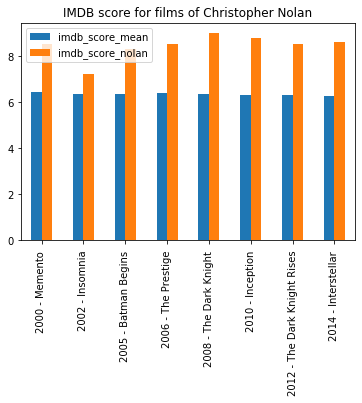

In [118]:
grouped_by_yearn = movie_df.groupby("title_year").imdb_score.mean()
grouped_by_yearn = grouped_by_yearn[grouped_by_yearn.index.isin(director_films.title_year)]
grouped_by_yearn=grouped_by_yearn.to_frame()
grouped_by_yearn.index=graph.index
subdata=director_films
subdata.index=graph.index
grouped_by_yearn.rename(columns={"imdb_score": "imdb_score_mean"}, inplace=True)
grouped_by_yearn['imdb_score_nolan']=subdata.imdb_score
ax = plt.subplot(111)
grouped_by_yearn.plot(ax=ax,y=["imdb_score_mean",'imdb_score_nolan'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"IMDB score for films of {director}")
plt.show()

## Analysis for a prominent actor 

in order to test the validity on the results in the EDA also for top ranked actors is relevant check if the same trends can be found for a prominent actor

In [119]:
actor = "Johnny Depp" # change this variable if you want to look into another director
actor_films = movie_df.query(f"actor_1_name == '{actor}'").sort_values(by="title_year")


In [120]:
## genres of films in which the actor has appeared as main actor and years in which a movie has been released
sums=actor_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(actor_films.title_year.value_counts())
print("\n")

Genres' counter

Group  Sci-Fi_Fantasy = 13
Group  Family_Animation = 6
Group  Others = 4
Group  Romance = 8
Group  Crime = 5
Group  Drama = 14
Group  Mystery_Thriller_Horror = 11
Group  Action_Adventure = 14
Group  History_War = 2
Group  Comedy = 9
Group  Biography = 6


Number of films per year 

2004.0    3
2014.0    3
2005.0    2
2001.0    2
2003.0    2
2015.0    2
2016.0    2
2010.0    2
2011.0    2
2009.0    1
2007.0    1
2006.0    1
2012.0    1
2013.0    1
1999.0    1
1998.0    1
1997.0    1
1994.0    1
1993.0    1
1990.0    1
1986.0    1
1984.0    1
Name: title_year, dtype: int64




### Gross budget levels overtime

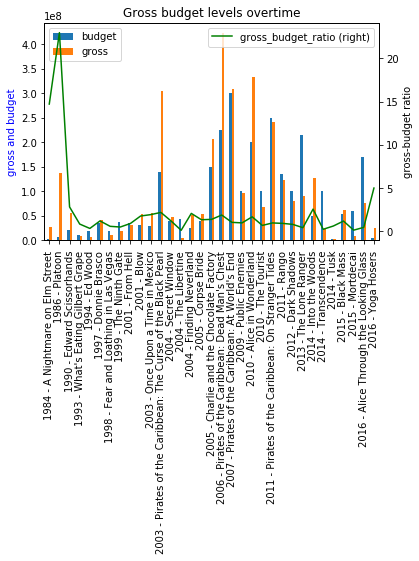

In [121]:
actor_titles_years = actor_films["title_year"].map(int).map(str) + " - " + actor_films["movie_title"].map(str)  
graph=actor_films["budget"].to_frame()
graph['gross_budget_ratio']=actor_films["gross_budget_ratio"]
graph['gross']=actor_films["gross"]
graph.index=actor_titles_years

ax = plt.subplot(111)
ax2= ax.twinx()
graph.gross_budget_ratio.plot(ax=ax2, style='g-', secondary_y=True, legend='ratio')
ax.set_ylabel('gross and budget', color='b')
graph.plot(ax=ax,y=["budget", "gross"], kind="bar")
plt.ylabel("gross-budget ratio")
ax.tick_params(axis='x', rotation=90)
leg = ax.get_legend()
leg.remove()        # remove it from ax
ax2.add_artist(leg) # add it to ax2
leg._set_loc(2)
plt.title("Gross budget levels overtime")
plt.show()

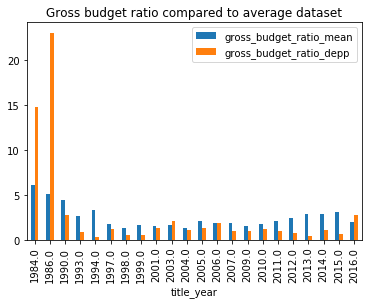

In [122]:
actor_titles_years = actor_films["title_year"]
graph=actor_films["budget"].to_frame()
graph['gross_budget_ratio']=actor_films["gross_budget_ratio"]
graph['gross']=actor_films["gross"]
graph.index=actor_titles_years
graph=graph.groupby(graph.index).mean()
dataj=movie_df[['gross_budget_ratio','title_year']]
dataj=dataj.loc[dataj['gross_budget_ratio']<25.372]
grouped_by_yearj = dataj.groupby("title_year").gross_budget_ratio.mean()
grouped_by_yearj = grouped_by_yearj[grouped_by_yearj.index.isin(actor_films.title_year)]
grouped_by_yearj=grouped_by_yearj.to_frame()
grouped_by_yearj.index=graph.index

grouped_by_yearj.rename(columns={"gross_budget_ratio": "gross_budget_ratio_mean"}, inplace=True)
grouped_by_yearj['gross_budget_ratio_depp']=graph.gross_budget_ratio
ax = plt.subplot(111)
grouped_by_yearj.plot(ax=ax,y=["gross_budget_ratio_mean",'gross_budget_ratio_depp'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title("Gross budget ratio compared to average dataset")
plt.show()


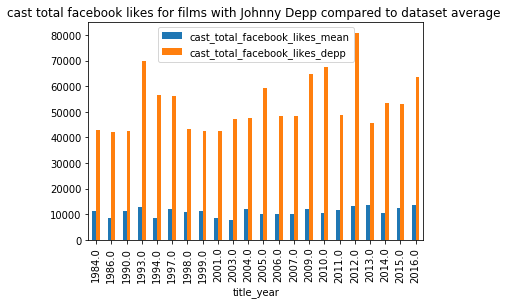

In [123]:
actor_titles_years = actor_films["title_year"]
graph=actor_films["cast_total_facebook_likes"].to_frame()
graph.index=actor_titles_years
graph=graph.groupby(graph.index).mean()
dataj=movie_df[['cast_total_facebook_likes','title_year']]
grouped_by_yearj = dataj.groupby("title_year").cast_total_facebook_likes.mean()
grouped_by_yearj = grouped_by_yearj[grouped_by_yearj.index.isin(actor_films.title_year)]
grouped_by_yearj=grouped_by_yearj.to_frame()
grouped_by_yearj.index=graph.index

grouped_by_yearj.rename(columns={"cast_total_facebook_likes": "cast_total_facebook_likes_mean"}, inplace=True)
grouped_by_yearj['cast_total_facebook_likes_depp']=graph.cast_total_facebook_likes
ax = plt.subplot(111)
grouped_by_yearj.plot(ax=ax,y=["cast_total_facebook_likes_mean",'cast_total_facebook_likes_depp'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"cast total facebook likes for films with {actor} compared to dataset average ")
plt.show()

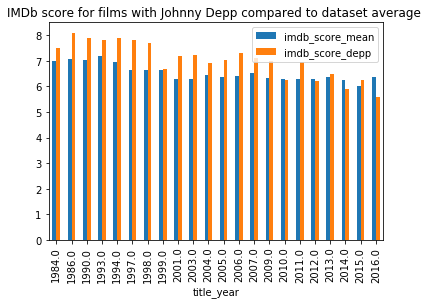

In [124]:
actor_titles_years = actor_films["title_year"]
graph=actor_films["imdb_score"].to_frame()
graph.index=actor_titles_years
graph=graph.groupby(graph.index).mean()
dataj=movie_df[['imdb_score','title_year']]
grouped_by_yearj = dataj.groupby("title_year").imdb_score.mean()
grouped_by_yearj = grouped_by_yearj[grouped_by_yearj.index.isin(actor_films.title_year)]
grouped_by_yearj=grouped_by_yearj.to_frame()
grouped_by_yearj.index=graph.index

grouped_by_yearj.rename(columns={"imdb_score": "imdb_score_mean"}, inplace=True)
grouped_by_yearj['imdb_score_depp']=graph.imdb_score
ax = plt.subplot(111)
grouped_by_yearj.plot(ax=ax,y=["imdb_score_mean",'imdb_score_depp'], kind="bar",legend='ratio')
ax.tick_params(axis='x', rotation=90)

plt.title(f"IMDb score for films with {actor} compared to dataset average ")
plt.show()

# Exploratory Data Analysis (EDA) American Movies  <a name="edaam"></a>


## Drop non ameriacn movies

In [125]:
movieus_df = movie_df[movie_df.country == 'USA'] # keep only usa movies

movieus_df = movieus_df.drop(columns='country') # drop country column

## 1) Univariate Analysis <a name="uni"></a>

### Some high-level observations <a name="high_level"></a>

Firstly, we plot a general description of our data:

In [126]:
movieus_df.describe()

num_critic_for_reviews     duration  director_facebook_likes  \
count             3007.000000  3007.000000              3007.000000   
mean               159.704024   107.800466               882.409046   
std                125.738874    20.897990              3304.721808   
min                  1.000000    14.000000                 0.000000   
25%                 67.500000    94.000000                 9.000000   
50%                131.000000   104.000000                58.000000   
75%                218.000000   118.000000               221.000000   
max                813.000000   330.000000             23000.000000   

       actor_3_facebook_likes  actor_1_facebook_likes         gross  \
count             3007.000000             3007.000000  3.007000e+03   
mean               802.632524             8218.591620  5.485189e+07   
std               1932.069026            17662.518383  7.043770e+07   
min                  0.000000                0.000000  7.030000e+02   
25%                222.500000              786.000000  1.274824e+07   
50%                463.000000             1000.000000  3.025965e+07   
75%                720.000000            13000.000000  7.004730e+07   
max              23000.000000           640000.000000  7.605058e+08   

       num_voted_users  cast_total_facebook_likes  facenumber_in_poster  \
count     3.007000e+03                3007.000000           3007.000000   
mean      1.019530e+05               12202.111407              1.458929   
std       1.544588e+05               21166.496476              2.173349   
min       5.000000e+00                   0.000000              0.000000   
25%       1.504650e+04                2108.000000              0.000000   
50%       4.867500e+04                4378.000000              1.000000   
75%       1.242035e+05               16628.500000              2.000000   
max       1.689764e+06              656730.000000             43.000000   

       num_user_for_reviews  ...  Sci-Fi_Fantasy  Family_Animation  \
count           3007.000000  ...     3007.000000       3007.000000   
mean             314.855005  ...        0.230795          0.122381   
std              405.592324  ...        0.421411          0.327780   
min                1.000000  ...        0.000000          0.000000   
25%               89.500000  ...        0.000000          0.000000   
50%              190.000000  ...        0.000000          0.000000   
75%              382.000000  ...        0.000000          0.000000   
max             4667.000000  ...        1.000000          1.000000   

       Action_Adventure  History_War       Others  director_rank  actor1_rank  \
count       3007.000000  3007.000000  3007.000000    3007.000000  3007.000000   
mean           0.316927     0.043232     0.137679       3.883272     4.165946   
std            0.465356     0.203414     0.344620       1.379928     1.980627   
min            0.000000     0.000000     0.000000       1.000000     0.000000   
25%            0.000000     0.000000     0.000000       3.000000     3.000000   
50%            0.000000     0.000000     0.000000       4.000000     3.000000   
75%            1.000000     0.000000     0.000000       5.000000     6.000000   
max            1.000000     1.000000     1.000000      10.000000    10.000000   

       actor2_rank  actor3_rank  gross_budget_ratio  
count  3007.000000  3007.000000         3007.000000  
mean      3.546059     4.735284           10.340225  
std       1.337241     1.490409          149.520320  
min       0.000000     0.000000            0.000058  
25%       3.000000     4.000000            0.573967  
50%       3.000000     5.000000            1.220670  
75%       4.000000     6.000000            2.500307  
max      10.000000    10.000000         7194.485533  

[8 rows x 31 columns]

### distribution
Distribution of the main numerical features of the data set
Due  the  right-skewed  of  the  distribution  of  budget  andgross earning, it is appropriate to consider the log trasformation of these variables

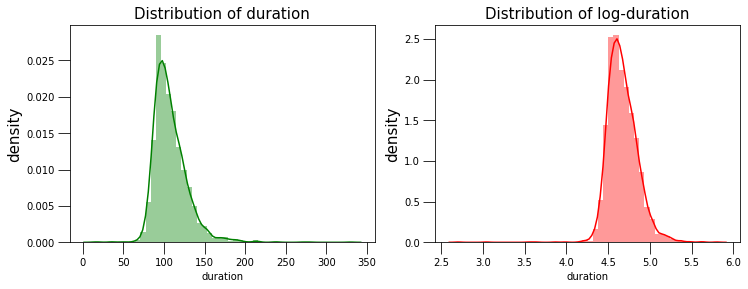

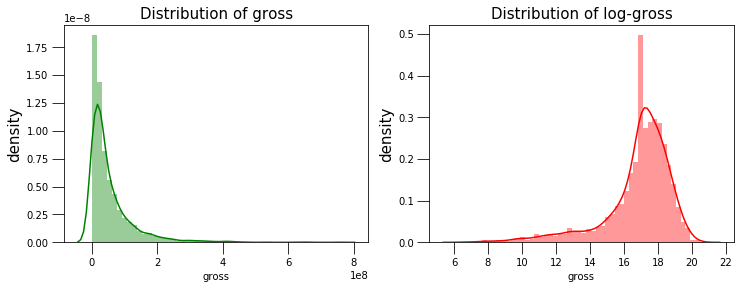

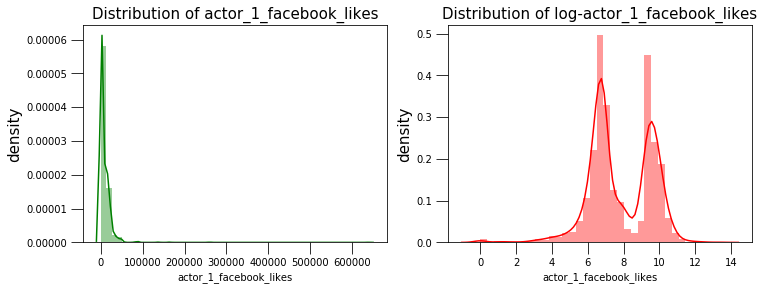

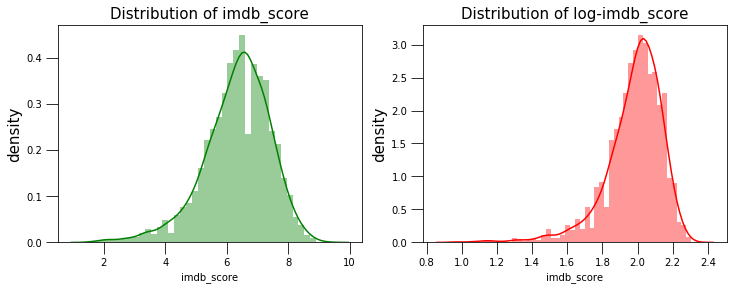

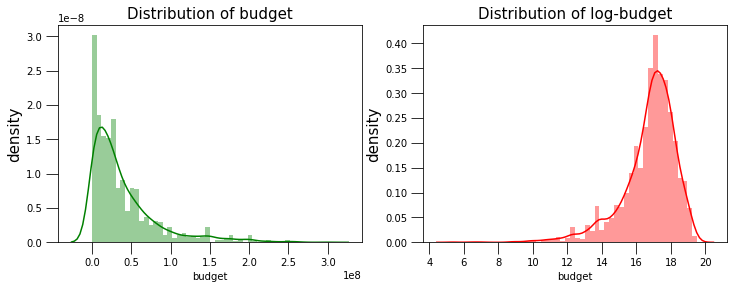

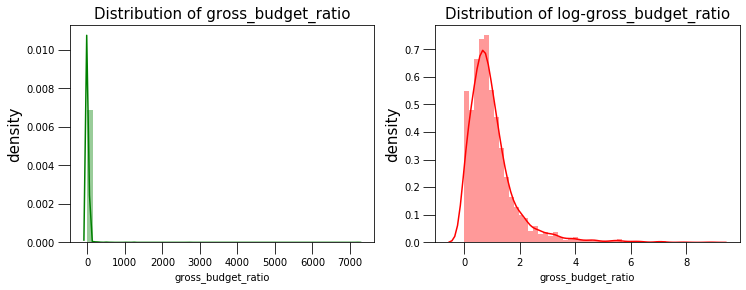

In [127]:
for col in ["duration", "gross", "actor_1_facebook_likes","imdb_score","budget","gross_budget_ratio"]:
    
    _, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
    sns.distplot(movieus_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movieus_df[col].fillna(0) + 1), color="r", ax=ax2)
    
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
        
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

we can see that distribution of budget and gross of movies are not so explanatory. This is due to the fact the the data sets includes both boxoffice movies and documentaries that have a significant difference in marketing and financial needs.
So it might be interesting to look at the number of movies by genre. 


#### Summary statistics of relevant variables

In [128]:
grossde=movieus_df['gross'].describe()
budgetde=movieus_df['budget'].describe()
ratiogb=movieus_df['gross_budget_ratio'].describe()
profitde=(movieus_df['gross']-movieus_df['budget']).describe()
summary = pd.DataFrame([grossde,budgetde,profitde,ratiogb]).T
summary.columns.values[2] = "profits"
summary#summary statistics of relevant variables

gross        budget       profits  gross_budget_ratio
count  3.007000e+03  3.007000e+03  3.007000e+03         3007.000000
mean   5.485189e+07  3.931406e+07  1.553782e+07           10.340225
std    7.043770e+07  4.309575e+07  5.294765e+07          149.520320
min    7.030000e+02  2.180000e+02 -1.906413e+08            0.000058
25%    1.274824e+07  1.000000e+07 -9.132126e+06            0.573967
50%    3.025965e+07  2.500000e+07  4.300302e+06            1.220670
75%    7.004730e+07  5.000000e+07  2.505970e+07            2.500307
max    7.605058e+08  3.000000e+08  5.235058e+08         7194.485533

### Relationship between profitability and IMDB score <a name="prof_imdb"></a>

In [129]:
movies_with_valid_profit = movieus_df[movieus_df.gross_budget_ratio<=20]

### Correlation imdb_score and gross_budget_ratio

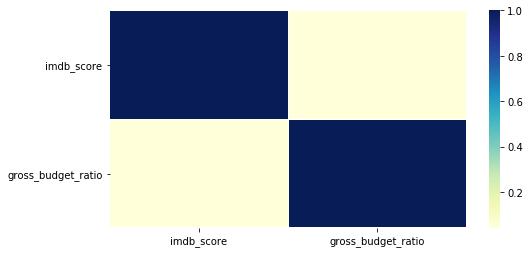

In [130]:
# again, don't see much influence here (between what?)

pivot=movieus_df[['imdb_score',"gross_budget_ratio"]]
pivot=pivot[pivot.gross_budget_ratio<=20]
corp = pivot.apply(lambda x: pd.factorize(x)[0])#scaling 
corp=corp.corr()
plt.figure(figsize=(8, 4))
ax = sns.heatmap(corp, xticklabels=corp.columns, yticklabels=corp.columns, 
                 linewidths=.2, cmap="YlGnBu")
plt.yticks(rotation=0)  
plt.show()

In [131]:
## finction for writing the correlation explicitely in the pairplot
def cor(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 15, xycoords = ax.transAxes)
    

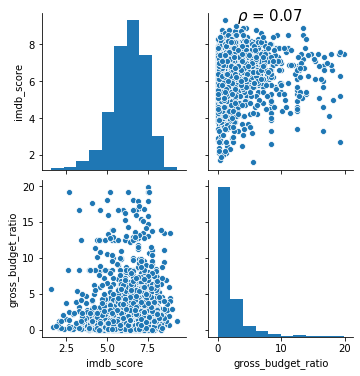

In [132]:
grid=sns.pairplot(data=movieus_df[movieus_df.gross_budget_ratio<=20], vars=["imdb_score", "gross_budget_ratio"])
grid = grid.map_upper(cor)

If we remove the outliers of profitability ratio, we see that to have a profitability ratio higher than 5, a movie must have an IMDb score of 4 and above.

In [133]:
movies_with_imdb_classmean=[]
movies_with_imdb_classmean.append(movieus_df[(1<movieus_df.imdb_score) & (movieus_df.imdb_score<=2.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movieus_df[(2.5<movieus_df.imdb_score) & (movieus_df.imdb_score<=4) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movieus_df[(4<movieus_df.imdb_score) & (movieus_df.imdb_score<=5.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movieus_df[(5.5<movieus_df.imdb_score) & (movieus_df.imdb_score<=7) ].gross_budget_ratio.mean())
movies_with_imdb_classmean.append(movieus_df[(7<movieus_df.imdb_score) & (movieus_df.imdb_score<=8.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movieus_df[(8.5<movieus_df.imdb_score) & (movieus_df.imdb_score<=10) ].gross_budget_ratio.mean()) 

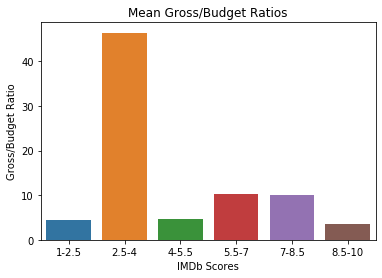

In [134]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean)
plt.xticks(rotation=0)
plt.ylabel("Gross/Budget Ratio")
plt.xlabel('IMDb Scores')
plt.title(f"Mean Gross/Budget Ratios")
plt.show()

In [135]:
movies_with_gb_classmean=[]
movies_with_gb_classmean.append(movieus_df[(0<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=1) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movieus_df[(1<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=2.5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movieus_df[(2.5<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movieus_df[(5<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=10) ].imdb_score.mean())
movies_with_gb_classmean.append(movieus_df[(10<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=20) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movieus_df[(20<movieus_df.gross_budget_ratio)].imdb_score.mean())

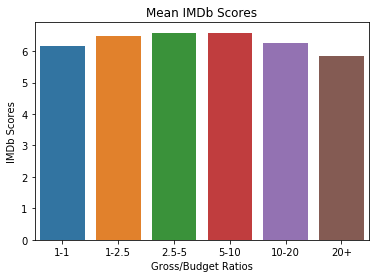

In [136]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean)
plt.xticks(rotation=0)
plt.ylabel("IMDb Scores")
plt.xlabel('Gross/Budget Ratios')
plt.title(f"Mean IMDb Scores")
plt.show()

### Average Gross Budget Ratio For Each Genre <a name="ratio_genre"></a>

In [137]:
gen_df = movieus_df[['gross_budget_ratio','budget', 'gross']] 

movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

gen_df = gen_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

genr = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']
column=['gross_budget_ratio']
prof_gen = pd.DataFrame(index=genr, columns=column)
for gen in genr:
  ab = gen_df.loc[gen_df[gen]==1]
  ab = ab.gross_budget_ratio.mean() 
  prof_gen['gross_budget_ratio'][gen]= ab


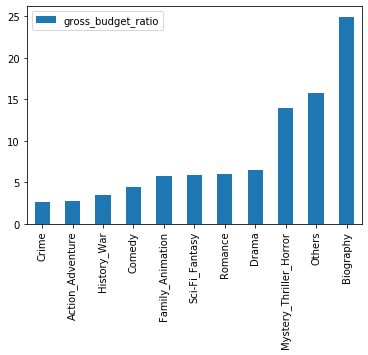

In [138]:
prof_gen=prof_gen.sort_values(by=['gross_budget_ratio'])
prof_gen.plot.bar()

## 3) Multivariate Analysis <a name="multi"></a>

In [139]:
## influnce of Ranks

### Influence of Social Media? <a name="social"></a>


In [140]:
movieus_df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'language', 'content_rating', 'budget',
       'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

In [141]:
datapi=movieus_df[["cast_total_facebook_likes", "movie_facebook_likes", "director_facebook_likes",'imdb_score',"gross_budget_ratio","title_year"]]
datapi=datapi.loc[datapi.title_year>2009]
datapi=datapi.drop("title_year", axis=1)
datapi = datapi.apply(lambda x: pd.factorize(x)[0])
core=datapi.corr()


In [142]:
datara=movie_df[['imdb_score','director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio']]      
#datara = datara.apply(lambda x: pd.factorize(x)[0])
corre=datara.corr()

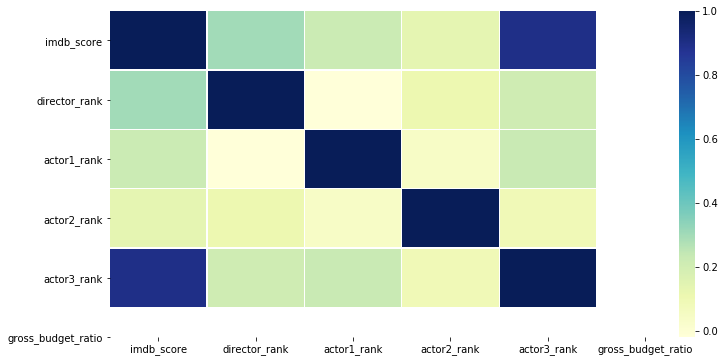

In [143]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(core, xticklabels=corre.columns, yticklabels=corre.columns, 
                 linewidths=.2, cmap="YlGnBu")

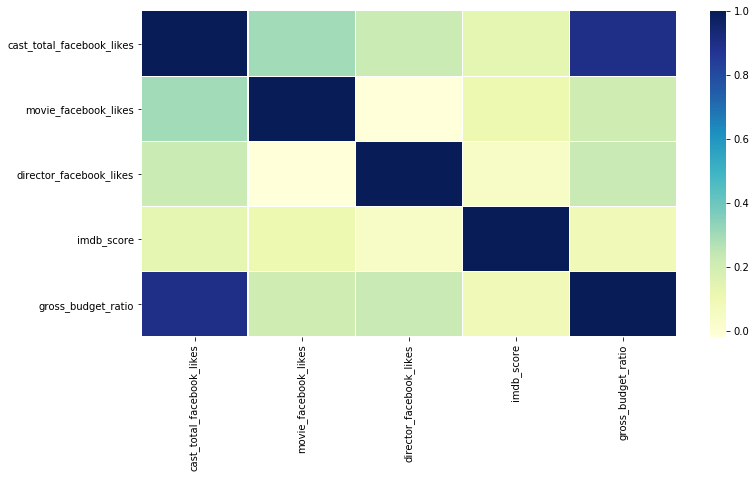

In [144]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(core, xticklabels=core.columns, yticklabels=core.columns, 
                 linewidths=.2, cmap="YlGnBu")

Here, we realize that IMDb score and movie facebook likes might be related. Hence, we analyze these two variables.

In [145]:
movies_with_imdb_classmean2=[]
movies_with_imdb_classmean2.append(datapi[(1<movieus_df.imdb_score) & (movieus_df.imdb_score<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(2.5<movieus_df.imdb_score) & (movieus_df.imdb_score<=4) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(4<movieus_df.imdb_score) & (movieus_df.imdb_score<=5.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(5.5<movieus_df.imdb_score) & (movieus_df.imdb_score<=7) ].cast_total_facebook_likes.mean())
movies_with_imdb_classmean2.append(datapi[(7<movieus_df.imdb_score) & (movieus_df.imdb_score<=8.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(8.5<movieus_df.imdb_score) & (movieus_df.imdb_score<=10) ].cast_total_facebook_likes.mean()) 

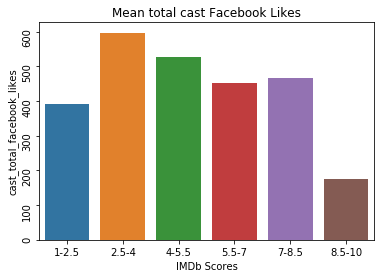

In [146]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast_total_facebook_likes")
plt.xlabel('IMDb Scores')
plt.title(f"Mean total cast Facebook Likes")
plt.yticks(rotation=90)
plt.show()

In [147]:
movies_with_gb_classmean2=[]
movies_with_gb_classmean2.append(datapi[(0<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=1) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(1<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(2.5<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(5<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=10) ].cast_total_facebook_likes.mean())
movies_with_gb_classmean2.append(datapi[(10<movieus_df.gross_budget_ratio) & (movieus_df.gross_budget_ratio<=20) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(20<movieus_df.gross_budget_ratio)].cast_total_facebook_likes.mean())

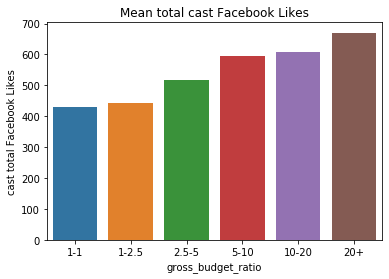

In [148]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast total Facebook Likes")
plt.xlabel('gross_budget_ratio')
plt.title(f"Mean total cast Facebook Likes")
plt.show()


Here, we see that at the top 4 places all combinations have more than 140 movies. Hence, we can comment more confidently. We see that all of the for segments include Drama in it and all of them has gross/budget ratio of 2 which is a nice number for film makers. By looking at the data, we can say that:
1. Drama + Others ~ 1.7
2. Drama + Comedy + Romance ~2.4
3. Drama Only ~ 1.8
4. Drama + Comedy ~2

Hence, it might be logical to make a drama movie with some comedy and romance in it.

### Let's look at films from a prominent director  <a name="prominent_director"></a>

cambia il titolo e fai una mini spiegazione introduttiva di cosa fai in questa sezione

In [149]:
director = "Christopher Nolan" # change this variable if you want to look into another director
director_films = movieus_df.query(f"director_name == '{director}'").sort_values(by="title_year")
director_films.columns
genres_col={'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others'}

Guys there is a function which do the one hot encoding :)

In [150]:
##using genres_col
sums=director_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(director_films.title_year.value_counts())
print("\n")

Genres' counter

Group  Sci-Fi_Fantasy = 3
Group  Family_Animation = 0
Group  Others = 0
Group  Romance = 0
Group  Crime = 1
Group  Drama = 4
Group  Mystery_Thriller_Horror = 6
Group  Action_Adventure = 5
Group  History_War = 0
Group  Comedy = 0
Group  Biography = 0


Number of films per year 

2014.0    1
2012.0    1
2010.0    1
2008.0    1
2006.0    1
2005.0    1
2002.0    1
2000.0    1
Name: title_year, dtype: int64




### Gross budget levels overtime

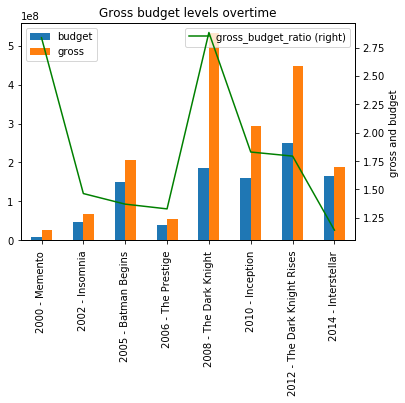

In [151]:
director_titles_years = director_films["title_year"].map(int).map(str) + " - " + director_films["movie_title"].map(str)  
graph=director_films["budget"].to_frame()
graph['gross_budget_ratio']=director_films["gross_budget_ratio"]
graph['gross']=director_films["gross"]
graph.index=director_titles_years

ax = plt.subplot(111)
ax2= ax.twinx()
graph.gross_budget_ratio.plot(ax=ax2, style='g-', secondary_y=True, legend='ratio')
plt.ylabel("gross-budget ratio")
graph.plot(ax=ax,y=["budget", "gross"], kind="bar")
plt.ylabel("gross and budget ")
ax.tick_params(axis='x', rotation=90)
leg = ax.get_legend()
leg.remove()        # remove it from ax
ax2.add_artist(leg) # add it to ax2
leg._set_loc(2)
plt.title("Gross budget levels overtime")
plt.show()

## trends overtime of budget and gross in absulute figures


### Gross-budget ratio for films of our porminient director

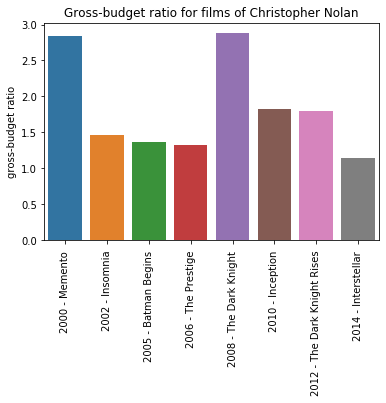

In [152]:
sns.barplot(director_titles_years, director_films["gross_budget_ratio"])
plt.xticks(rotation=90)
plt.ylabel("gross-budget ratio")
plt.title(f"Gross-budget ratio for films of {director}")
plt.show()

### cast total facebook likes for films of our porminient director

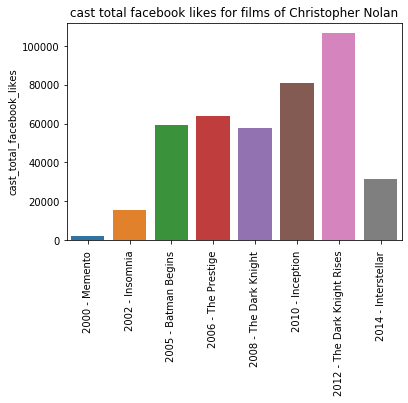

In [153]:
sns.barplot(director_titles_years, director_films.cast_total_facebook_likes)
plt.xticks(rotation=90)
plt.ylabel("cast_total_facebook_likes")
plt.title(f"cast total facebook likes for films of {director}")
plt.show()

### IMDB Score for films of our porminient director

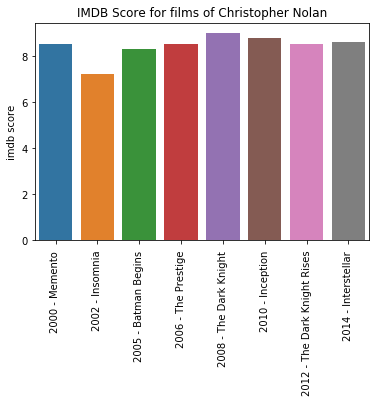

In [154]:
sns.barplot(director_titles_years, director_films.imdb_score)
plt.xticks(rotation=90)
plt.ylabel("imdb score")
plt.title(f"IMDB Score for films of {director}")
plt.show()

## 3) Keyword Analysis <a name="keys"></a>

Considering all movies

### Average Gross Budget Ratio For Each Genre <a name="ratio_genre"></a>

In [156]:
gen_df = movie_df[['gross_budget_ratio','budget', 'gross']] 

movie_genre_df = movie_df[['Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
                           'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']]

column=['gross_budget_ratio']

gen_df = gen_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

genr = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']
column=['gross_budget_ratio']
prof_gen = pd.DataFrame(index=genr, columns=column)
for gen in genr:
  ab = gen_df.loc[gen_df[gen]==1]
  ab = ab.gross_budget_ratio.mean() 
  prof_gen['gross_budget_ratio'][gen]= ab


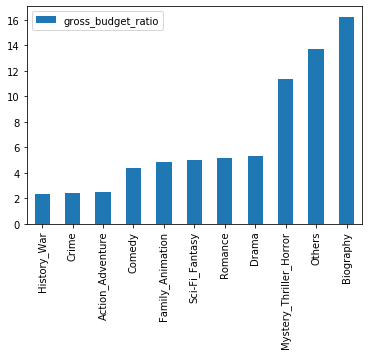

In [157]:
prof_gen=prof_gen.sort_values(by=['gross_budget_ratio'])
prof_gen.plot.bar()

In [158]:
# words_df is a ataframe which contains what we need for the keyword analysis
words_df =[]
words_df = movie_df[['plot_keywords','budget', 'gross']] 

# a list with all the plot keywords for each movie
words = words_df.plot_keywords
words = [x.split("|") for x in words]


for i in range(len(words_df.plot_keywords)): # for each movie
    
    words[i] = [x.split() for x in words[i]] # splitted words of that movie 
    w = []
    
    # delete sub list in order to have one list for each movie and one one list for each word for each movie
    for j in range(len(words[i])):
        for k in range(len(words[i][j])):
            if len(words[i][j][k])>2 and ' ' not in words[i][j][k]:
                w.append(words[i][j][k])
    
    words[i] = w
    
    # delete duplicates
    words[i] = list(OrderedDict.fromkeys(words[i])) 

In [159]:
words_df.plot_keywords = words
words_df.head()

plot_keywords       budget  \
imdb_id                                                                     
tt0035423  [bridge, brooklyn, falling, down, elevator, sh...  48000000.00   
tt0080487  [caddy, country, club, golf, course, gopher, n...   6000000.00   
tt0080549  [country, music, kissing, while, having, sex, ...  48671729.12   
tt0080661  [apartment, elevator, murder, psychiatrist, su...   6500000.00   
tt0080678  [curiosity, exploitation, freak, hospital, phy...   5000000.00   

                gross  
imdb_id                
tt0035423  47095453.0  
tt0080487  39800000.0  
tt0080549  79900000.0  
tt0080661  31899000.0  
tt0080678  26010864.0

In [160]:
# we need the genre of each movie

movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

words_df = words_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

words_df.head()

plot_keywords       budget  \
imdb_id                                                                     
tt0035423  [bridge, brooklyn, falling, down, elevator, sh...  48000000.00   
tt0080487  [caddy, country, club, golf, course, gopher, n...   6000000.00   
tt0080549  [country, music, kissing, while, having, sex, ...  48671729.12   
tt0080661  [apartment, elevator, murder, psychiatrist, su...   6500000.00   
tt0080678  [curiosity, exploitation, freak, hospital, phy...   5000000.00   

                gross  Biography  Comedy  Crime  Drama  Romance  \
imdb_id                                                           
tt0035423  47095453.0          0       1      0      0        1   
tt0080487  39800000.0          0       1      0      0        0   
tt0080549  79900000.0          1       0      0      1        0   
tt0080661  31899000.0          0       0      0      0        1   
tt0080678  26010864.0          1       0      0      1        0   

           Mystery_Thriller_Horror  Sci-Fi_Fantasy  Family_Animation  \
imdb_id                                                                
tt0035423                        0               1                 0   
tt0080487                        0               0                 0   
tt0080549                        0               0                 0   
tt0080661                        1               0                 0   
tt0080678                        0               0                 0   

           Action_Adventure  History_War  Others  
imdb_id                                           
tt0035423                 0            0       0  
tt0080487                 0            0       1  
tt0080549                 0            0       1  
tt0080661                 0            0       0  
tt0080678                 0            0       0

### Relation between keywords, Budget, Gross and profitability <a name="rel_keys"></a>

In [161]:
genres = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']

for genre in genres: # for each genre
    
    print(color.BOLD + genre + color.END +":")
    print('\n')
    
    column = words_df[genre]
    
    words_genre_df = words_df[column==1]
    
    words_genre = []
    
    num_film_word = [0]*len(words_genre_df) # num of movies of that genre in which that word appears
    
    # delete sub list
    for j in range(len(words_genre_df)):
        for k in range(len(words_genre_df.plot_keywords[j])):
            if len(words_genre_df.plot_keywords[j][k])>2 and ' ' not in words_genre_df.plot_keywords[j][k]:
                words_genre.append(words_genre_df.plot_keywords[j][k])
                
    
    # list of all words of this genre:
    words_genre = list(dict.fromkeys(words_genre)) 
    
    budget_word = [0] * len(words_genre)
    gross_word = [0] * len(words_genre)
    num_film_word = [0] * len(words_genre)
    
    #for each word of that genre see the mean budget and mean gross of all movies of that genre which contain this word:
    
    for i in range(len(words_genre)):
        word = words_genre[i]
        budget_word[i] = 0
        gross_word[i] = 0
        
        
        for j in range(len(words_genre_df)): # for  all films of that genre
            
            words_movie = words_genre_df.plot_keywords[j]
            
            
            if word in words_movie:
                num_film_word[i] = num_film_word[i] + 1
                budget_word[i] = budget_word[i] + words_genre_df.budget[j]
                gross_word[i] = gross_word[i] + words_genre_df.gross[j]
        
        if num_film_word[i] > 2: # no if zero (not find) or an exception (only one/two)
            
            # compute the means:
            budget_word[i] = budget_word[i]/num_film_word[i]
            gross_word[i] = gross_word[i]/num_film_word[i]
            
        else: 
            words_genre[i] = 0

    #words_genre = [i for i in words_genre if i != 0]
        
    
    # create a dataframe for each genre
    word_budget_df = pd.DataFrame([words_genre,budget_word, gross_word, num_film_word]).T
    word_budget_df = word_budget_df.rename(columns={0:"word", 1:"mean_budget", 2:"mean_gross", 3:"num_film_word"})
    word_budget_df = word_budget_df[word_budget_df.word != 0]
    word_budget_df = word_budget_df[word_budget_df.num_film_word >3] # only words which appear in more than 3 movies
    word_budget_df = word_budget_df.set_index('word')
    word_budget_df["gross_budget_ratio"] = word_budget_df.mean_gross / word_budget_df.mean_budget
    
    # print results
    print("Order by budget:")
    display(word_budget_df.sort_values('mean_budget', ascending=False)[['mean_budget', 'num_film_word']].T.head(10)) #order by budget
    print("\n")
    print("Order by gross:")
    display(word_budget_df.sort_values('mean_gross', ascending=False)[['mean_gross', 'num_film_word']].T.head(10)) #order by budget
    print("\n")
    print("Order by ratio:")
    display(word_budget_df.sort_values('gross_budget_ratio', ascending=False)[['gross_budget_ratio', 'num_film_word']].T.head(10)) #order by budget
    print("\n")
    

Biography:


Order by budget:


word               king    boxing          fbi     boxer protagonist  \
mean_budget    5.35e+07  5.25e+07  4.87143e+07  4.75e+07  4.7432e+07   
num_film_word         4         6            7         4           5   

word                 u.s.    president      african          the   politics  \
mean_budget    4.4875e+07  4.43333e+07  4.42857e+07  4.34453e+07  3.825e+07   
num_film_word           4            6            7            6          4   

word           ...     friend         girl      musical  friendship minister  \
mean_budget    ...  1.561e+07  1.52602e+07  1.46621e+07  1.4059e+07  1.4e+07   
num_film_word  ...          6            5            4           8        4   

word                 19th          gay  character    drugs    artist  
mean_budget    1.3725e+07  1.27222e+07  1.045e+07  6.6e+06  6.48e+06  
num_film_word           4            9          6        4         5  

[2 rows x 82 columns]



Order by gross:


word                u.s.        death         high      concert     politics  \
mean_gross     9.767e+07  9.21668e+07  8.45289e+07  8.04286e+07  7.85562e+07   
num_film_word          4            7            6            4            4   

word                racism       school       rights        star    president  \
mean_gross     6.89475e+07  6.51011e+07  6.21763e+07  6.1828e+07  6.17316e+07   
num_film_word            4            8            4           5            6   

word           ...         19th      frontal       murder        court  \
mean_gross     ...  1.16591e+07  1.13848e+07  1.13329e+07  1.12397e+07   
num_film_word  ...            4            6            5            4   

word                artist        movie         york       friend         new  \
mean_gross     1.06155e+07  7.84279e+06  6.99474e+06  6.97758e+06  6.1868e+06   
num_film_word            5            5            4            6           5   

word                  girl  
mean_gross     5.42915e+06  
num_film_word            5  

[2 rows x 82 columns]



Order by ratio:


word                   high  concert character    death   mother   school  \
gross_budget_ratio  3.33667  3.07858    2.6856  2.58274  2.57069  2.46829   
num_film_word             6        4         6        7        5        8   

word                 rights     star     u.s.    music  ...  violence  \
gross_budget_ratio  2.41461  2.33207  2.17649  2.12248  ...  0.609974   
num_film_word             4        5        4        5  ...         5   

word                 murder      the    friend  frontal     movie     court  \
gross_budget_ratio  0.53457  0.51174  0.446994  0.43614  0.424392  0.410028   
num_film_word             5        6         6        6         5         4   

word                    girl       new      york  
gross_budget_ratio  0.355773  0.281216  0.277017  
num_film_word              5         5         4  

[2 rows x 82 columns]



Comedy:


Order by budget:


word                 river      monster     daughter    invasion         tale  \
mean_budget    3.11025e+09  7.18258e+08  6.24263e+08  1.1825e+08  1.13714e+08   
num_film_word            4           18           21           4            7   

word              fairy   inventor      egg      panda       disney  ...  \
mean_budget    1.13e+08  1.126e+08  1.1e+08  1.075e+08  1.03333e+08  ...   
num_film_word         7          5        4          4            6  ...   

word            immigrant independent   topless  diner jersey       shower  \
mean_budget    8.2125e+06     7.7e+06  7.48e+06  7e+06  7e+06  6.09417e+06   
num_film_word           4           5         5      5      5            6   

word              dead      hockey         fast  mormon  
mean_budget    5.7e+06  5.2075e+06  4.89125e+06  613250  
num_film_word        4           4            4       4  

[2 rows x 674 columns]



Order by gross:


word                 fairy         tale       memory          toy  \
mean_gross     1.77695e+08  1.77421e+08  1.55385e+08  1.51617e+08   
num_film_word            7            7            6           11   

word                 panda     chipmunk          pet         snow  \
mean_gross     1.47104e+08  1.42335e+08  1.35694e+08  1.33224e+08   
num_film_word            4            5            5            6   

word                 queen        tough  ...         coma      writing  \
mean_gross     1.29899e+08  1.29832e+08  ...  9.26234e+06  9.18188e+06   
num_film_word            8            4  ...            6            4   

word               therapy      private        diner       mormon     suicide  \
mean_gross     8.66262e+06  8.52232e+06  7.86678e+06  6.91396e+06  6.1616e+06   
num_film_word            4            6            5            4           6   

word               protest       irish   motel  
mean_gross     5.13218e+06  4.3235e+06  324951  
num_film_word            4           4       4  

[2 rows x 674 columns]



Order by ratio:


word                 mormon    drink    greek shootout stripper  topless  \
gross_budget_ratio  11.2743  6.33362  5.97032  5.45877  5.36884  4.45395   
num_film_word             4        5        4        4        7        5   

word                   prom alcoholic   hockey   jewish  ...       con  \
gross_budget_ratio  4.25827   4.14783  3.92495  3.89884  ...  0.430343   
num_film_word             7         8        4        7  ...         5   

word                 writing  protest      coma     irish    knight  daughter  \
gross_budget_ratio  0.423754  0.38954  0.358542  0.335806  0.292565  0.090183   
num_film_word              4        4         6         4         6        21   

word                  monster      motel      river  
gross_budget_ratio  0.0884982  0.0335016  0.0166813  
num_film_word              18          4          4  

[2 rows x 674 columns]



Crime:


Order by budget:


word               lesbian          sex    triad       book      star  \
mean_budget    7.16333e+08  1.52062e+08  8.6e+07  7.625e+07  7.29e+07   
num_film_word            6           33        5          4         7   

word                run     kung     racing   ransom   computer  ...  \
mean_budget    7.12e+07  6.9e+07  6.625e+07  6.3e+07  6.125e+07  ...   
num_film_word        10        5          4        4          8  ...   

word                  game        son         slum       friend    killed  \
mean_budget    1.51958e+07  1.484e+07  1.47429e+07  1.47094e+07  1.28e+07   
num_film_word            4          5            4           26         5   

word               twins     squad       irish        video      pimp  
mean_budget    1.265e+07  1.25e+07  1.0325e+07  7.45666e+06  6.25e+06  
num_film_word          4         4           4            5         4  

[2 rows x 306 columns]



Order by gross:


word            psychopath         book        star        triad     hospital  \
mean_gross     1.51451e+08  1.50853e+08  1.3524e+08  1.05646e+08  1.03782e+08   
num_film_word            5            4           7            5            8   

word                   spy    falling          off       racing    terrorist  \
mean_gross     1.02117e+08  9.949e+07  9.63827e+07  9.44149e+07  9.18469e+07   
num_film_word            7          5            5            4            6   

word           ...         flop      lesbian        video        best  \
mean_gross     ...  1.17836e+07  1.16689e+07  1.15538e+07  1.0289e+07   
num_film_word  ...            4            6            5           4   

word                deputy         thug        squad        actor  \
mean_gross     9.73271e+06  9.37978e+06  9.03857e+06  8.08785e+06   
num_film_word            4            4            4            4   

word                  slum   friendship  
mean_gross     2.62351e+06  2.00717e+06  
num_film_word            4            9  

[2 rows x 306 columns]



Order by ratio:


word               shootout   tattoo psychopath  college  suspect    twins  \
gross_budget_ratio   3.4765  3.33342    2.83404  2.73856  2.68783  2.53158   
num_film_word             9        5          5        4        4        4   

word                 leader     time  travel     jail  ... nightclub  \
gross_budget_ratio  2.46352  2.42385  2.4163  2.39462  ...  0.435152   
num_film_word             4        4       4        4  ...         4   

word                     die      hard  scenario    deputy      thug  \
gross_budget_ratio  0.376307  0.376307  0.376307  0.338529  0.250676   
num_film_word              8         8         8         4         4   

word                    slum       sex friendship    lesbian  
gross_budget_ratio  0.177951  0.128316   0.100863  0.0162897  
num_film_word              4        33          9          6  

[2 rows x 306 columns]



Drama:


Order by budget:


word                 river       oral     pregnant     daughter         slur  \
mean_budget    1.53375e+09  8.427e+08  7.18991e+08  4.45443e+08  3.86429e+08   
num_film_word            8          5            6           29            7   

word                   bus    christian       jewish      lesbian     casino  \
mean_budget    3.75343e+08  2.42868e+08  2.39924e+08  2.31562e+08  1.735e+08   
num_film_word            7           18           11           19          4   

word           ...     drinking    looking supermarket  therapy      member  \
mean_budget    ...  7.68375e+06  7.625e+06   7.575e+06  7.3e+06  6.5535e+06   
num_film_word  ...            8          4           4        5           6   

word               pimp   hustler       mormon     toilet independent  
mean_budget    6.25e+06  5.95e+06  3.89167e+06  2.775e+06      897066  
num_film_word         4         4            6          4           6  

[2 rows x 862 columns]



Order by gross:


word                  ring         epic      setting        earth  \
mean_gross     1.72922e+08  1.56343e+08  1.53772e+08  1.48001e+08   
num_film_word            6            7            4            5   

word                 space      vampire       middle    werewolf         king  \
mean_gross     1.42776e+08  1.29284e+08  1.29266e+08  1.2463e+08  1.17385e+08   
num_film_word            7           10            6           6           14   

word                sniper  ...     stranger autobiography          day  \
mean_gross     1.16448e+08  ...  6.44821e+06   6.16221e+06  5.11259e+06   
num_film_word            4  ...            4             4            4   

word                 motel   orphanage        fence   resistance       mormon  \
mean_gross     4.40648e+06  3.8066e+06  3.80517e+06  3.35278e+06  2.16029e+06   
num_film_word            6           4            4            4            6   

word                brazil      looking  
mean_gross     1.58867e+06  1.15362e+06  
num_film_word            4            4  

[2 rows x 862 columns]



Order by ratio:


word               independent   toilet    uncle unrequited mississippi  \
gross_budget_ratio     11.3073  6.14834  4.79498     4.5094      4.4002   
num_film_word                6        4        5          4           4   

word                psychic homosexuality      hop      hip   ballet  ...  \
gross_budget_ratio  4.26803       4.00307  3.92504  3.92504  3.78198  ...   
num_film_word             4             4        6        6        5  ...   

word                  jewish   chinese       slur        bus  christian  \
gross_budget_ratio  0.114328  0.105285  0.0949724  0.0827007  0.0764946   
num_film_word             11         8          7          7         18   

word                 daughter    lesbian   pregnant       oral      river  
gross_budget_ratio  0.0689442  0.0531358  0.0249286  0.0155874  0.0107804  
num_film_word              29         19          6          5          8  

[2 rows x 862 columns]



Romance:


Order by budget:


word                   gay        death        fairy      tale      suicide  \
mean_budget    1.29134e+08  1.10508e+08  9.95714e+07  9.64e+07  8.60215e+07   
num_film_word           21           32            7         5            8   

word             scientist      fbi        king  professor japanese  ...  \
mean_budget    7.95575e+07  7.9e+07  7.7744e+07  6.925e+07  6.8e+07  ...   
num_film_word            7        5          15          4        5  ...   

word                 irish     german        home  immigrant         true  \
mean_budget    1.15972e+07  1.096e+07  1.0513e+07  8.136e+06  8.00625e+06   
num_film_word            6          5           5          5            4   

word            therapy manhattan       shower      drugs    claim  
mean_budget    7.75e+06  6.25e+06  5.50929e+06  5.419e+06  3.1e+06  
num_film_word         4         5            7          6        4  

[2 rows x 357 columns]



Order by gross:


word               vampire     werewolf        fairy         evil  \
mean_gross     1.69046e+08  1.66421e+08  1.27221e+08  1.25841e+08   
num_film_word            7            4            7            4   

word                  tale    physical     princess        nurse          law  \
mean_gross     1.25245e+08  1.2279e+08  1.15941e+08  1.07455e+08  1.00831e+08   
num_film_word            5           4            9            6            5   

word               talking  ...      painter         land     multiple  \
mean_gross     1.00363e+08  ...  8.83082e+06  8.09185e+06  7.47741e+06   
num_film_word            4  ...            4            4            4   

word             manhattan        india   depression          ice  \
mean_gross     7.34701e+06  7.19127e+06  7.11683e+06  6.82428e+06   
num_film_word            5            9            5            4   

word             voyeurism      therapy         pool  
mean_gross     6.50828e+06  6.12558e+06  5.99961e+06  
num_film_word            4            4            4  

[2 rows x 357 columns]



Order by ratio:


word                 claim      hop      hip     cast restaurant pregnancy  \
gross_budget_ratio  4.9905  4.14088  4.14088  3.87011    3.79037   3.72286   
num_film_word            4        4        4        4         11         5   

word                    out     bare prostitute  vampire  ...  novelist  \
gross_budget_ratio  3.47053  3.43806    3.39664  3.37128  ...  0.362283   
num_film_word             5        5          5        7  ...         4   

word                   death       ice     india depression  computer  \
gross_budget_ratio  0.358588  0.356825  0.351651   0.325134  0.313675   
num_film_word             32         4         9          5         4   

word                    pool      land       gay   suicide  
gross_budget_ratio  0.298741  0.264959  0.248123  0.132447  
num_film_word              4         4        21         8  

[2 rows x 357 columns]



Mystery_Thriller_Horror:


Order by budget:


word                 river     daughter      monster     century      tragic  \
mean_budget    2.05267e+09  9.01968e+08  7.08109e+08  3.8267e+08  1.4926e+08   
num_film_word            6           14           18           6           5   

word                event    espionage       casino     wizard          boy  \
mean_budget    1.2968e+08  1.24583e+08  1.23111e+08  1.225e+08  1.11533e+08   
num_film_word           5            6            9          4           27   

word           ...    witch      oral     trip      footage invasion  \
mean_budget    ...  7.5e+06  7.25e+06  7.2e+06  7.09227e+06  6.7e+06   
num_film_word  ...        4         4        6           11        4   

word           homosexual   voyeurism    nonlinear     timeline independent  
mean_budget    5.9375e+06  3.8125e+06  2.80175e+06  2.80175e+06      923732  
num_film_word           4           4            4            4           6  

[2 rows x 615 columns]



Order by gross:


word                wizard         park     disaster        magic  \
mean_gross     2.08972e+08  2.01007e+08  1.71289e+08  1.59996e+08   
num_film_word            4            8            8            7   

word               village      attempt      setting    espionage  \
mean_gross     1.59762e+08  1.56027e+08  1.54464e+08  1.44007e+08   
num_film_word            9            4            4            6   

word                 comic         tour  ...        tower  trafficking  \
mean_gross     1.43137e+08  1.35216e+08  ...  1.06546e+07  1.05703e+07   
num_film_word            5            4  ...            4            4   

word                  best  friendship       double         hair        pubic  \
mean_gross     9.98809e+06  9.7057e+06  9.09479e+06  7.89877e+06  7.89877e+06   
num_film_word            4          10            4           10           10   

word            homosexual     timeline    nonlinear  
mean_gross     7.76091e+06  2.23102e+06  2.23102e+06  
num_film_word            4            4            4  

[2 rows x 615 columns]



Order by ratio:


word               independent  footage    found  torture voyeurism      and  \
gross_budget_ratio     13.6117  6.57211  5.56791  5.40215   4.91907  4.86706   
num_film_word                6       11       12        5         4       18   

word               paranormal  village   freddy  krueger  ...     down  \
gross_budget_ratio    4.53312  4.43563  4.30646  4.30646  ...  0.36235   
num_film_word              10        9        5        5  ...        5   

word                    flop       boy   tragic    double     event  \
gross_budget_ratio  0.324657  0.303367  0.29282  0.226419  0.101519   
num_film_word              8        27        5         4         5   

word                  century    monster  daughter      river  
gross_budget_ratio  0.0983789  0.0687594  0.040983  0.0153006  
num_film_word               6         18        14          6  

[2 rows x 615 columns]



Sci-Fi_Fantasy:


Order by budget:


word              daughter      monster        ball     inventor       forest  \
mean_budget    1.45128e+09  6.25698e+08  5.9063e+08  4.10074e+08  3.72929e+08   
num_film_word            9           22           4            7            7   

word              century     princess         gang cinematic     science  \
mean_budget    2.5332e+08  2.39071e+08  2.11667e+08     2e+08  1.9188e+08   
num_film_word          11           17            6         4           7   

word           ...      paris    radio       leg       trip     found  \
mean_budget    ...  1.775e+07  1.5e+07  1.43e+07  1.367e+07  1.32e+07   
num_film_word  ...          4        4         4          5         5   

word            footage   psychic     breasts        light kidnapping  
mean_budget    1.32e+07  1.25e+07  1.0512e+07  1.03412e+07   8.13e+06  
num_film_word         5         5           5            4          4  

[2 rows x 393 columns]



Order by gross:


word            jurassic     language    cinematic     dinosaur      village  \
mean_gross     3.548e+08  3.44413e+08  2.95431e+08  2.65277e+08  2.64809e+08   
num_film_word          4            5            4            6            6   

word                marvel         park       wizard          orc  \
mean_gross     2.62855e+08  2.59883e+08  2.56704e+08  2.45527e+08   
num_film_word            5            6            7            4   

word                marine  ...      martian      knight         near  \
mean_gross     2.38565e+08  ...  2.60995e+07  2.5694e+07  2.27206e+07   
num_film_word            4  ...            4           6            6   

word                  gang     vomiting      breasts       system       trip  \
mean_gross     2.23404e+07  1.94554e+07  1.90707e+07  1.80097e+07  1.674e+07   
num_film_word            6            7            5            6          5   

word                 radio     genetics  
mean_gross     1.43127e+07  1.19937e+07  
num_film_word            4            4  

[2 rows x 393 columns]



Order by ratio:


word                  light     doll language  suicide  village kidnapping  \
gross_budget_ratio  4.42995  4.26654  4.20016  4.02721  3.90229    3.75051   
num_film_word             4        5        5        4        6          4   

word               jurassic     park  footage    found  ...   martian  \
gross_budget_ratio   3.7446  3.46049  3.27747  3.27747  ...  0.333541   
num_film_word             4        6        5        5  ...         4   

word                    flop inventor   century   science   monster    forest  \
gross_budget_ratio  0.311386  0.28341  0.209925  0.174177  0.167401  0.112463   
num_film_word             16        7        11         7        22         7   

word                    gang       ball   daughter  
gross_budget_ratio  0.105545  0.0966438  0.0729493  
num_film_word              6          4          9  

[2 rows x 393 columns]



Family_Animation:


Order by budget:


word                anime    inventor         cult       forest      century  \
mean_budget    6.4075e+08  6.3513e+08  5.14307e+08  4.48583e+08  4.32503e+08   
num_film_word           4           4            5            6            6   

word              science         film     princess        child    potion  \
mean_budget    2.9425e+08  2.56832e+08  2.48714e+08  1.98857e+08  1.67e+08   
num_film_word           4           10           14            7         4   

word           ...         old       three surrealism   florida     france  \
mean_budget    ...  2.5932e+07  2.5665e+07  2.425e+07  2.34e+07  2.292e+07   
num_film_word  ...           5           4          4         5          5   

word               bully    summer       rabbit    coach basketball  
mean_budget    2.075e+07  1.92e+07  1.80083e+07  1.7e+07  1.104e+07  
num_film_word          4         5            4        5          5  

[2 rows x 191 columns]



Order by gross:


word                wizard         snow       flying       potion  \
mean_gross     2.87228e+08  2.06557e+08  1.95608e+08  1.92286e+08   
num_film_word            4            5            4            4   

word                  fire        queen         tale       sister  \
mean_gross     1.85888e+08  1.78432e+08  1.76031e+08  1.70011e+08   
num_film_word            5            8            8            4   

word                 fairy       magic  ...  punctuation       rabbit  \
mean_gross     1.65226e+08  1.6235e+08  ...  2.37275e+07  2.36937e+07   
num_film_word           10          15  ...            4            4   

word                comedy     computer       train      science       anime  \
mean_gross     2.35944e+07  2.27166e+07  2.2299e+07  1.79946e+07  1.5247e+07   
num_film_word            4            5           5            4           4   

word                 three         flop   critically  
mean_gross     1.30061e+07  5.54125e+06  4.22713e+06  
num_film_word            4            6            4  

[2 rows x 191 columns]



Order by ratio:


word               basketball      bad restaurant protagonist   male  florida  \
gross_budget_ratio    3.92436  3.86058    3.58416     3.41303  3.211  3.11072   
num_film_word               5        4          5           4      5        5   

word                    gun    coach    novel    shark  ...     train  \
gross_budget_ratio  3.04365  2.93782  2.85474  2.83722  ...  0.272604   
num_film_word             4        5        4        4  ...         5   

word                 century    forest      flop  inventor     film  \
gross_budget_ratio  0.181847  0.136691  0.135704  0.127977  0.12186   
num_film_word              6         6         6         4       10   

word               critically       cult   science      anime  
gross_budget_ratio   0.120132  0.0739943  0.061154  0.0237955  
num_film_word               4          5         4          4  

[2 rows x 191 columns]



Action_Adventure:


Order by budget:


word                anime        ball    inventor         19th       forest  \
mean_budget    6.4075e+08  5.6913e+08  4.8042e+08  4.71784e+08  2.99109e+08   
num_film_word           4           4           6            5            9   

word                 biker     princess      century universe cinematic  ...  \
mean_budget    2.44734e+08  2.24774e+08  2.04495e+08    2e+08     2e+08  ...   
num_film_word            5           19           17        4         4  ...   

word               held       comedy    shootout gunpoint         gay  \
mean_budget    1.76e+07  1.73333e+07  1.7166e+07  1.7e+07  1.5875e+07   
num_film_word         5            6          10        4           4   

word               camp     machete  cigarette      kiss     satire  
mean_budget    1.54e+07  1.2625e+07  1.215e+07  9.95e+06  7.125e+06  
num_film_word         5           4          4         4          4  

[2 rows x 566 columns]



Order by gross:


word            jurassic     language      before     universe    cinematic  \
mean_gross     3.548e+08  3.44413e+08  3.2694e+08  2.95431e+08  2.95431e+08   
num_film_word          4            5           4            4            4   

word                comics       marvel      sorcery       wizard  \
mean_gross     2.69972e+08  2.62855e+08  2.60342e+08  2.56704e+08   
num_film_word            4            5            6            7   

word                scream  ...    cigarette     identity         down  \
mean_gross     2.53876e+08  ...  1.82741e+07  1.82639e+07  1.78428e+07   
num_film_word            4  ...            4            4            4   

word                satire       farmer       anime    immigrant     prisoner  \
mean_gross     1.70435e+07  1.54849e+07  1.5247e+07  1.46244e+07  1.39861e+07   
num_film_word            4            4           4            4            5   

word                 south        1950s  
mean_gross     8.37026e+06  8.31048e+06  
num_film_word            4            5  

[2 rows x 566 columns]



Order by ratio:


word               language     camp jurassic  sniper  sorcery      bad  \
gross_budget_ratio  4.20016  4.07506   3.7446  3.5107  3.41432  3.35975   
num_film_word             5        5        4       4        6        6   

word                 tattoo     gay shootout     loss  ...    farmer  \
gross_budget_ratio  3.35378  3.3519  3.12252  3.03544  ...  0.292168   
num_film_word             4       4       10        4  ...         4   

word                 century      boy  inventor  elephant     biker    forest  \
gross_budget_ratio  0.248487  0.24119  0.229446  0.174807  0.160508  0.151682   
num_film_word             17       28         6         4         5         9   

word                     19th       ball      anime  
gross_budget_ratio  0.0848359  0.0779734  0.0237955  
num_film_word               5          4          4  

[2 rows x 566 columns]



History_War:


Order by budget:


word                 gay       jewish        death      france        china  \
mean_budget    5.198e+08  4.30775e+08  3.45225e+08  1.4125e+08  1.26726e+08   
num_film_word          5            6            8           4            5   

word              queen     military       navy       battle         ship  \
mean_budget    9.75e+07  7.43333e+07  7.275e+07  7.22729e+07  7.19343e+07   
num_film_word         6            9          8           18            5   

word           ...   journalist        sex     family         the    vietnam  \
mean_budget    ...  1.86667e+07  1.855e+07  1.738e+07  1.6296e+07  1.575e+07   
num_film_word  ...            6          4          5           5          4   

word                 play relationship  friendship    murder    terrorist  
mean_budget    1.5675e+07    1.384e+07  1.3425e+07  1.22e+07  9.66206e+06  
num_film_word           4            5           4         5            4  

[2 rows x 85 columns]



Order by gross:


word                  navy      vietnam        black         epic  \
mean_gross     9.96075e+07  8.62188e+07  8.02297e+07  7.53803e+07   
num_film_word            8            4            4            5   

word                  iraq         u.s.        death          cia  \
mean_gross     7.41232e+07  7.26563e+07  6.87427e+07  6.56295e+07   
num_film_word            8            9            8            7   

word               trapped        horse  ...        sword         land  \
mean_gross     6.56033e+07  6.50683e+07  ...  8.83039e+06  8.09185e+06   
num_film_word            4            4  ...            4            4   

word                 1950s      martial       murder        china  \
mean_gross     7.79073e+06  6.69795e+06  5.97754e+06  5.43776e+06   
num_film_word            4            5            5            5   

word                friend         play   resistance        india  
mean_gross     4.26446e+06  4.00378e+06  3.35278e+06  2.36618e+06  
num_film_word            7            4            4            4  

[2 rows x 85 columns]



Order by ratio:


word                vietnam terrorist friendship     iraq politics reference  \
gross_budget_ratio  5.47421   3.33506    2.56037  2.28247  2.18721   2.03641   
num_film_word             4         4          4        8        6         8   

word                torture     epic   family    u.s.  ...      play  \
gross_budget_ratio  1.69154  1.60384  1.45854  1.4293  ...  0.255425   
num_film_word             7        5        5       9  ...         4   

word                   death    friend   martial     queen resistance  \
gross_budget_ratio  0.199124  0.190767  0.183004  0.133588   0.127725   
num_film_word              8         7         5         6          4   

word                   india        gay     jewish      china  
gross_budget_ratio  0.098458  0.0744839  0.0666194  0.0429094  
num_film_word              4          5          6          5  

[2 rows x 85 columns]



Others:


Order by budget:


word                race disney    penguin   century chipmunk     train  \
mean_budget    1.084e+08  9e+07  8.575e+07  7.55e+07  7.5e+07  6.74e+07   
num_film_word          5      4          4         7        4         5   

word                 horse       racing       outlaw       paris  ...  \
mean_budget    6.12832e+07  5.55267e+07  5.53817e+07  5.3875e+07  ...   
num_film_word           10            6            7           4  ...   

word              ballet       man    writer      cult      bar  christian  \
mean_budget    1.072e+07  9.84e+06  9.75e+06  9.32e+06  9.3e+06  8.775e+06   
num_film_word          5         5         4         5        5          4   

word            stripper    journey         food    interview  
mean_budget    8.075e+06  7.415e+06  6.21208e+06  4.03706e+06  
num_film_word          4          4            4            4  

[2 rows x 179 columns]



Order by gross:


word              chipmunk      penguin        race      sheriff        story  \
mean_gross     1.63982e+08  9.95665e+07  9.1106e+07  9.01604e+07  8.89117e+07   
num_film_word            4            4           5            4            5   

word                  true       disney       racing         shot  \
mean_gross     8.55099e+07  8.19458e+07  7.95403e+07  7.37243e+07   
num_film_word            5            4            6            4   

word          relationship  ...         gang          bar       writer  \
mean_gross     7.27089e+07  ...  8.76607e+06  8.39762e+06  8.26346e+06   
num_film_word            7  ...            4            5            4   

word            critically       bashed         cult       mexico  \
mean_gross     8.23779e+06  8.23779e+06  8.21903e+06  6.76168e+06   
num_film_word            7            7            5            5   

word                  flop       number        three  
mean_gross     5.48857e+06  5.14603e+06  2.84692e+06  
num_film_word            9            5            6  

[2 rows x 179 columns]



Order by ratio:


word               interview stripper    story      man     high   hockey  \
gross_budget_ratio   7.93163  4.96302  3.87584  2.96345  2.94487  2.94191   
num_film_word              4        4        5        5       22        4   

word                journey   school     true character  ...     train  \
gross_budget_ratio  2.78834  2.77576  2.72324   2.66665  ...  0.466455   
num_film_word             4       34        5         6  ...         5   

word                  mexico      gang    outlaw    number critically  \
gross_budget_ratio  0.459979  0.430474  0.418308  0.409585   0.384174   
num_film_word              5         4         7         5          7   

word                  bashed      life     three      flop  
gross_budget_ratio  0.384174  0.292954  0.228819  0.218571  
num_film_word              7         4         6         9  

[2 rows x 179 columns]

### PCA <a name="pca"></a>

In [162]:
words_df = movie_df[['plot_keywords']]
words = words_df.plot_keywords
words = [x.split("|") for x in words]
words = [" ".join(x) for x in words]

print(f"number of movies:{len(words_df)}")

words_df.head()

number of movies:3966


plot_keywords
imdb_id                                                     
tt0035423  bridge|brooklyn bridge|falling down an elevato...
tt0080487       caddy|country club|golf course|gopher|nudity
tt0080549  country music|kissing while having sex|poverty...
tt0080661  apartment|elevator|murder|psychiatrist|sunglasses
tt0080678  curiosity|exploitation|freak|hospital|physical...

In [163]:
print(f"List of keywords for the first 5 movies:")
words[0:5]

List of keywords for the first 5 movies:


['bridge brooklyn bridge falling down an elevator shaft time travel time travel romance',
 'caddy country club golf course gopher nudity',
 'country music kissing while having sex poverty singer title based on song',
 'apartment elevator murder psychiatrist sunglasses',
 'curiosity exploitation freak hospital physical deformity']

In [164]:
count_model = TfidfVectorizer(ngram_range=(1,1))
v = count_model.fit_transform(words)

Xc = (v * v.T ) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
X = Xc.todense()
print(X.shape)

(3966, 3966)


In [165]:
v.shape

(3966, 5575)

In [166]:
movie_genre_df = movie_df[['Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror','Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']]
                          
movie_genre_df.head()

Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  \
imdb_id                                                                        
tt0035423          0       1      0      0        1                        0   
tt0080487          0       1      0      0        0                        0   
tt0080549          1       0      0      1        0                        0   
tt0080661          0       0      0      0        1                        1   
tt0080678          1       0      0      1        0                        0   

           Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  \
imdb_id                                                                      
tt0035423               1                 0                 0            0   
tt0080487               0                 0                 0            0   
tt0080549               0                 0                 0            0   
tt0080661               0                 0                 0            0   
tt0080678               0                 0                 0            0   

           Others  
imdb_id            
tt0035423       0  
tt0080487       1  
tt0080549       1  
tt0080661       0  
tt0080678       0

In [167]:
target = []

# assign only one genre to each movie (the most influent one)
for i in range(len(movie_genre_df)):
    index = movie_genre_df.index[i]
    rowData = movie_genre_df.loc[ index , : ]
    
    if rowData.Drama==1 :
        target.append('Drama')
    elif rowData.Comedy==1 :
        target.append('Comedy')
    elif rowData.Mystery_Thriller_Horror==1 :
        target.append('Mystery_Thriller_Horror')
    elif rowData.Action_Adventure==1 :
        target.append('Action_Adventure')
    elif rowData['Sci-Fi_Fantasy']==1 :
        target.append('Sci-Fi_Fantasy')
    elif rowData.Romance==1 :
        target.append('Romance')
    elif rowData.Crime==1 :
        target.append('Crime')
    elif rowData.Family_Animation==1 :
        target.append('Family_Animation')
    else :
        target.append('Other')
        
# colors 
colors = []

for i in range(9):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

target_no_dup = list(dict.fromkeys(target))
dic_tar_col = dict(zip(target_no_dup,colors))
dic_tar_col

{'Comedy': '#F10C2D',
 'Drama': '#4B5FD8',
 'Mystery_Thriller_Horror': '#DF9C2F',
 'Other': '#BB302D',
 'Action_Adventure': '#BEEE5D',
 'Sci-Fi_Fantasy': '#B5DD04',
 'Romance': '#3472CE',
 'Family_Animation': '#B01980',
 'Crime': '#DD5ACD'}

In [168]:
len(target)

3966

In [169]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

com1 = principalComponents[:,0]
com2 = principalComponents[:,1]

In [171]:
finalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf['Target'] = target

# one row for each movie
finalDf.head()

principal component 1  principal component 2                   Target
0              -0.174222              -0.129318                   Comedy
1               0.697746              -0.290833                   Comedy
2               0.281989               0.738511                    Drama
3              -0.175561              -0.127341  Mystery_Thriller_Horror
4              -0.167681              -0.154127                    Drama

In [172]:
pca.explained_variance_

array([0.23763659, 0.15794734])

In [173]:
pca.components_

array([[-0.00204332,  0.02739667,  0.01136003, ..., -0.00095617,
         0.00452674, -0.00063677],
       [-0.00128019, -0.00634739,  0.03162336, ..., -0.0014798 ,
         0.03517672, -0.00079532]])

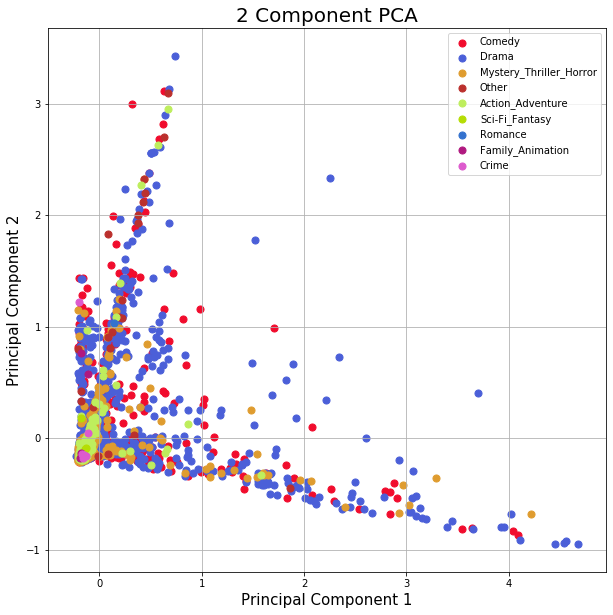

In [175]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

for i in range(len(dic_tar_col)):
    t = list(dic_tar_col.keys())[i]
    cc = dic_tar_col.get(t)
    
    indicesToKeep = finalDf['Target'] == t
    
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = cc
               , s = 50)
    
ax.legend(list(dic_tar_col.keys()))
ax.grid()

From this plot we can conclude that, in this case, PCA is not usefull to identify different genres. Colors are quite mixed indeed. What we hoped to obtain were distinguishable groups. Each group (each color) should have identified a set of words related to that specific genres. For example, for Romance keywords like kiss, love, Paris... The fact that all keywords are quite mixed is a proof of the fact that a word can be suitable for different genres. Then, it is hard to identify the groups.

##### Getting data to be used in prediction to csv file

In [ ]:
movie_df.to_csv('data/data_regression_onlyUS.csv')

# Gross-Budget Ratio Prediction <a name="gbrp"></a>

# Built-in Classifiers <a name="gbrbc"></a>

# 1) Ranks + Facebook Likes

In [845]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [846]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes'])

In [847]:
classification_df.head()

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3961      86.0                     63.0                   175.0   
3962      81.0                     26.0                   300.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3961                   489.0                       1278                   2.0   
3962                  2000.0                       3344                   0.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

     language      country content_rating        budget  ...  Sci-Fi_Fantasy  \
0     English          USA          PG-13  4.800000e+07  ...               1   
1     English          USA              R  6.000000e+06  ...               0   
2     English          USA             PG  4.867173e+07  ...               0   
3     English          USA              X  6.500000e+06  ...               0   
4     English          USA             PG  5.000000e+06  ...               0   
...       ...          ...            ...           ...  ...             ...   
3961  English          USA      Not Rated  9.900000e+05  ...               1   
3962  English          USA          PG-13  4.900000e+06  ...               0   
3963  English          USA             PG  5.000000e+06  ...               0   
3964   French       France      Not Rated  2.178331e+07  ...               0   
3965   Korean  South Korea      Not Rated  2.816008e+07  ...               1   

      Family_Animation  Action_Adventure  History_War  Others  director_rank  \
0                    0                 0            0       0              5   
1                    0                 0            0       1              3   
2                    0                 0            0       1              4   
3                    0                 0            0       0              3   
4                    0                 0            0       0              4   
...                ...               ...          ...     ...            ...   
3961                 0                 1            0       0              3   
3962                 0                 0            0       0              3   
3963                 0                 0            0       0              1   
3964                 0                 0            0       0              3   
3965                 0                 0            0       0              4   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0               6            3            5            0.981155  
1               7            3            5            6.633333  
2               3            4            4            1.641610  
3               2            3            

In [848]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'budget', 'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

## 1.1) All Movies

In [849]:
classification1_df=classification_df.drop(columns=['country','language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
3959     100.0                     24.0                   851.0   
3960      92.0                     89.0                   355.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
3959                 15000.0                      18786                   9.0   
3960                   729.0                       2848                   4.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
3959  2.000000e+07                  1000.0          0       1  ...   
3960  5.000000e+06                   706.0          0       1  ...   
3963  5.000000e+06                   420.0          0       0  ...   
3964  2.178331e+07                     8.0          0       1  ...   
3965  2.816008e+07                     5.0          0       0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
3959            5            5            5            2.773065   
3960            2            4            5            2.335036   
3963            2            3            4            4.154614   
3964            2            1            1            1.147809   
3965            1            1            0            0.027366   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0 

## 1.1.1) Without log and feature elimination

## 1.1.1.1) Seperating into 3 classes

In [196]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1     937
2     745
Name: gross_budget_ratio, dtype: int64

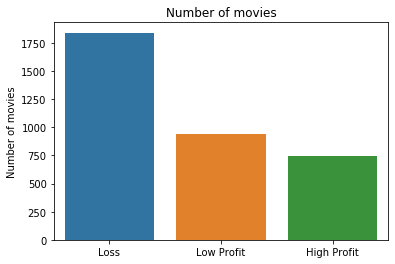

In [197]:
sns.barplot(['Loss','Low Profit','High Profit'],Counts)
plt.xticks(rotation=0)
plt.ylabel("Number of movies")
plt.title(f"Number of movies")
plt.show()

In [198]:
df11 = df1.copy()
df11['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [199]:
df11

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
3959     100.0                     24.0                   851.0   
3960      92.0                     89.0                   355.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
3959                 15000.0                      18786                   9.0   
3960                   729.0                       2848                   4.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
3959  2.000000e+07                  1000.0          0       1  ...   
3960  5.000000e+06                   706.0          0       1  ...   
3963  5.000000e+06                   420.0          0       0  ...   
3964  2.178331e+07                     8.0          0       1  ...   
3965  2.816008e+07                     5.0          0       0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5                   0   
2               3            4            4                   1   
3               2            3            4                   2   
4               6            4            5                   2   
6               5            3            6                   2   
...           ...          ...          ...                 ...   
3959            5            5            5                   2   
3960            2            4            5                   2   
3963            2            3            4                   2   
3964            2            1            1                   1   
3965            1            1            0                   0   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0 

In [200]:
X = df11.drop(columns=['gross_budget_ratio'])
y = df11['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 29)
Dimensionality of X_test : (1057, 29)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 1.1.1.1.1) Multi-Class Logistic Regression

In [201]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [202]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 100, 'penalty': 'l2'}
MLR Train score: 0.4972847168347556
MLR Test score: 0.467360454115421


Text(0.5, 1, 'Multiclass Logistic Regression')

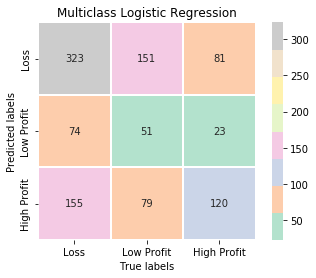

In [203]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 1.1.1.1.2) Decision Tree Classifier

In [204]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.5}
DTC Train score: 0.5227088402270884
DTC Test score: 0.522232734153264


Text(0.5, 1, 'Decision Tree Classifier')

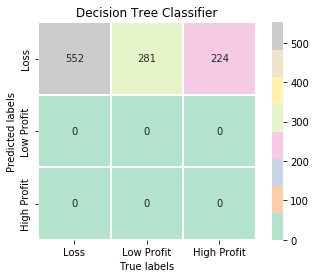

In [205]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.1.1.1.3) Random Forest Classifier

In [206]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
RFC Train score: 0.843065693430657
RFC Test score: 0.5402081362346263


Text(0.5, 1, 'Random Forest Classifier')

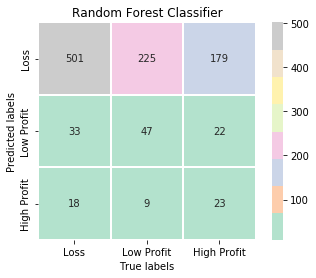

In [207]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 1.1.1.1.4) KNN Classifier

In [208]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [209]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.5401459854014599
KNN Test score: 0.5203405865657521


Text(0.5, 1, 'KNN Classifier')

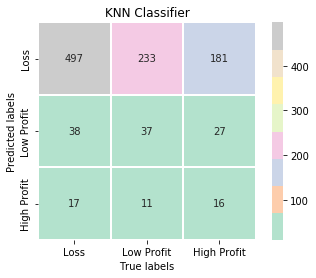

In [210]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 1.1.1.2) Seperating into 2 classes

In [211]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1    1682
Name: gross_budget_ratio, dtype: int64

In [212]:
df12 = df1.copy()
df12['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [213]:
X = df12.drop(columns=['gross_budget_ratio'])
y = df12['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 29)
Dimensionality of X_test : (1057, 29)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 1.1.1.2.1) Logistic Regression

In [214]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 0.001, 'penalty': 'l1'}
LR Train score: 0.8541505042668736
LR Test score: 0.8586956521739131
LR Test Accuracy score: 0.532639545884579


Text(0.5, 1, 'Logistic Regression')

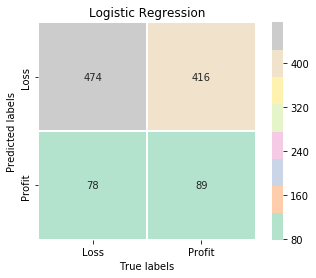

In [215]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 1.1.1.2.2) Decision Tree Classifier

In [216]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.5, 'min_samples_split': 0.001}
DTC Train score: 0.5484871993793639
DTC Test score: 0.5362318840579711
DTC Test Accuracy score: 0.5534531693472091


Text(0.5, 1, 'Decision Tree Classifier')

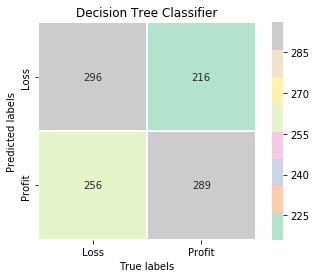

In [217]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.1.1.2.3) Random Forest Classifier

In [218]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
RFC Train score: 0.9317300232738557
RFC Test score: 0.6485507246376812
RFC Test Accuracy score: 0.5941343424787133


Text(0.5, 1, 'Random Forest Classifier')

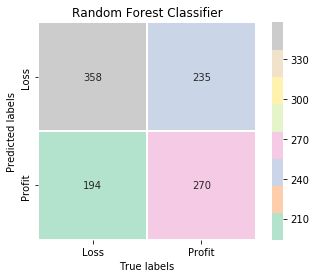

In [219]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 1.1.1.2.4) KNN Classifier

In [220]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [221]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.7788983708301008
KNN Test score: 0.6938405797101449
KNN Test Accuracy score: 0.5837275307473982


Text(0.5, 1, 'KNN Classifier')

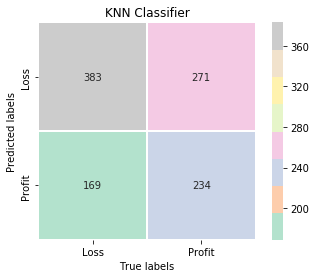

In [222]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 1.1.2) With taking log and feature elimination

### log

In [850]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [851]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_TV-14', 'content_rating_TV-G',
       'content_rating_TV-PG'],
      dtype='object')

In [852]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

## 1.1.2.1) Seperating into 3 classes

In [226]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1     937
2     745
Name: gross_budget_ratio, dtype: int64

In [227]:
df21 = df2.copy()
df21['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [228]:
df21

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                 6.100319                6.710523   
2        124.0                 5.010635                6.349139   
3        104.0                 0.000000                6.248043   
4        124.0                 0.000000                6.113682   
6        100.0                 5.976351                6.543912   
...        ...                      ...                     ...   
3959     100.0                 3.178054                6.746412   
3960      92.0                 4.488636                5.872118   
3963     120.0                 2.890372                5.686975   
3964     102.0                 2.484907                0.000000   
3965     156.0                 3.761200                0.000000   

      actor_1_facebook_likes  cast_total_facebook_likes     budget  \
0                   9.903488                  10.008253  17.686712   
2                   6.773080                   7.888710  17.700609   
3                   6.625392                   7.800573  15.687313   
4                   9.392662                   9.537051  15.424948   
6                   7.600902                   8.747670  16.118096   
...                      ...                        ...        ...   
3959                9.615805                   9.840867  16.811243   
3960                6.591674                   7.954372  15.424948   
3963                6.452049                   7.501082  15.424948   
3964                6.293419                   6.315358  16.896655   
3965                3.806662                   3.912023  17.153416   

      actor_2_facebook_likes  Comedy  Drama  Romance  ...  actor1_rank  \
0                   6.907755       1      0        1  ...            6   
2                   6.704414       0      1        0  ...            3   
3                   6.340359       0      0        1  ...            2   
4                   6.625392       0      1        0  ...            6   
6                   6.830874       0      0        0  ...            5   
...                      ...     ...    ...      ...  ...          ...   
3959                6.907755       1      0        0  ...            5   
3960                6.559615       1      0        0  ...            2   
3963                6.040255       0      1        0  ...            2   
3964                2.079442       1      1        0  ...            2   
3965                1.609438       0      0        0  ...            1   

      actor2_rank  actor3_rank  gross_budget_ratio  content_rating_PG  \
0               3            5                   0                  0   
2               4            4                   1                  1   
3               3            4                   2                  0   
4               4            5                   2                  1   
6               3            6                   2                  0   
...           ...          ...                 ...                ...   
3959            5            5                   2                  0   
3960            4            5                   2                  0   
3963            3            4                   2                  1   
3964            1            1                   1                  0   
3965            1            0                   0                  0   

      content_rating_PG-13  content_rating_R  content_rating_TV-14  \
0                        1                 0                     0   
2                        0                 0                     0   
3                        0                 0                     0   
4                        0                 0                     0   
6                        0                 1                     0   
...                    ...               ...                   ...   
3959                     0                 1                     0   
3960                     0        

In [229]:
X = df21.drop(columns=['gross_budget_ratio'])
y = df21['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 23)
Dimensionality of X_test : (1057, 23)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 1.1.2.1.1) Multi-Class Logistic Regression

In [230]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [231]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 10, 'penalty': 'l2'}
MLR Train score: 0.5352986811481769
MLR Test score: 0.46830652790917693


Text(0.5, 1, 'Multiclass Logistic Regression')

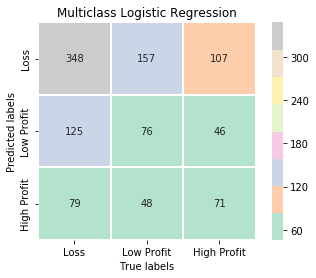

In [232]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 1.1.2.1.2) Decision Tree Classifier

In [233]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.05}
DTC Train score: 0.5742092457420924
DTC Test score: 0.5241248817407758


Text(0.5, 1, 'Decision Tree Classifier')

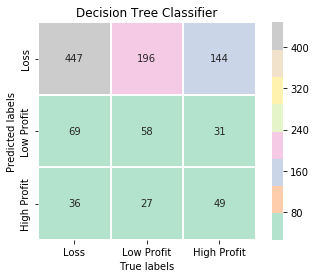

In [234]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.1.2.1.3) Random Forest Classifier

In [235]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.8369829683698297
RFC Test score: 0.5250709555345316


Text(0.5, 1, 'Random Forest Classifier')

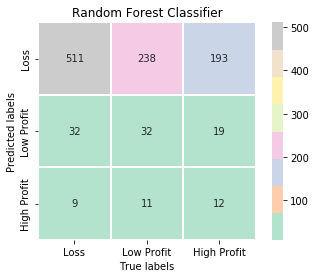

In [236]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 1.1.2.1.4) KNN Classifier

In [237]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [238]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.5320356853203568
KNN Test score: 0.5023651844843898


Text(0.5, 1, 'KNN Classifier')

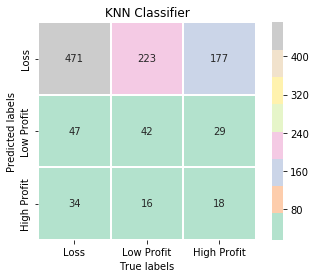

In [239]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 1.1.2.2) Seperating into 2 classes

In [853]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1    1682
Name: gross_budget_ratio, dtype: int64

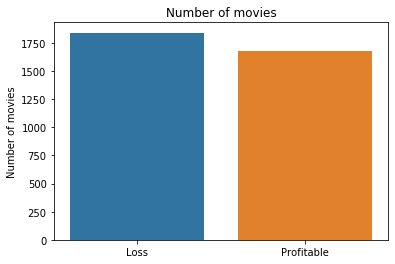

In [241]:
sns.barplot(['Loss','Profitable'],Counts)
plt.xticks(rotation=0)
plt.ylabel("Number of movies")
plt.title(f"Number of movies")
plt.show()

In [854]:
df22 = df2.copy()
df22['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [855]:
X = df22.drop(columns=['gross_budget_ratio'])
y = df22['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 23)
Dimensionality of X_test : (1057, 23)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 1.1.2.2.1) Logistic Regression

In [244]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 0.001, 'penalty': 'l1'}
LR Train score: 1.0
LR Test score: 1.0
LR Test Accuracy score: 0.522232734153264


Text(0.5, 1, 'Logistic Regression')

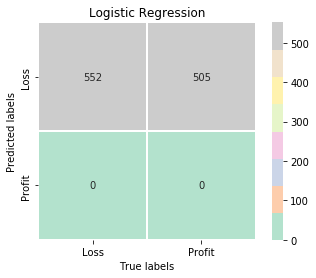

In [245]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 1.1.2.2.2) Decision Tree Classifier

In [246]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.5, 'min_samples_split': 0.001}
DTC Train score: 0.5484871993793639
DTC Test score: 0.5362318840579711
DTC Test Accuracy score: 0.5534531693472091


Text(0.5, 1, 'Decision Tree Classifier')

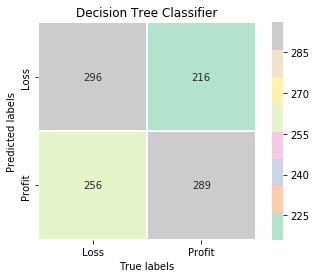

In [247]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.1.2.2.3) Random Forest Classifier

In [813]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}
RFC Train score: 0.9456943366951125
RFC Test score: 0.6539855072463768
RFC Test Accuracy score: 0.6253547776726585


Feature ranking:
1. feature 5 (0.127190)
2. feature 2 (0.101666)
3. feature 4 (0.101549)
4. feature 6 (0.097502)
5. feature 0 (0.093793)
6. feature 1 (0.088139)
7. feature 3 (0.085729)
8. feature 13 (0.062587)
9. feature 14 (0.041181)
10. feature 16 (0.038041)
11. feature 15 (0.033399)
12. feature 8 (0.023870)
13. feature 7 (0.016039)
14. feature 10 (0.015378)
15. feature 11 (0.013263)
16. feature 12 (0.012704)
17. feature 9 (0.012504)
18. feature 18 (0.012225)
19. feature 19 (0.012113)
20. feature 17 (0.010252)
21. feature 20 (0.000796)
22. feature 21 (0.000076)
23. feature 22 (0.000000)


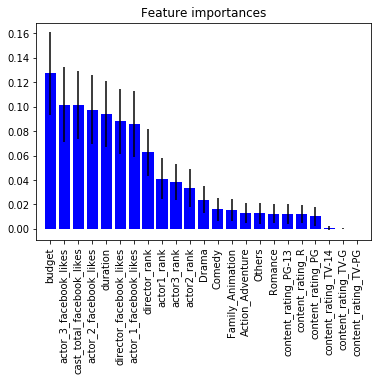

In [817]:
clf3=RandomForestClassifier(criterion= 'entropy', max_depth= 10, n_estimators= 200,random_state=10)
clf3.fit(X_train, y_train)
features = X.columns
importances = clf3.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf3.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Text(0.5, 1, 'Random Forest Classifier')

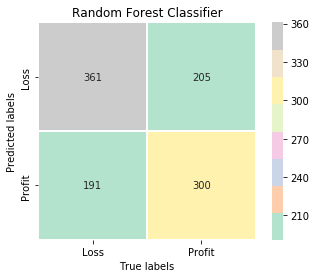

In [249]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

Text(0.5, 1.0, 'RFC ROC Curve')

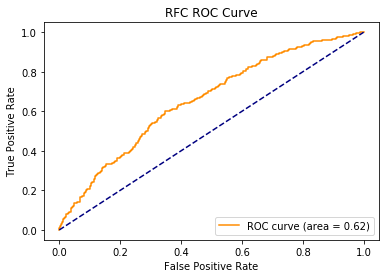

In [250]:
ax = plt.subplot()
y_score = clf3.predict_proba(X_test)
Model_Predictions = clf3.predict(X_test)
auc_score = roc_auc_score(Model_Predictions, y_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
plt.plot(fpr, tpr,color='darkorange', label='ROC curve (area = %0.2f)' %(auc_score))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(loc="lower right")
ax.set_title('RFC ROC Curve')

#### Additional XGBoost

In [856]:
params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01, 0.02],
    'subsample': [0.4, 0.6, 0.8]
}
clf = GridSearchCV(XGBClassifier(silent=False,random_state=10), params, scoring =make_scorer(recall_score,pos_label=0))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("XGBC best parameters:", clf.best_params_)
print("XGBC Train score:", clf.score(X_train, y_train))
print("XGBC Test score:", clf.score(X_test, y_test))
print("XGBC Test Accuracy score:", accuracy_score(y_pred, y_test))

XGBC best parameters: {'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.6}
XGBC Train score: 0.7284716834755625
XGBC Test score: 0.7083333333333334
XGBC Test Accuracy score: 0.5846736045411542


Feature ranking:
1. feature 4 (0.108717)
2. feature 2 (0.106586)
3. feature 14 (0.098545)
4. feature 13 (0.098488)
5. feature 8 (0.086391)
6. feature 6 (0.084145)
7. feature 5 (0.077883)
8. feature 10 (0.059761)
9. feature 3 (0.059389)
10. feature 7 (0.056773)
11. feature 1 (0.053119)
12. feature 18 (0.043224)
13. feature 19 (0.041577)
14. feature 0 (0.025402)
15. feature 22 (0.000000)
16. feature 9 (0.000000)
17. feature 21 (0.000000)
18. feature 12 (0.000000)
19. feature 15 (0.000000)
20. feature 16 (0.000000)
21. feature 17 (0.000000)
22. feature 20 (0.000000)
23. feature 11 (0.000000)


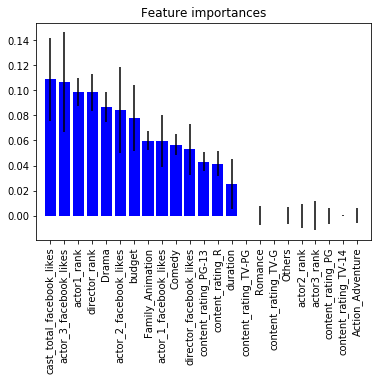

In [857]:
clf=XGBClassifier(learning_rate= 0.005, max_depth= 2, n_estimators= 100, subsample= 0.6,random_state=10)
clf.fit(X_train, y_train)
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Text(0.5, 1, 'XGBoost Classifier')

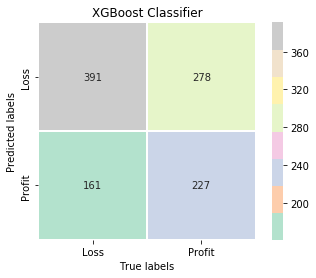

In [858]:
ax = plt.subplot()
Model_Predictions = clf.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('XGBoost Classifier')

Text(0.5, 1.0, 'XGBC ROC Curve')

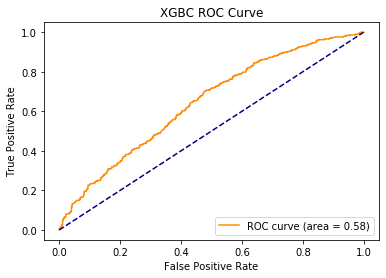

In [253]:
ax = plt.subplot()
y_score = clf.predict_proba(X_test)
Model_Predictions = clf.predict(X_test)
auc_score = roc_auc_score(Model_Predictions, y_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
plt.plot(fpr, tpr,color='darkorange', label='ROC curve (area = %0.2f)' %(auc_score))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(loc="lower right")
ax.set_title('XGBC ROC Curve')

### 1.1.2.2.4) KNN Classifier

In [254]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [255]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.7812257564003103
KNN Test score: 0.7137681159420289
KNN Test Accuracy score: 0.5894039735099338


Text(0.5, 1, 'KNN Classifier')

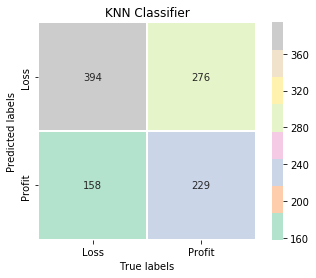

In [256]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 1.2) Only US Movies

In [257]:
movie_df = pd.read_csv(r'data/data_regression_onlyUS.csv')

In [258]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes'])

In [259]:
classification_df

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3004      86.0                     63.0                   175.0   
3005      81.0                     26.0                   300.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3004                   489.0                       1278                   2.0   
3005                  2000.0                       3344                   0.0   
3006                   634.0                       1810                  11.0   

     language content_rating       budget  actor_2_facebook_likes  ...  \
0     English          PG-13  48000000.00                  1000.0  ...   
1     English              R   6000000.00                   573.0  ...   
2     English             PG  48671729.12                   816.0  ...   
3     English              X   6500000.00                   567.0  ...   
4     English             PG   5000000.00                   754.0  ...   
...       ...            ...          ...                     ...  ...   
3002  English              R  20000000.00                  1000.0  ...   
3003  English              R   5000000.00                   706.0  ...   
3004  English      Not Rated    990000.00                   207.0  ...   
3005  English          PG-13   4900000.00                   509.0  ...   
3006  English             PG   5000000.00                   420.0  ...   

      Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  Others  \
0                  1                 0                 0            0       0   
1                  0                 0                 0            0       1   
2                  0                 0                 0            0       1   
3                  0                 0                 0            0       0   
4                  0                 0                 0            0       0   
...              ...               ...               ...          ...     ...   
3002               0                 0                 0            0       0   
3003               0                 0                 0            0       0   
3004               1                 0                 1            0       0   
3005               0                 0                 0            0       0   
3006               0                 0                 0            0       0   

      director_rank  actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0                 5            6            3            5            0.981155  
1                 3            7            3            5            6.633333  
2                 4            3            4            4            1.641610  
3                 3            2          

In [260]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'content_rating', 'budget',
       'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

In [261]:
classification1_df=classification_df.drop(columns=['language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
2999      92.0                     89.0                   190.0   
3001      97.0                     20.0                   538.0   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
2999                 17000.0                      17860                   0.0   
3001                   741.0                       2849                   1.0   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3006                   634.0                       1810                  11.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
2999  3.500000e+07                   329.0          0       1  ...   
3001  2.178331e+07                   615.0          0       0  ...   
3002  2.000000e+07                  1000.0          0       1  ...   
3003  5.000000e+06                   706.0          0       1  ...   
3006  5.000000e+06                   420.0          0       0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
2999            5            3            4            1.579766   
3001            2            3            4            1.147809   
3002            5            5            5            2.773065   
3003            2            4            5            2.335036   
3006            2            3            4            4.154614   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0 

## 1.2.1) Without log and feature elimination

## 1.2.1.1) Seperating into 3 classes

In [262]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1259
1     780
2     626
Name: gross_budget_ratio, dtype: int64

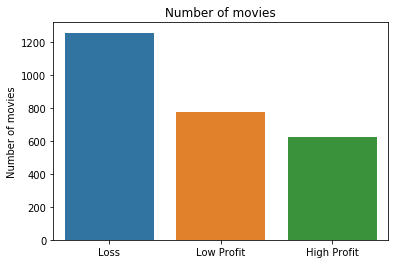

In [263]:
sns.barplot(['Loss','Low Profit','High Profit'],Counts)
plt.xticks(rotation=0)
plt.ylabel("Number of movies")
plt.title(f"Number of movies")
plt.show()

In [264]:
df11 = df1.copy()
df11['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [265]:
df11

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
2999      92.0                     89.0                   190.0   
3001      97.0                     20.0                   538.0   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
2999                 17000.0                      17860                   0.0   
3001                   741.0                       2849                   1.0   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3006                   634.0                       1810                  11.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
2999  3.500000e+07                   329.0          0       1  ...   
3001  2.178331e+07                   615.0          0       0  ...   
3002  2.000000e+07                  1000.0          0       1  ...   
3003  5.000000e+06                   706.0          0       1  ...   
3006  5.000000e+06                   420.0          0       0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5                   0   
2               3            4            4                   1   
3               2            3            4                   2   
4               6            4            5                   2   
6               5            3            6                   2   
...           ...          ...          ...                 ...   
2999            5            3            4                   1   
3001            2            3            4                   1   
3002            5            5            5                   2   
3003            2            4            5                   2   
3006            2            3            4                   2   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0 

In [266]:
X = df11.drop(columns=['gross_budget_ratio'])
y = df11['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 29)
Dimensionality of X_test : (800, 29)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 1.2.1.1.1) Multi-Class Logistic Regression

In [267]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [268]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 0.001, 'penalty': 'l2'}
MLR Train score: 0.4328414680287552
MLR Test score: 0.38125


Text(0.5, 1, 'Multiclass Logistic Regression')

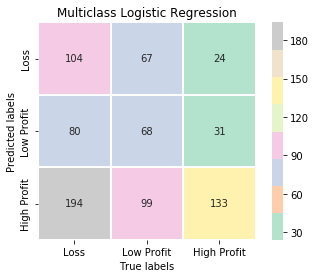

In [269]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 1.2.1.1.2) Decision Tree Classifier

In [270]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.1}
DTC Train score: 0.5040214477211796
DTC Test score: 0.495


Text(0.5, 1, 'Decision Tree Classifier')

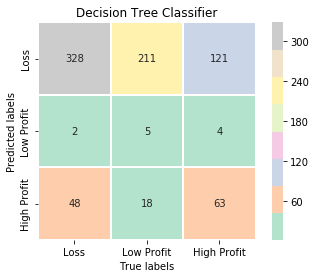

In [271]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.2.1.1.3) Random Forest Classifier

In [272]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
RFC Train score: 0.8831099195710456
RFC Test score: 0.48


Text(0.5, 1, 'Random Forest Classifier')

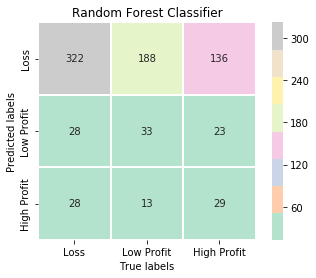

In [273]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 1.2.1.1.4) KNN Classifier

In [274]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [275]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.48954423592493296
KNN Test score: 0.48


Text(0.5, 1, 'KNN Classifier')

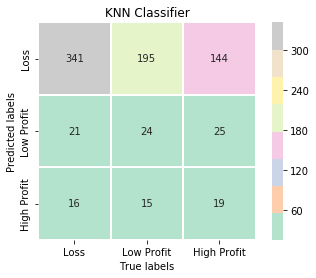

In [276]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 1.2.1.2) Seperating into 2 classes

In [277]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts
Counts2=[]
Counts2.append(Counts[1]) 
Counts2.append(Counts[0]) 
Counts2.reverse()

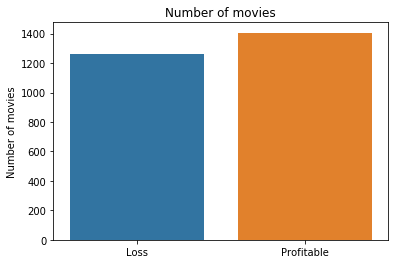

In [278]:
sns.barplot(['Loss','Profitable'],Counts2)
plt.xticks(rotation=0)
plt.ylabel("Number of movies")
plt.title(f"Number of movies")
plt.show()

In [279]:
df12 = df1.copy()
df12['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [280]:
X = df12.drop(columns=['gross_budget_ratio'])
y = df12['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 29)
Dimensionality of X_test : (800, 29)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 1.2.1.2.1) Logistic Regression

In [281]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 100, 'penalty': 'l1'}
LR Train score: 0.5425652667423383
LR Test score: 0.5529100529100529
LR Test Accuracy score: 0.62375


Text(0.5, 1, 'Logistic Regression')

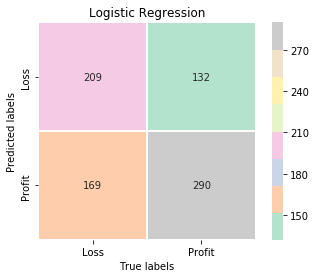

In [282]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 1.2.1.2.2) Decision Tree Classifier

In [283]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.05, 'min_samples_split': 0.5}
DTC Train score: 0.6923950056753689
DTC Test score: 0.6825396825396826
DTC Test Accuracy score: 0.57


Text(0.5, 1, 'Decision Tree Classifier')

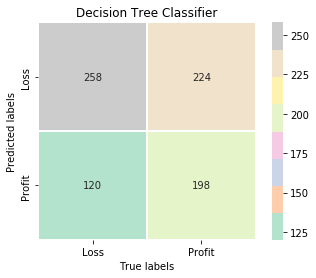

In [284]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.2.1.2.3) Random Forest Classifier

In [285]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 50}
RFC Train score: 1.0
RFC Test score: 0.5502645502645502
RFC Test Accuracy score: 0.62


Text(0.5, 1, 'Random Forest Classifier')

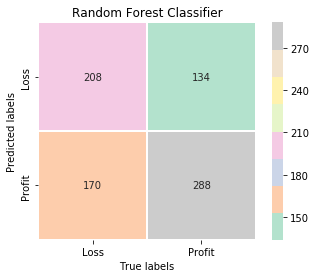

In [286]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 1.2.1.2.4) KNN Classifier

In [287]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [288]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.6787741203178207
KNN Test score: 0.5529100529100529
KNN Test Accuracy score: 0.55


Text(0.5, 1, 'KNN Classifier')

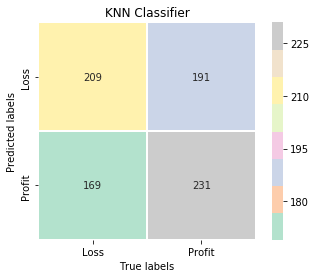

In [289]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 1.2.2) With taking log and feature elimination

### log

In [290]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [291]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_TV-14', 'content_rating_TV-G',
       'content_rating_TV-PG'],
      dtype='object')

In [292]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

## 1.2.2.1) Seperating into 3 classes

In [293]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1259
1     780
2     626
Name: gross_budget_ratio, dtype: int64

In [294]:
df21 = df2.copy()
df21['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [295]:
df21

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                 6.100319                6.710523   
2        124.0                 5.010635                6.349139   
3        104.0                 0.000000                6.248043   
4        124.0                 0.000000                6.113682   
6        100.0                 5.976351                6.543912   
...        ...                      ...                     ...   
2999      92.0                 4.488636                5.247024   
3001      97.0                 2.995732                6.287859   
3002     100.0                 3.178054                6.746412   
3003      92.0                 4.488636                5.872118   
3006     120.0                 2.890372                5.686975   

      actor_1_facebook_likes  cast_total_facebook_likes     budget  \
0                   9.903488                  10.008253  17.686712   
2                   6.773080                   7.888710  17.700609   
3                   6.625392                   7.800573  15.687313   
4                   9.392662                   9.537051  15.424948   
6                   7.600902                   8.747670  16.118096   
...                      ...                        ...        ...   
2999                9.740969                   9.790319  17.370859   
3001                6.608001                   7.954723  16.896655   
3002                9.615805                   9.840867  16.811243   
3003                6.591674                   7.954372  15.424948   
3006                6.452049                   7.501082  15.424948   

      actor_2_facebook_likes  Comedy  Drama  Romance  ...  actor1_rank  \
0                   6.907755       1      0        1  ...            6   
2                   6.704414       0      1        0  ...            3   
3                   6.340359       0      0        1  ...            2   
4                   6.625392       0      1        0  ...            6   
6                   6.830874       0      0        0  ...            5   
...                      ...     ...    ...      ...  ...          ...   
2999                5.796058       1      0        0  ...            5   
3001                6.421622       0      0        0  ...            2   
3002                6.907755       1      0        0  ...            5   
3003                6.559615       1      0        0  ...            2   
3006                6.040255       0      1        0  ...            2   

      actor2_rank  actor3_rank  gross_budget_ratio  content_rating_PG  \
0               3            5                   0                  0   
2               4            4                   1                  1   
3               3            4                   2                  0   
4               4            5                   2                  1   
6               3            6                   2                  0   
...           ...          ...                 ...                ...   
2999            3            4                   1                  0   
3001            3            4                   1                  0   
3002            5            5                   2                  0   
3003            4            5                   2                  0   
3006            3            4                   2                  1   

      content_rating_PG-13  content_rating_R  content_rating_TV-14  \
0                        1                 0                     0   
2                        0                 0                     0   
3                        0                 0                     0   
4                        0                 0                     0   
6                        0                 1                     0   
...                    ...               ...                   ...   
2999                     0                 1                     0   
3001                     0        

In [296]:
X = df21.drop(columns=['gross_budget_ratio'])
y = df21['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 23)
Dimensionality of X_test : (800, 23)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 1.2.2.1.1) Multi-Class Logistic Regression

In [297]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [298]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 0.1, 'penalty': 'l2'}
MLR Train score: 0.5145667801740447
MLR Test score: 0.45625


Text(0.5, 1, 'Multiclass Logistic Regression')

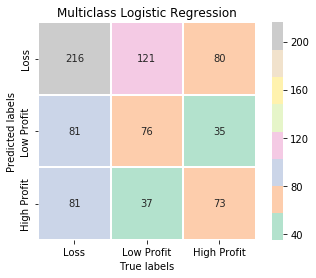

In [299]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 1.2.2.1.2) Decision Tree Classifier

In [300]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.1}
DTC Train score: 0.5040214477211796
DTC Test score: 0.495


Text(0.5, 1, 'Decision Tree Classifier')

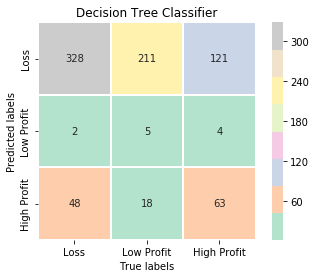

In [301]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.2.2.1.3) Random Forest Classifier

In [302]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}
RFC Train score: 0.8831099195710456
RFC Test score: 0.485


Text(0.5, 1, 'Random Forest Classifier')

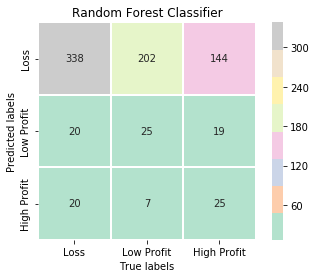

In [303]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 1.2.2.1.4) KNN Classifier

In [304]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [305]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.4804289544235925
KNN Test score: 0.46125


Text(0.5, 1, 'KNN Classifier')

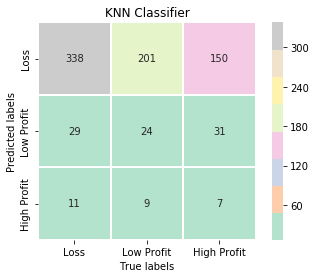

In [306]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 1.2.2.2) Seperating into 2 classes

In [307]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

1    1406
0    1259
Name: gross_budget_ratio, dtype: int64

In [308]:
df22 = df2.copy()
df22['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [309]:
X = df22.drop(columns=['gross_budget_ratio'])
y = df22['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 23)
Dimensionality of X_test : (800, 23)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 1.2.2.2.1) Logistic Regression

In [310]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 1000, 'penalty': 'l1'}
LR Train score: 0.5085130533484676
LR Test score: 0.5132275132275133
LR Test Accuracy score: 0.6175


Text(0.5, 1, 'Logistic Regression')

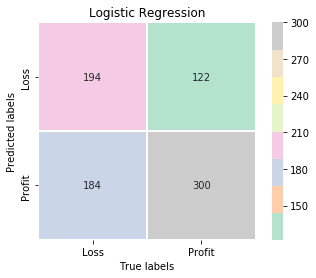

In [311]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 1.2.2.2.2) Decision Tree Classifier

In [312]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.05, 'min_samples_split': 0.5}
DTC Train score: 0.6923950056753689
DTC Test score: 0.6825396825396826
DTC Test Accuracy score: 0.57375


Text(0.5, 1, 'Decision Tree Classifier')

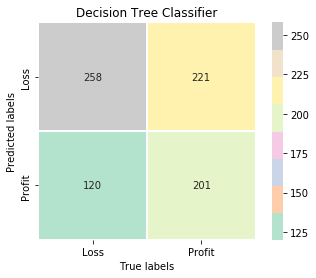

In [313]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 1.2.2.2.3) Random Forest Classifier

In [314]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 50}
RFC Train score: 1.0
RFC Test score: 0.5291005291005291
RFC Test Accuracy score: 0.59625


Text(0.5, 1, 'Random Forest Classifier')

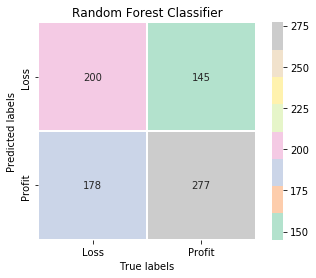

In [315]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 1.2.2.2.4) KNN Classifier

In [316]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [317]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.681044267877412
KNN Test score: 0.5634920634920635
KNN Test Accuracy score: 0.5475


Text(0.5, 1, 'KNN Classifier')

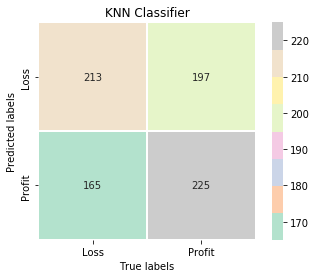

In [318]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

# 2) Only Facebook Likes

In [319]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [320]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank'])

In [321]:
classification_df

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3961      86.0                     63.0                   175.0   
3962      81.0                     26.0                   300.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3961                   489.0                       1278                   2.0   
3962                  2000.0                       3344                   0.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

     language      country content_rating        budget  ...  Crime  Drama  \
0     English          USA          PG-13  4.800000e+07  ...      0      0   
1     English          USA              R  6.000000e+06  ...      0      0   
2     English          USA             PG  4.867173e+07  ...      0      1   
3     English          USA              X  6.500000e+06  ...      0      0   
4     English          USA             PG  5.000000e+06  ...      0      1   
...       ...          ...            ...           ...  ...    ...    ...   
3961  English          USA      Not Rated  9.900000e+05  ...      0      1   
3962  English          USA          PG-13  4.900000e+06  ...      0      0   
3963  English          USA             PG  5.000000e+06  ...      0      1   
3964   French       France      Not Rated  2.178331e+07  ...      0      1   
3965   Korean  South Korea      Not Rated  2.816008e+07  ...      0      0   

      Romance  Mystery_Thriller_Horror  Sci-Fi_Fantasy  Family_Animation  \
0           1                        0               1                 0   
1           0                        0               0                 0   
2           0                        0               0                 0   
3           1                        1               0                 0   
4           0                        0               0                 0   
...       ...                      ...             ...               ...   
3961        0                        0               1                 0   
3962        0                        1               0                 0   
3963        0                        0               0                 0   
3964        0                        0               0                 0   
3965        0                        1               1                 0   

      Action_Adventure  History_War  Others  gross_budget_ratio  
0                    0            0       0            0.981155  
1                    0            0       1            6.633333  
2                    0            0       1            1.641610  
3                    0            0       0            4.907538  
4                    0            0       0     

In [322]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'budget', 'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'gross_budget_ratio'],
      dtype='object')

## 2.1) All Movies

In [323]:
classification1_df=classification_df.drop(columns=['country','language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
3959     100.0                     24.0                   851.0   
3960      92.0                     89.0                   355.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
3959                 15000.0                      18786                   9.0   
3960                   729.0                       2848                   4.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
3959  2.000000e+07                  1000.0          0       1  ...   
3960  5.000000e+06                   706.0          0       1  ...   
3963  5.000000e+06                   420.0          0       0  ...   
3964  2.178331e+07                     8.0          0       1  ...   
3965  2.816008e+07                     5.0          0       0  ...   

      Action_Adventure  History_War  Others  gross_budget_ratio  \
0                    0            0       0            0.981155   
2                    0            0       1            1.641610   
3                    0            0       0            4.907538   
4                    0            0       0            5.202173   
6                    0            0       1            2.500307   
...                ...          ...     ...                 ...   
3959                 0            0       0            2.773065   
3960                 0            0       0            2.335036   
3963                 0            0       0            4.154614   
3964                 0            0       0            1.147809   
3965                 0            0       0            0.027366   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0 

## 2.1.1) Without log and feature elimination

## 2.1.1.1) Seperating into 3 classes

In [324]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1     937
2     745
Name: gross_budget_ratio, dtype: int64

In [325]:
df11 = df1.copy()
df11['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [326]:
df11

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
3959     100.0                     24.0                   851.0   
3960      92.0                     89.0                   355.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
3959                 15000.0                      18786                   9.0   
3960                   729.0                       2848                   4.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
3959  2.000000e+07                  1000.0          0       1  ...   
3960  5.000000e+06                   706.0          0       1  ...   
3963  5.000000e+06                   420.0          0       0  ...   
3964  2.178331e+07                     8.0          0       1  ...   
3965  2.816008e+07                     5.0          0       0  ...   

      Action_Adventure  History_War  Others  gross_budget_ratio  \
0                    0            0       0                   0   
2                    0            0       1                   1   
3                    0            0       0                   2   
4                    0            0       0                   2   
6                    0            0       1                   2   
...                ...          ...     ...                 ...   
3959                 0            0       0                   2   
3960                 0            0       0                   2   
3963                 0            0       0                   2   
3964                 0            0       0                   1   
3965                 0            0       0                   0   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0 

In [327]:
X = df11.drop(columns=['gross_budget_ratio'])
y = df11['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 25)
Dimensionality of X_test : (1057, 25)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 2.1.1.1.1) Multi-Class Logistic Regression

In [328]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [329]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 100, 'penalty': 'l2'}
MLR Train score: 0.45590897336436514
MLR Test score: 0.42005676442762535


Text(0.5, 1, 'Multiclass Logistic Regression')

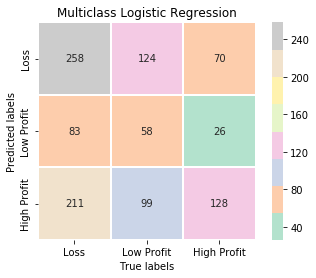

In [330]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 2.1.1.1.2) Decision Tree Classifier

In [331]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.001}
DTC Train score: 0.5433901054339011
DTC Test score: 0.5316934720908231


Text(0.5, 1, 'Decision Tree Classifier')

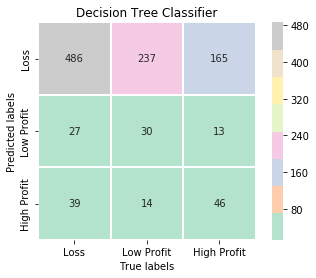

In [332]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.1.1.1.3) Random Forest Classifier

In [333]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.8414436334144363
RFC Test score: 0.5203405865657521


Text(0.5, 1, 'Random Forest Classifier')

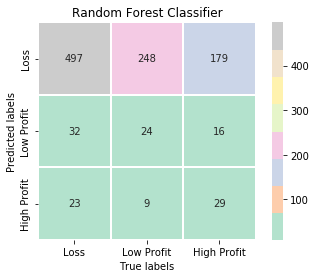

In [334]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.1.1.1.4) KNN Classifier

In [335]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [336]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 20}
KNN Train score: 0.5636658556366586
KNN Test score: 0.5099337748344371


Text(0.5, 1, 'KNN Classifier')

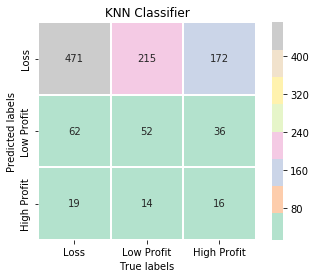

In [337]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 2.1.1.2) Seperating into 2 classes

In [338]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1    1682
Name: gross_budget_ratio, dtype: int64

In [339]:
df12 = df1.copy()
df12['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [340]:
X = df12.drop(columns=['gross_budget_ratio'])
y = df12['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 25)
Dimensionality of X_test : (1057, 25)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 2.1.1.2.1) Logistic Regression

In [341]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 0.01, 'penalty': 'l1'}
LR Train score: 0.8634600465477114
LR Test score: 0.8659420289855072
LR Test Accuracy score: 0.5316934720908231


Text(0.5, 1, 'Logistic Regression')

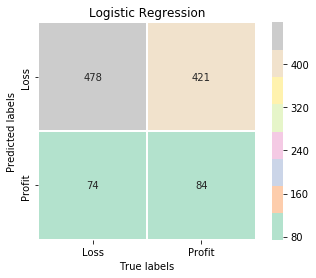

In [342]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 2.1.1.2.2) Decision Tree Classifier

In [343]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.5, 'min_samples_split': 0.001}
DTC Train score: 0.5484871993793639
DTC Test score: 0.5362318840579711
DTC Test Accuracy score: 0.5534531693472091


Text(0.5, 1, 'Decision Tree Classifier')

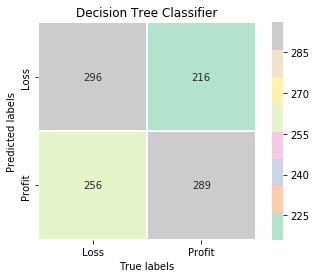

In [344]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.1.1.2.3) Random Forest Classifier

In [345]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.943366951124903
RFC Test score: 0.6431159420289855
RFC Test Accuracy score: 0.5950804162724692


Text(0.5, 1, 'Random Forest Classifier')

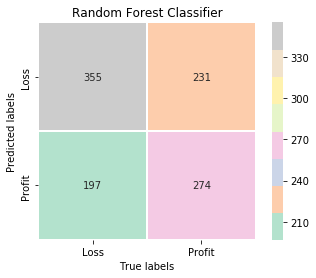

In [346]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.1.1.2.4) KNN Classifier

In [347]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [348]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.7990690457719162
KNN Test score: 0.6920289855072463
KNN Test Accuracy score: 0.5808893093661306


Text(0.5, 1, 'KNN Classifier')

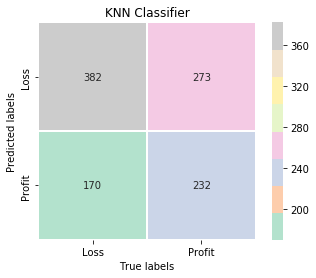

In [349]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 2.1.2) With taking log and feature elimination

### log

In [350]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [351]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'gross_budget_ratio', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R', 'content_rating_TV-14',
       'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [352]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

## 2.1.2.1) Seperating into 3 classes

In [353]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1     937
2     745
Name: gross_budget_ratio, dtype: int64

In [354]:
df21 = df2.copy()
df21['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [355]:
df21

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                 6.100319                6.710523   
2        124.0                 5.010635                6.349139   
3        104.0                 0.000000                6.248043   
4        124.0                 0.000000                6.113682   
6        100.0                 5.976351                6.543912   
...        ...                      ...                     ...   
3959     100.0                 3.178054                6.746412   
3960      92.0                 4.488636                5.872118   
3963     120.0                 2.890372                5.686975   
3964     102.0                 2.484907                0.000000   
3965     156.0                 3.761200                0.000000   

      actor_1_facebook_likes  cast_total_facebook_likes     budget  \
0                   9.903488                  10.008253  17.686712   
2                   6.773080                   7.888710  17.700609   
3                   6.625392                   7.800573  15.687313   
4                   9.392662                   9.537051  15.424948   
6                   7.600902                   8.747670  16.118096   
...                      ...                        ...        ...   
3959                9.615805                   9.840867  16.811243   
3960                6.591674                   7.954372  15.424948   
3963                6.452049                   7.501082  15.424948   
3964                6.293419                   6.315358  16.896655   
3965                3.806662                   3.912023  17.153416   

      actor_2_facebook_likes  Comedy  Drama  Romance  Family_Animation  \
0                   6.907755       1      0        1                 0   
2                   6.704414       0      1        0                 0   
3                   6.340359       0      0        1                 0   
4                   6.625392       0      1        0                 0   
6                   6.830874       0      0        0                 0   
...                      ...     ...    ...      ...               ...   
3959                6.907755       1      0        0                 0   
3960                6.559615       1      0        0                 0   
3963                6.040255       0      1        0                 0   
3964                2.079442       1      1        0                 0   
3965                1.609438       0      0        0                 0   

      Action_Adventure  Others  gross_budget_ratio  content_rating_PG  \
0                    0       0                   0                  0   
2                    0       1                   1                  1   
3                    0       0                   2                  0   
4                    0       0                   2                  1   
6                    0       1                   2                  0   
...                ...     ...                 ...                ...   
3959                 0       0                   2                  0   
3960                 0       0                   2                  0   
3963                 0       0                   2                  1   
3964                 0       0                   1                  0   
3965                 0       0                   0                  0   

      content_rating_PG-13  content_rating_R  content_rating_TV-14  \
0                        1                 0                     0   
2                        0                 0                     0   
3                        0                 0                     0   
4                        0                 0                     0   
6                        0                 1                     0   
...                    ...               ...                   ...   
3959                     0                 1                     0   
3960                     0        

In [356]:
X = df21.drop(columns=['gross_budget_ratio'])
y = df21['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 19)
Dimensionality of X_test : (1057, 19)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 2.1.2.1.1) Multi-Class Logistic Regression

In [357]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [358]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 1, 'penalty': 'l2'}
MLR Train score: 0.5267649340574089
MLR Test score: 0.4512771996215705


Text(0.5, 1, 'Multiclass Logistic Regression')

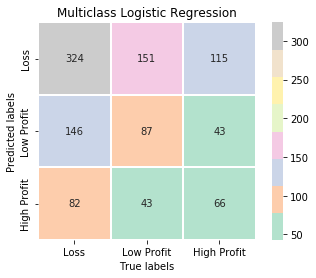

In [359]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 2.1.2.1.2) Decision Tree Classifier

In [360]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.1}
DTC Train score: 0.5462287104622872
DTC Test score: 0.521286660359508


Text(0.5, 1, 'Decision Tree Classifier')

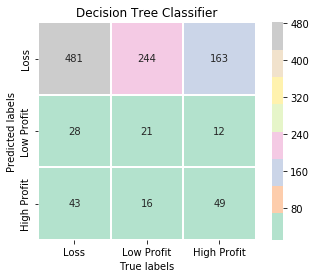

In [361]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.1.2.1.3) Random Forest Classifier

In [362]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.8357664233576643
RFC Test score: 0.5345316934720908


Text(0.5, 1, 'Random Forest Classifier')

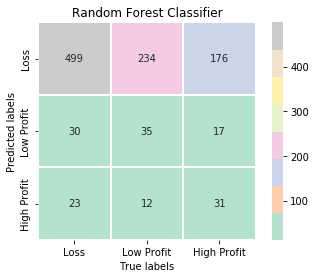

In [363]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.1.2.1.4) KNN Classifier

In [364]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [365]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.540551500405515
KNN Test score: 0.5061494796594135


Text(0.5, 1, 'KNN Classifier')

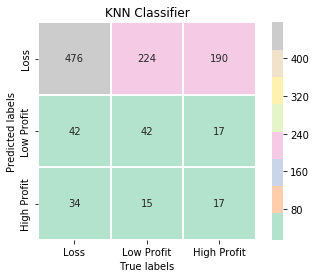

In [366]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 2.1.2.2) Seperating into 2 classes

In [367]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1    1682
Name: gross_budget_ratio, dtype: int64

In [368]:
df22 = df2.copy()
df22['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [369]:
X = df22.drop(columns=['gross_budget_ratio'])
y = df22['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 19)
Dimensionality of X_test : (1057, 19)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 2.1.2.2.1) Logistic Regression

In [370]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 0.001, 'penalty': 'l1'}
LR Train score: 1.0
LR Test score: 1.0
LR Test Accuracy score: 0.522232734153264


Text(0.5, 1, 'Logistic Regression')

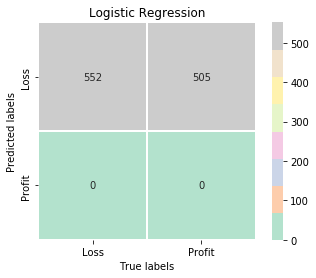

In [371]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 2.1.2.2.2) Decision Tree Classifier

In [372]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.5, 'min_samples_split': 0.001}
DTC Train score: 0.5484871993793639
DTC Test score: 0.5362318840579711
DTC Test Accuracy score: 0.5534531693472091


Text(0.5, 1, 'Decision Tree Classifier')

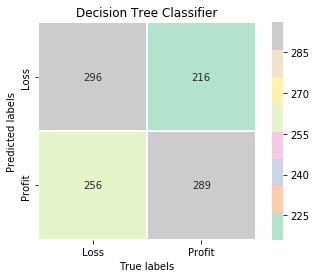

In [373]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.1.2.2.3) Random Forest Classifier

In [374]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}
RFC Train score: 0.9449185415050426
RFC Test score: 0.6630434782608695
RFC Test Accuracy score: 0.6073793755912961


Text(0.5, 1, 'Random Forest Classifier')

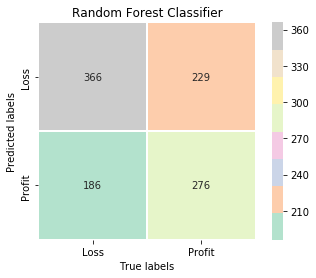

In [375]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.1.2.2.4) KNN Classifier

In [376]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [377]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 20}
KNN Train score: 0.7051978277734678
KNN Test score: 0.6630434782608695
KNN Test Accuracy score: 0.5591296121097445


Text(0.5, 1, 'KNN Classifier')

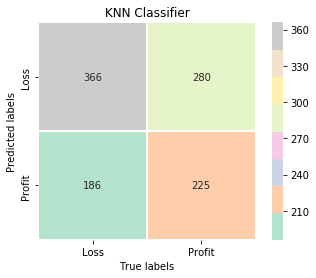

In [378]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 2.2) Only US Movies

In [379]:
movie_df = pd.read_csv(r'data/data_regression_onlyUS.csv')

In [380]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank'])

In [381]:
classification_df

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3004      86.0                     63.0                   175.0   
3005      81.0                     26.0                   300.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3004                   489.0                       1278                   2.0   
3005                  2000.0                       3344                   0.0   
3006                   634.0                       1810                  11.0   

     language content_rating       budget  actor_2_facebook_likes  ...  Crime  \
0     English          PG-13  48000000.00                  1000.0  ...      0   
1     English              R   6000000.00                   573.0  ...      0   
2     English             PG  48671729.12                   816.0  ...      0   
3     English              X   6500000.00                   567.0  ...      0   
4     English             PG   5000000.00                   754.0  ...      0   
...       ...            ...          ...                     ...  ...    ...   
3002  English              R  20000000.00                  1000.0  ...      0   
3003  English              R   5000000.00                   706.0  ...      0   
3004  English      Not Rated    990000.00                   207.0  ...      0   
3005  English          PG-13   4900000.00                   509.0  ...      0   
3006  English             PG   5000000.00                   420.0  ...      0   

      Drama  Romance  Mystery_Thriller_Horror  Sci-Fi_Fantasy  \
0         0        1                        0               1   
1         0        0                        0               0   
2         1        0                        0               0   
3         0        1                        1               0   
4         1        0                        0               0   
...     ...      ...                      ...             ...   
3002      0        0                        0               0   
3003      0        0                        0               0   
3004      1        0                        0               1   
3005      0        0                        1               0   
3006      1        0                        0               0   

      Family_Animation  Action_Adventure  History_War  Others  \
0                    0                 0            0       0   
1                    0                 0            0       1   
2                    0                 0            0       1   
3                    0                 0            0       0   
4                    0                 0            0       0   
...                ...               ...          ...     ...   
3002               

In [382]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'content_rating', 'budget',
       'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'gross_budget_ratio'],
      dtype='object')

In [383]:
classification1_df=classification_df.drop(columns=['language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
2999      92.0                     89.0                   190.0   
3001      97.0                     20.0                   538.0   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
2999                 17000.0                      17860                   0.0   
3001                   741.0                       2849                   1.0   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3006                   634.0                       1810                  11.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
2999  3.500000e+07                   329.0          0       1  ...   
3001  2.178331e+07                   615.0          0       0  ...   
3002  2.000000e+07                  1000.0          0       1  ...   
3003  5.000000e+06                   706.0          0       1  ...   
3006  5.000000e+06                   420.0          0       0  ...   

      Action_Adventure  History_War  Others  gross_budget_ratio  \
0                    0            0       0            0.981155   
2                    0            0       1            1.641610   
3                    0            0       0            4.907538   
4                    0            0       0            5.202173   
6                    0            0       1            2.500307   
...                ...          ...     ...                 ...   
2999                 0            0       0            1.579766   
3001                 1            0       0            1.147809   
3002                 0            0       0            2.773065   
3003                 0            0       0            2.335036   
3006                 0            0       0            4.154614   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0 

## 2.2.1) Without log and feature elimination

## 2.2.1.1) Seperating into 3 classes

In [384]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1259
1     780
2     626
Name: gross_budget_ratio, dtype: int64

In [385]:
df11 = df1.copy()
df11['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [386]:
df11

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
2999      92.0                     89.0                   190.0   
3001      97.0                     20.0                   538.0   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
2999                 17000.0                      17860                   0.0   
3001                   741.0                       2849                   1.0   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3006                   634.0                       1810                  11.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
2999  3.500000e+07                   329.0          0       1  ...   
3001  2.178331e+07                   615.0          0       0  ...   
3002  2.000000e+07                  1000.0          0       1  ...   
3003  5.000000e+06                   706.0          0       1  ...   
3006  5.000000e+06                   420.0          0       0  ...   

      Action_Adventure  History_War  Others  gross_budget_ratio  \
0                    0            0       0                   0   
2                    0            0       1                   1   
3                    0            0       0                   2   
4                    0            0       0                   2   
6                    0            0       1                   2   
...                ...          ...     ...                 ...   
2999                 0            0       0                   1   
3001                 1            0       0                   1   
3002                 0            0       0                   2   
3003                 0            0       0                   2   
3006                 0            0       0                   2   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0 

In [387]:
X = df11.drop(columns=['gross_budget_ratio'])
y = df11['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 25)
Dimensionality of X_test : (800, 25)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 2.2.1.1.1) Multi-Class Logistic Regression

In [388]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [389]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 1, 'penalty': 'l2'}
MLR Train score: 0.43851683692773363
MLR Test score: 0.3975


Text(0.5, 1, 'Multiclass Logistic Regression')

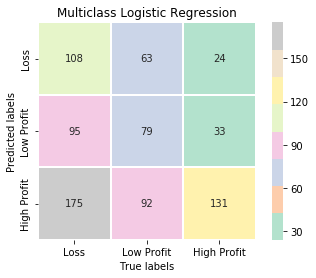

In [390]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 2.2.1.1.2) Decision Tree Classifier

In [391]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.005, 'min_samples_split': 0.1}
DTC Train score: 0.5013404825737265
DTC Test score: 0.49875


Text(0.5, 1, 'Decision Tree Classifier')

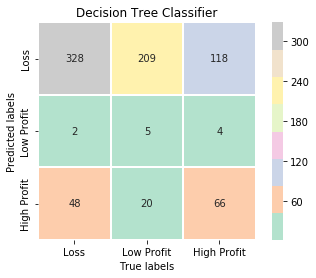

In [392]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.2.1.1.3) Random Forest Classifier

In [393]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.8723860589812332
RFC Test score: 0.50625


Text(0.5, 1, 'Random Forest Classifier')

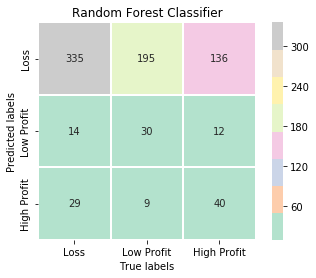

In [394]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.2.1.1.4) KNN Classifier

In [395]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [396]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.4932975871313673
KNN Test score: 0.49125


Text(0.5, 1, 'KNN Classifier')

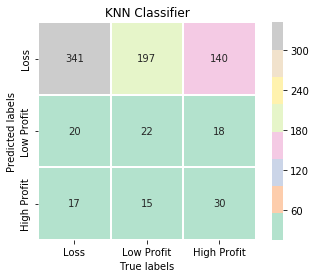

In [397]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 2.2.1.2) Seperating into 2 classes

In [398]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

1    1406
0    1259
Name: gross_budget_ratio, dtype: int64

In [399]:
df12 = df1.copy()
df12['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [400]:
X = df12.drop(columns=['gross_budget_ratio'])
y = df12['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 25)
Dimensionality of X_test : (800, 25)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 2.2.1.2.1) Logistic Regression

In [401]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 100, 'penalty': 'l1'}
LR Train score: 0.5119182746878547
LR Test score: 0.5211640211640212
LR Test Accuracy score: 0.59625


Text(0.5, 1, 'Logistic Regression')

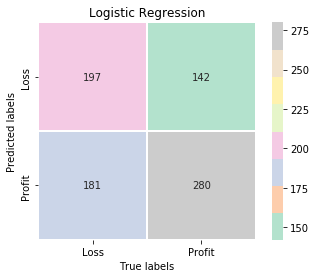

In [402]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 2.2.1.2.2) Decision Tree Classifier

In [403]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.005, 'min_samples_split': 0.1}
DTC Train score: 0.6515323496027242
DTC Test score: 0.5502645502645502
DTC Test Accuracy score: 0.54


Text(0.5, 1, 'Decision Tree Classifier')

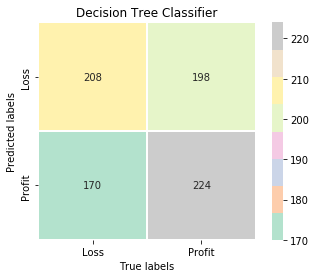

In [404]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.2.1.2.3) Random Forest Classifier

In [405]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 50}
RFC Train score: 1.0
RFC Test score: 0.5343915343915344
RFC Test Accuracy score: 0.595


Text(0.5, 1, 'Random Forest Classifier')

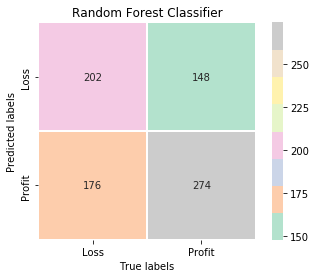

In [406]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.2.1.2.4) KNN Classifier

In [407]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [408]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.6799091940976163
KNN Test score: 0.5740740740740741
KNN Test Accuracy score: 0.5575


Text(0.5, 1, 'KNN Classifier')

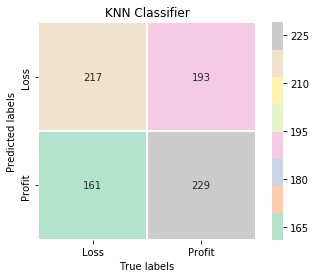

In [409]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 2.2.2) With taking log and feature elimination

### log

In [410]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [411]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'gross_budget_ratio', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R', 'content_rating_TV-14',
       'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [412]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

## 2.2.2.1) Seperating into 3 classes

In [413]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1259
1     780
2     626
Name: gross_budget_ratio, dtype: int64

In [414]:
df21 = df2.copy()
df21['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [415]:
df21

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                 6.100319                6.710523   
2        124.0                 5.010635                6.349139   
3        104.0                 0.000000                6.248043   
4        124.0                 0.000000                6.113682   
6        100.0                 5.976351                6.543912   
...        ...                      ...                     ...   
2999      92.0                 4.488636                5.247024   
3001      97.0                 2.995732                6.287859   
3002     100.0                 3.178054                6.746412   
3003      92.0                 4.488636                5.872118   
3006     120.0                 2.890372                5.686975   

      actor_1_facebook_likes  cast_total_facebook_likes     budget  \
0                   9.903488                  10.008253  17.686712   
2                   6.773080                   7.888710  17.700609   
3                   6.625392                   7.800573  15.687313   
4                   9.392662                   9.537051  15.424948   
6                   7.600902                   8.747670  16.118096   
...                      ...                        ...        ...   
2999                9.740969                   9.790319  17.370859   
3001                6.608001                   7.954723  16.896655   
3002                9.615805                   9.840867  16.811243   
3003                6.591674                   7.954372  15.424948   
3006                6.452049                   7.501082  15.424948   

      actor_2_facebook_likes  Comedy  Drama  Romance  Family_Animation  \
0                   6.907755       1      0        1                 0   
2                   6.704414       0      1        0                 0   
3                   6.340359       0      0        1                 0   
4                   6.625392       0      1        0                 0   
6                   6.830874       0      0        0                 0   
...                      ...     ...    ...      ...               ...   
2999                5.796058       1      0        0                 0   
3001                6.421622       0      0        0                 0   
3002                6.907755       1      0        0                 0   
3003                6.559615       1      0        0                 0   
3006                6.040255       0      1        0                 0   

      Action_Adventure  Others  gross_budget_ratio  content_rating_PG  \
0                    0       0                   0                  0   
2                    0       1                   1                  1   
3                    0       0                   2                  0   
4                    0       0                   2                  1   
6                    0       1                   2                  0   
...                ...     ...                 ...                ...   
2999                 0       0                   1                  0   
3001                 1       0                   1                  0   
3002                 0       0                   2                  0   
3003                 0       0                   2                  0   
3006                 0       0                   2                  1   

      content_rating_PG-13  content_rating_R  content_rating_TV-14  \
0                        1                 0                     0   
2                        0                 0                     0   
3                        0                 0                     0   
4                        0                 0                     0   
6                        0                 1                     0   
...                    ...               ...                   ...   
2999                     0                 1                     0   
3001                     0        

In [416]:
X = df21.drop(columns=['gross_budget_ratio'])
y = df21['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 19)
Dimensionality of X_test : (800, 19)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 2.2.2.1.1) Multi-Class Logistic Regression

In [417]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [418]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 0.1, 'penalty': 'l2'}
MLR Train score: 0.5081346954218691
MLR Test score: 0.42875


Text(0.5, 1, 'Multiclass Logistic Regression')

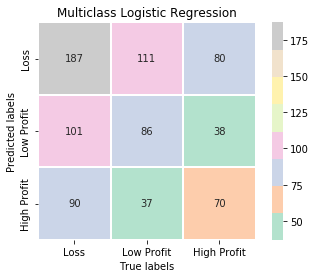

In [419]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 2.2.2.1.2) Decision Tree Classifier

In [420]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.001}
DTC Train score: 0.5093833780160858
DTC Test score: 0.48875


Text(0.5, 1, 'Decision Tree Classifier')

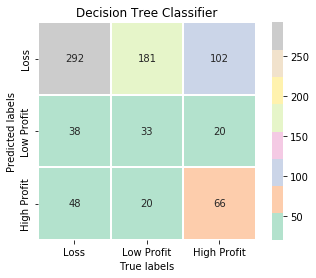

In [421]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.2.2.1.3) Random Forest Classifier

In [422]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.8734584450402145
RFC Test score: 0.5


Text(0.5, 1, 'Random Forest Classifier')

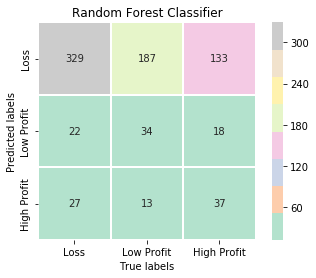

In [423]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.2.2.1.4) KNN Classifier

In [424]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [425]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.4857908847184987
KNN Test score: 0.45375


Text(0.5, 1, 'KNN Classifier')

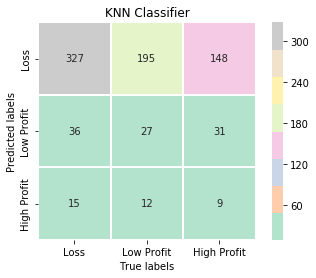

In [426]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 2.2.2.2) Seperating into 2 classes

In [427]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

1    1406
0    1259
Name: gross_budget_ratio, dtype: int64

In [428]:
df22 = df2.copy()
df22['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [429]:
X = df22.drop(columns=['gross_budget_ratio'])
y = df22['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 19)
Dimensionality of X_test : (800, 19)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 2.2.2.2.1) Logistic Regression

In [430]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 1000, 'penalty': 'l2'}
LR Train score: 0.4619750283768445
LR Test score: 0.4444444444444444
LR Test Accuracy score: 0.5775


Text(0.5, 1, 'Logistic Regression')

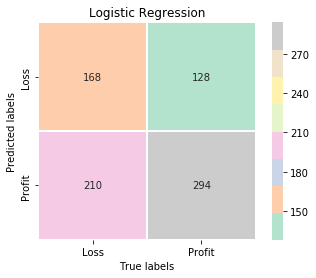

In [431]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 2.2.2.2.2) Decision Tree Classifier

In [432]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 0.005, 'min_samples_split': 0.1}
DTC Train score: 0.6662883087400681
DTC Test score: 0.5740740740740741
DTC Test Accuracy score: 0.53875


Text(0.5, 1, 'Decision Tree Classifier')

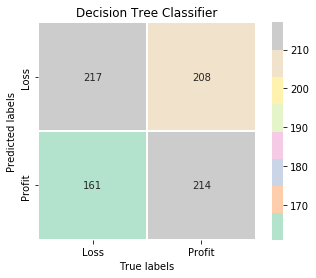

In [433]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 2.2.2.2.3) Random Forest Classifier

In [434]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 50}
RFC Train score: 1.0
RFC Test score: 0.5185185185185185
RFC Test Accuracy score: 0.5825


Text(0.5, 1, 'Random Forest Classifier')

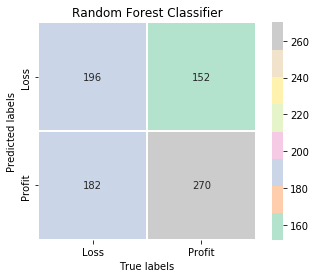

In [435]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 2.2.2.2.4) KNN Classifier

In [436]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [437]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.656072644721907
KNN Test score: 0.5476190476190477
KNN Test Accuracy score: 0.54625


Text(0.5, 1, 'KNN Classifier')

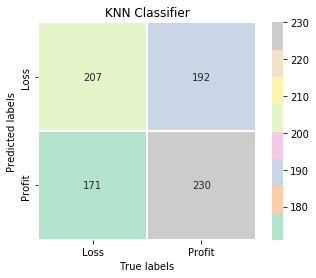

In [438]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

# 3) Only Ranks

In [439]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [440]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes'])

In [441]:
classification_df

duration  cast_total_facebook_likes  facenumber_in_poster language  \
0        123.0                      22209                   1.0  English   
1         98.0                      14921                   3.0  English   
2        124.0                       2667                   0.0  English   
3        104.0                       2442                   0.0  English   
4        124.0                      13864                   1.0  English   
...        ...                        ...                   ...      ...   
3961      86.0                       1278                   2.0  English   
3962      81.0                       3344                   0.0  English   
3963     120.0                       1810                  11.0  English   
3964     102.0                        553                   2.0   French   
3965     156.0                         50                   0.0   Korean   

          country content_rating        budget  Biography  Comedy  Crime  ...  \
0             USA          PG-13  4.800000e+07          0       1      0  ...   
1             USA              R  6.000000e+06          0       1      0  ...   
2             USA             PG  4.867173e+07          1       0      0  ...   
3             USA              X  6.500000e+06          0       0      0  ...   
4             USA             PG  5.000000e+06          1       0      0  ...   
...           ...            ...           ...        ...     ...    ...  ...   
3961          USA      Not Rated  9.900000e+05          0       1      0  ...   
3962          USA          PG-13  4.900000e+06          0       0      0  ...   
3963          USA             PG  5.000000e+06          0       0      0  ...   
3964       France      Not Rated  2.178331e+07          0       1      0  ...   
3965  South Korea      Not Rated  2.816008e+07          0       0      0  ...   

      Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  Others  \
0                  1                 0                 0            0       0   
1                  0                 0                 0            0       1   
2                  0                 0                 0            0       1   
3                  0                 0                 0            0       0   
4                  0                 0                 0            0       0   
...              ...               ...               ...          ...     ...   
3961               1                 0                 1            0       0   
3962               0                 0                 0            0       0   
3963               0                 0                 0            0       0   
3964               0                 0                 0            0       0   
3965               1                 0                 0            0       0   

      director_rank  actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0                 5            6            3            5            0.981155  
1                 3            7            3            5            6.633333  
2                 4            3            4            4            1.641610  
3                 3            2            3            4            4.907538  
4                 4            6            4            5            5.202173  
...             ...          ...          ...          ...                 ...  
3961              3            3            2            4           25.255628  
3962              3            3            3            5           11.537962  
3963              1            2            3            4            4.154614  
3964              3            2            1            1            1.147809  
3965              4            1            1            0            0.027366  

[3966 rows x 23 columns]

In [442]:
classification_df.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'language', 'country', 'content_rating', 'budget', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

## 3.1) All Movies

In [443]:
classification1_df=classification_df.drop(columns=['country','language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  cast_total_facebook_likes  facenumber_in_poster        budget  \
0        123.0                      22209                   1.0  4.800000e+07   
2        124.0                       2667                   0.0  4.867173e+07   
3        104.0                       2442                   0.0  6.500000e+06   
4        124.0                      13864                   1.0  5.000000e+06   
6        100.0                       6296                   0.0  1.000000e+07   
...        ...                        ...                   ...           ...   
3959     100.0                      18786                   9.0  2.000000e+07   
3960      92.0                       2848                   4.0  5.000000e+06   
3963     120.0                       1810                  11.0  5.000000e+06   
3964     102.0                        553                   2.0  2.178331e+07   
3965     156.0                         50                   0.0  2.816008e+07   

      Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  ...  \
0             0       1      0      0        1                        0  ...   
2             1       0      0      1        0                        0  ...   
3             0       0      0      0        1                        1  ...   
4             1       0      0      1        0                        0  ...   
6             0       0      0      0        0                        0  ...   
...         ...     ...    ...    ...      ...                      ...  ...   
3959          0       1      0      0        0                        0  ...   
3960          0       1      0      0        0                        0  ...   
3963          0       0      0      1        0                        0  ...   
3964          0       1      0      1        0                        0  ...   
3965          0       0      0      0        0                        1  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
3959            5            5            5            2.773065   
3960            2            4            5            2.335036   
3963            2            3            4            4.154614   
3964            2            1            1            1.147809   
3965            1            1            0            0.027366   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0                 1   
3963                  1                     0                 0   
3964                  0                     0                 0   
3965                  0                     0                 0   

      content_rating_TV-14  content_rating_TV-G  content_rating_TV-PG  
0                        0                    0                     0  
2                        0                    0                     0  
3                        0                    0                     0  
4                        0                    0                     0  
6                        0                    0                     0  
...                    ...    

## 3.1.1) Without log and feature elimination

## 3.1.1.1) Seperating into 3 classes

In [444]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1     937
2     745
Name: gross_budget_ratio, dtype: int64

In [445]:
df11 = df1.copy()
df11['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [446]:
df11

duration  cast_total_facebook_likes  facenumber_in_poster        budget  \
0        123.0                      22209                   1.0  4.800000e+07   
2        124.0                       2667                   0.0  4.867173e+07   
3        104.0                       2442                   0.0  6.500000e+06   
4        124.0                      13864                   1.0  5.000000e+06   
6        100.0                       6296                   0.0  1.000000e+07   
...        ...                        ...                   ...           ...   
3959     100.0                      18786                   9.0  2.000000e+07   
3960      92.0                       2848                   4.0  5.000000e+06   
3963     120.0                       1810                  11.0  5.000000e+06   
3964     102.0                        553                   2.0  2.178331e+07   
3965     156.0                         50                   0.0  2.816008e+07   

      Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  ...  \
0             0       1      0      0        1                        0  ...   
2             1       0      0      1        0                        0  ...   
3             0       0      0      0        1                        1  ...   
4             1       0      0      1        0                        0  ...   
6             0       0      0      0        0                        0  ...   
...         ...     ...    ...    ...      ...                      ...  ...   
3959          0       1      0      0        0                        0  ...   
3960          0       1      0      0        0                        0  ...   
3963          0       0      0      1        0                        0  ...   
3964          0       1      0      1        0                        0  ...   
3965          0       0      0      0        0                        1  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5                   0   
2               3            4            4                   1   
3               2            3            4                   2   
4               6            4            5                   2   
6               5            3            6                   2   
...           ...          ...          ...                 ...   
3959            5            5            5                   2   
3960            2            4            5                   2   
3963            2            3            4                   2   
3964            2            1            1                   1   
3965            1            1            0                   0   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0                 1   
3963                  1                     0                 0   
3964                  0                     0                 0   
3965                  0                     0                 0   

      content_rating_TV-14  content_rating_TV-G  content_rating_TV-PG  
0                        0                    0                     0  
2                        0                    0                     0  
3                        0                    0                     0  
4                        0                    0                     0  
6                        0                    0                     0  
...                    ...    

In [447]:
X = df11.drop(columns=['gross_budget_ratio'])
y = df11['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 25)
Dimensionality of X_test : (1057, 25)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 3.1.1.1.1) Multi-Class Logistic Regression

In [448]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [449]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 10, 'penalty': 'l2'}
MLR Train score: 0.5161623997931213
MLR Test score: 0.4314096499526963


Text(0.5, 1, 'Multiclass Logistic Regression')

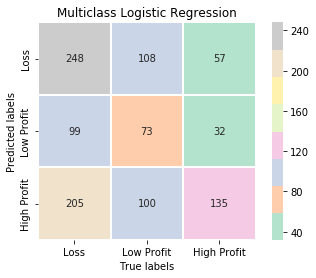

In [450]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 3.1.1.1.2) Decision Tree Classifier

In [451]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.025, 'min_samples_split': 0.001}
DTC Train score: 0.5656934306569343
DTC Test score: 0.5165562913907285


Text(0.5, 1, 'Decision Tree Classifier')

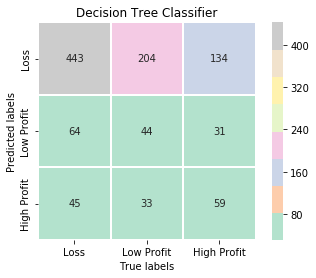

In [452]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.1.1.1.3) Random Forest Classifier

In [453]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
RFC Train score: 0.8236009732360098
RFC Test score: 0.5449385052034059


Text(0.5, 1, 'Random Forest Classifier')

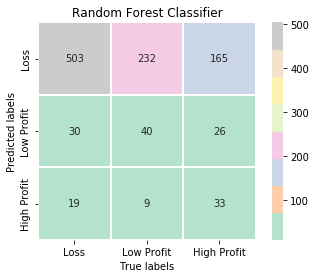

In [454]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.1.1.1.4) KNN Classifier

In [455]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [456]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 20}
KNN Train score: 0.5669099756690997
KNN Test score: 0.5137180700094608


Text(0.5, 1, 'KNN Classifier')

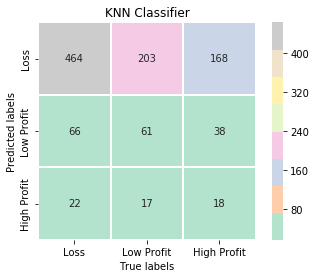

In [457]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 3.1.1.2) Seperating into 2 classes

In [458]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1    1682
Name: gross_budget_ratio, dtype: int64

In [459]:
df12 = df1.copy()
df12['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [460]:
X = df12.drop(columns=['gross_budget_ratio'])
y = df12['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 25)
Dimensionality of X_test : (1057, 25)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 3.1.1.2.1) Logistic Regression

In [461]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 0.01, 'penalty': 'l1'}
LR Train score: 0.7874321179208689
LR Test score: 0.7789855072463768
LR Test Accuracy score: 0.5193945127719962


Text(0.5, 1, 'Logistic Regression')

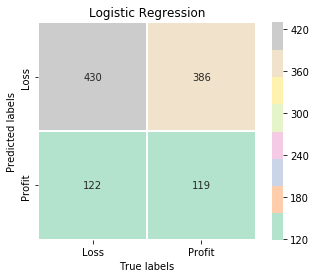

In [462]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 3.1.1.2.2) Decision Tree Classifier

In [463]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.5, 'min_samples_split': 0.001}
DTC Train score: 0.5376260667183863
DTC Test score: 0.5307971014492754
DTC Test Accuracy score: 0.5477767265846736


Text(0.5, 1, 'Decision Tree Classifier')

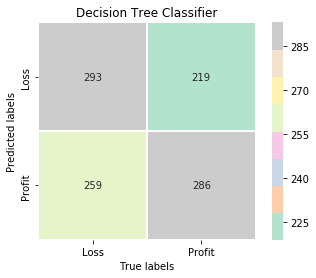

In [464]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.1.1.2.3) Random Forest Classifier

In [465]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.939487975174554
RFC Test score: 0.6557971014492754
RFC Test Accuracy score: 0.6206244087038789


Text(0.5, 1, 'Random Forest Classifier')

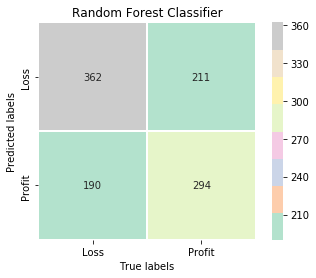

In [466]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.1.1.2.4) KNN Classifier

In [467]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [468]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.773467804499612
KNN Test score: 0.6793478260869565
KNN Test Accuracy score: 0.5761589403973509


Text(0.5, 1, 'KNN Classifier')

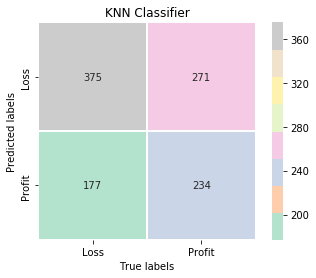

In [469]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 3.1.2) With taking log and feature elimination

### log

In [470]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [471]:
df2.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank', 'gross_budget_ratio',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R',
       'content_rating_TV-14', 'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [472]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

## 3.1.2.1) Seperating into 3 classes

In [473]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1     937
2     745
Name: gross_budget_ratio, dtype: int64

In [474]:
df21 = df2.copy()
df21['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [475]:
df21

duration  cast_total_facebook_likes     budget  Comedy  Drama  Romance  \
0        123.0                  10.008253  17.686712       1      0        1   
2        124.0                   7.888710  17.700609       0      1        0   
3        104.0                   7.800573  15.687313       0      0        1   
4        124.0                   9.537051  15.424948       0      1        0   
6        100.0                   8.747670  16.118096       0      0        0   
...        ...                        ...        ...     ...    ...      ...   
3959     100.0                   9.840867  16.811243       1      0        0   
3960      92.0                   7.954372  15.424948       1      0        0   
3963     120.0                   7.501082  15.424948       0      1        0   
3964     102.0                   6.315358  16.896655       1      1        0   
3965     156.0                   3.912023  17.153416       0      0        0   

      Family_Animation  Action_Adventure  Others  director_rank  actor1_rank  \
0                    0                 0       0              5            6   
2                    0                 0       1              4            3   
3                    0                 0       0              3            2   
4                    0                 0       0              4            6   
6                    0                 0       1              3            5   
...                ...               ...     ...            ...          ...   
3959                 0                 0       0              4            5   
3960                 0                 0       0              3            2   
3963                 0                 0       0              1            2   
3964                 0                 0       0              3            2   
3965                 0                 0       0              4            1   

      actor2_rank  actor3_rank  gross_budget_ratio  content_rating_PG  \
0               3            5                   0                  0   
2               4            4                   1                  1   
3               3            4                   2                  0   
4               4            5                   2                  1   
6               3            6                   2                  0   
...           ...          ...                 ...                ...   
3959            5            5                   2                  0   
3960            4            5                   2                  0   
3963            3            4                   2                  1   
3964            1            1                   1                  0   
3965            1            0                   0                  0   

      content_rating_PG-13  content_rating_R  content_rating_TV-14  \
0                        1                 0                     0   
2                        0                 0                     0   
3                        0                 0                     0   
4                        0                 0                     0   
6                        0                 1                     0   
...                    ...               ...                   ...   
3959                     0                 1                     0   
3960                     0                 1                     0   
3963                     0                 0                     0   
3964                     0                 0                     0   
3965                     0                 0                     0   

      content_rating_TV-G  content_rating_TV-PG  
0                       0                     0  
2                       0                     0  
3                       0                     0  
4                       0                     0  
6                       0                     0  
...                   ...                   ...  
3959            

In [476]:
X = df21.drop(columns=['gross_budget_ratio'])
y = df21['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 19)
Dimensionality of X_test : (1057, 19)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 3.1.2.1.1) Multi-Class Logistic Regression

In [477]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [478]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 10, 'penalty': 'l2'}
MLR Train score: 0.5234031549004396
MLR Test score: 0.46263008514664145


Text(0.5, 1, 'Multiclass Logistic Regression')

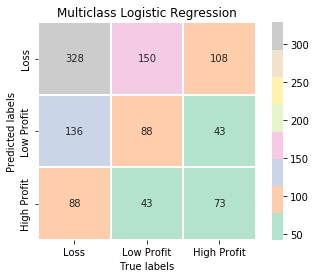

In [479]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 3.1.2.1.2) Decision Tree Classifier

In [480]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 0.025, 'min_samples_split': 0.001}
DTC Train score: 0.5624493106244931
DTC Test score: 0.5156102175969726


Text(0.5, 1, 'Decision Tree Classifier')

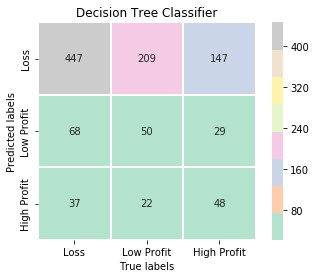

In [481]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.1.2.1.3) Random Forest Classifier

In [482]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
RFC Train score: 0.8223844282238443
RFC Test score: 0.5241248817407758


Text(0.5, 1, 'Random Forest Classifier')

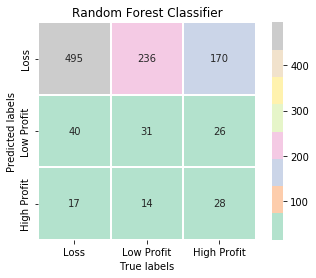

In [483]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.1.2.1.4) KNN Classifier

In [484]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [485]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.5381184103811841
KNN Test score: 0.522232734153264


Text(0.5, 1, 'KNN Classifier')

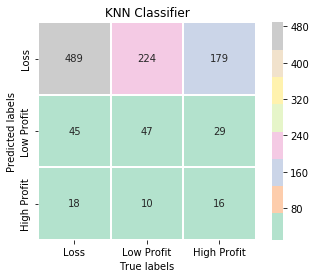

In [486]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 3.1.2.2) Seperating into 2 classes

In [487]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1841
1    1682
Name: gross_budget_ratio, dtype: int64

In [488]:
df22 = df2.copy()
df22['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [489]:
X = df22.drop(columns=['gross_budget_ratio'])
y = df22['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 19)
Dimensionality of X_test : (1057, 19)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 3.1.2.2.1) Logistic Regression

In [490]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 0.001, 'penalty': 'l1'}
LR Train score: 1.0
LR Test score: 1.0
LR Test Accuracy score: 0.522232734153264


Text(0.5, 1, 'Logistic Regression')

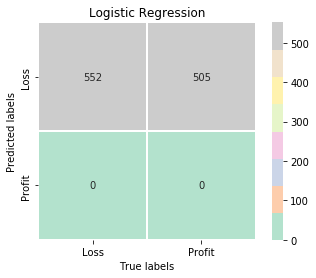

In [491]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 3.1.2.2.2) Decision Tree Classifier

In [492]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 0.5, 'min_samples_split': 0.001}
DTC Train score: 0.5376260667183863
DTC Test score: 0.5307971014492754
DTC Test Accuracy score: 0.5477767265846736


Text(0.5, 1, 'Decision Tree Classifier')

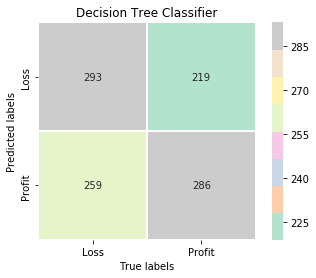

In [493]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.1.2.2.3) Random Forest Classifier

In [494]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.9030256012412723
RFC Test score: 0.6467391304347826
RFC Test Accuracy score: 0.6140018921475875


Text(0.5, 1, 'Random Forest Classifier')

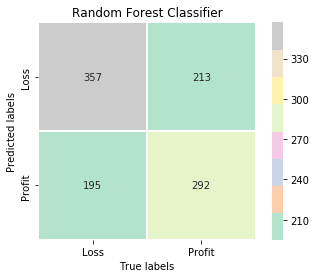

In [495]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.1.2.2.4) KNN Classifier

In [496]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [497]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.7897595034910784
KNN Test score: 0.6920289855072463
KNN Test Accuracy score: 0.5648060548722801


Text(0.5, 1, 'KNN Classifier')

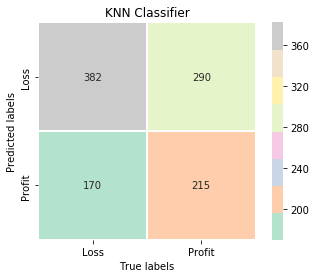

In [498]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 3.2) Only US Movies

In [499]:
movie_df = pd.read_csv(r'data/data_regression_onlyUS.csv')

In [500]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes'])

In [501]:
classification_df

duration  cast_total_facebook_likes  facenumber_in_poster language  \
0        123.0                      22209                   1.0  English   
1         98.0                      14921                   3.0  English   
2        124.0                       2667                   0.0  English   
3        104.0                       2442                   0.0  English   
4        124.0                      13864                   1.0  English   
...        ...                        ...                   ...      ...   
3002     100.0                      18786                   9.0  English   
3003      92.0                       2848                   4.0  English   
3004      86.0                       1278                   2.0  English   
3005      81.0                       3344                   0.0  English   
3006     120.0                       1810                  11.0  English   

     content_rating       budget  Biography  Comedy  Crime  Drama  ...  \
0             PG-13  48000000.00          0       1      0      0  ...   
1                 R   6000000.00          0       1      0      0  ...   
2                PG  48671729.12          1       0      0      1  ...   
3                 X   6500000.00          0       0      0      0  ...   
4                PG   5000000.00          1       0      0      1  ...   
...             ...          ...        ...     ...    ...    ...  ...   
3002              R  20000000.00          0       1      0      0  ...   
3003              R   5000000.00          0       1      0      0  ...   
3004      Not Rated    990000.00          0       1      0      1  ...   
3005          PG-13   4900000.00          0       0      0      0  ...   
3006             PG   5000000.00          0       0      0      1  ...   

      Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  Others  \
0                  1                 0                 0            0       0   
1                  0                 0                 0            0       1   
2                  0                 0                 0            0       1   
3                  0                 0                 0            0       0   
4                  0                 0                 0            0       0   
...              ...               ...               ...          ...     ...   
3002               0                 0                 0            0       0   
3003               0                 0                 0            0       0   
3004               1                 0                 1            0       0   
3005               0                 0                 0            0       0   
3006               0                 0                 0            0       0   

      director_rank  actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0                 5            6            3            5            0.981155  
1                 3            7            3            5            6.633333  
2                 4            3            4            4            1.641610  
3                 3            2            3            4            4.907538  
4                 4            6            4            5            5.202173  
...             ...          ...          ...          ...                 ...  
3002              4            5            5            5            2.773065  
3003              3            2            4            5            2.335036  
3004              3            3            2            4           25.255628  
3005              3            3            3            5           11.537962  
3006              1            2            3            4            4.154614  

[3007 rows x 22 columns]

In [502]:
classification_df.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'language', 'content_rating', 'budget', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

In [503]:
classification1_df=classification_df.drop(columns=['language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  cast_total_facebook_likes  facenumber_in_poster        budget  \
0        123.0                      22209                   1.0  4.800000e+07   
2        124.0                       2667                   0.0  4.867173e+07   
3        104.0                       2442                   0.0  6.500000e+06   
4        124.0                      13864                   1.0  5.000000e+06   
6        100.0                       6296                   0.0  1.000000e+07   
...        ...                        ...                   ...           ...   
2999      92.0                      17860                   0.0  3.500000e+07   
3001      97.0                       2849                   1.0  2.178331e+07   
3002     100.0                      18786                   9.0  2.000000e+07   
3003      92.0                       2848                   4.0  5.000000e+06   
3006     120.0                       1810                  11.0  5.000000e+06   

      Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  ...  \
0             0       1      0      0        1                        0  ...   
2             1       0      0      1        0                        0  ...   
3             0       0      0      0        1                        1  ...   
4             1       0      0      1        0                        0  ...   
6             0       0      0      0        0                        0  ...   
...         ...     ...    ...    ...      ...                      ...  ...   
2999          0       1      0      0        0                        0  ...   
3001          0       0      0      0        0                        1  ...   
3002          0       1      0      0        0                        0  ...   
3003          0       1      0      0        0                        0  ...   
3006          0       0      0      1        0                        0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
2999            5            3            4            1.579766   
3001            2            3            4            1.147809   
3002            5            5            5            2.773065   
3003            2            4            5            2.335036   
3006            2            3            4            4.154614   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0                 0   
3002                  0                     0                 1   
3003                  0                     0                 1   
3006                  1                     0                 0   

      content_rating_TV-14  content_rating_TV-G  content_rating_TV-PG  
0                        0                    0                     0  
2                        0                    0                     0  
3                        0                    0                     0  
4                        0                    0                     0  
6                        0                    0                     0  
...                    ...    

## 3.2.1) Without log and feature elimination

## 3.2.1.1) Seperating into 3 classes

In [504]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1259
1     780
2     626
Name: gross_budget_ratio, dtype: int64

In [505]:
df11 = df1.copy()
df11['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [506]:
df11

duration  cast_total_facebook_likes  facenumber_in_poster        budget  \
0        123.0                      22209                   1.0  4.800000e+07   
2        124.0                       2667                   0.0  4.867173e+07   
3        104.0                       2442                   0.0  6.500000e+06   
4        124.0                      13864                   1.0  5.000000e+06   
6        100.0                       6296                   0.0  1.000000e+07   
...        ...                        ...                   ...           ...   
2999      92.0                      17860                   0.0  3.500000e+07   
3001      97.0                       2849                   1.0  2.178331e+07   
3002     100.0                      18786                   9.0  2.000000e+07   
3003      92.0                       2848                   4.0  5.000000e+06   
3006     120.0                       1810                  11.0  5.000000e+06   

      Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  ...  \
0             0       1      0      0        1                        0  ...   
2             1       0      0      1        0                        0  ...   
3             0       0      0      0        1                        1  ...   
4             1       0      0      1        0                        0  ...   
6             0       0      0      0        0                        0  ...   
...         ...     ...    ...    ...      ...                      ...  ...   
2999          0       1      0      0        0                        0  ...   
3001          0       0      0      0        0                        1  ...   
3002          0       1      0      0        0                        0  ...   
3003          0       1      0      0        0                        0  ...   
3006          0       0      0      1        0                        0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5                   0   
2               3            4            4                   1   
3               2            3            4                   2   
4               6            4            5                   2   
6               5            3            6                   2   
...           ...          ...          ...                 ...   
2999            5            3            4                   1   
3001            2            3            4                   1   
3002            5            5            5                   2   
3003            2            4            5                   2   
3006            2            3            4                   2   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0                 0   
3002                  0                     0                 1   
3003                  0                     0                 1   
3006                  1                     0                 0   

      content_rating_TV-14  content_rating_TV-G  content_rating_TV-PG  
0                        0                    0                     0  
2                        0                    0                     0  
3                        0                    0                     0  
4                        0                    0                     0  
6                        0                    0                     0  
...                    ...    

In [507]:
X = df11.drop(columns=['gross_budget_ratio'])
y = df11['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 25)
Dimensionality of X_test : (800, 25)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 3.2.1.1.1) Multi-Class Logistic Regression

In [508]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [509]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 0.001, 'penalty': 'none'}
MLR Train score: 0.48429814604615967
MLR Test score: 0.39375


Text(0.5, 1, 'Multiclass Logistic Regression')

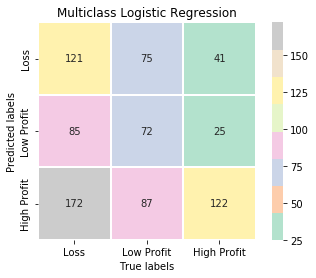

In [510]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 3.2.1.1.2) Decision Tree Classifier

In [511]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 0.025, 'min_samples_split': 0.1}
DTC Train score: 0.503485254691689
DTC Test score: 0.49875


Text(0.5, 1, 'Decision Tree Classifier')

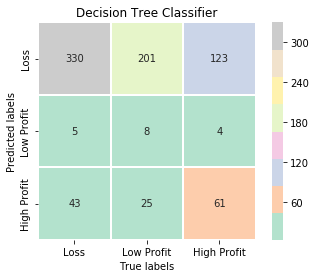

In [512]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.2.1.1.3) Random Forest Classifier

In [513]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
RFC Train score: 0.8750670241286863
RFC Test score: 0.5


Text(0.5, 1, 'Random Forest Classifier')

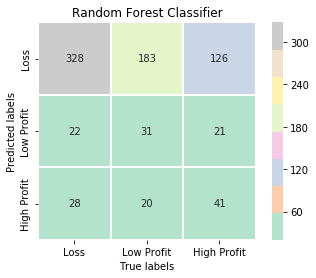

In [514]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.2.1.1.4) KNN Classifier

In [515]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [516]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.48954423592493296
KNN Test score: 0.47625


Text(0.5, 1, 'KNN Classifier')

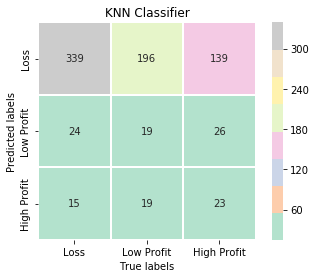

In [517]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 3.2.1.2) Seperating into 2 classes

In [518]:
RatioClass = df1['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

1    1406
0    1259
Name: gross_budget_ratio, dtype: int64

In [519]:
df12 = df1.copy()
df12['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [520]:
X = df12.drop(columns=['gross_budget_ratio'])
y = df12['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 25)
Dimensionality of X_test : (800, 25)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 3.2.1.2.1) Logistic Regression

In [521]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 1000, 'penalty': 'l1'}
LR Train score: 0.5255391600454029
LR Test score: 0.5370370370370371
LR Test Accuracy score: 0.62125


Text(0.5, 1, 'Logistic Regression')

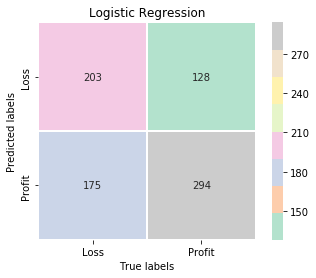

In [522]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 3.2.1.2.2) Decision Tree Classifier

In [523]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 0.005, 'min_samples_split': 0.001}
DTC Train score: 0.7332576617480137
DTC Test score: 0.5158730158730159
DTC Test Accuracy score: 0.535


Text(0.5, 1, 'Decision Tree Classifier')

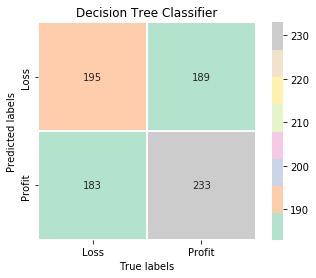

In [524]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.2.1.2.3) Random Forest Classifier

In [525]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 25}
RFC Train score: 1.0
RFC Test score: 0.5264550264550265
RFC Test Accuracy score: 0.62


Text(0.5, 1, 'Random Forest Classifier')

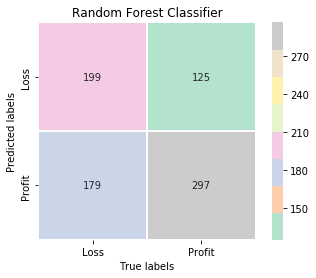

In [526]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.2.1.2.4) KNN Classifier

In [527]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [528]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.6753688989784336
KNN Test score: 0.5317460317460317
KNN Test Accuracy score: 0.55125


Text(0.5, 1, 'KNN Classifier')

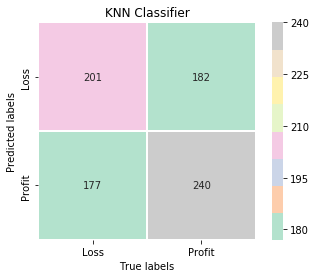

In [529]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 3.2.2) With taking log and feature elimination

### log

In [530]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [531]:
df2.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank', 'gross_budget_ratio',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R',
       'content_rating_TV-14', 'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [532]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

## 3.2.2.1) Seperating into 3 classes

In [533]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else (1 if x <= 2 else 2))
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

0    1259
1     780
2     626
Name: gross_budget_ratio, dtype: int64

In [534]:
df21 = df2.copy()
df21['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [535]:
df21

duration  cast_total_facebook_likes     budget  Comedy  Drama  Romance  \
0        123.0                  10.008253  17.686712       1      0        1   
2        124.0                   7.888710  17.700609       0      1        0   
3        104.0                   7.800573  15.687313       0      0        1   
4        124.0                   9.537051  15.424948       0      1        0   
6        100.0                   8.747670  16.118096       0      0        0   
...        ...                        ...        ...     ...    ...      ...   
2999      92.0                   9.790319  17.370859       1      0        0   
3001      97.0                   7.954723  16.896655       0      0        0   
3002     100.0                   9.840867  16.811243       1      0        0   
3003      92.0                   7.954372  15.424948       1      0        0   
3006     120.0                   7.501082  15.424948       0      1        0   

      Family_Animation  Action_Adventure  Others  director_rank  actor1_rank  \
0                    0                 0       0              5            6   
2                    0                 0       1              4            3   
3                    0                 0       0              3            2   
4                    0                 0       0              4            6   
6                    0                 0       1              3            5   
...                ...               ...     ...            ...          ...   
2999                 0                 0       0              5            5   
3001                 0                 1       0              1            2   
3002                 0                 0       0              4            5   
3003                 0                 0       0              3            2   
3006                 0                 0       0              1            2   

      actor2_rank  actor3_rank  gross_budget_ratio  content_rating_PG  \
0               3            5                   0                  0   
2               4            4                   1                  1   
3               3            4                   2                  0   
4               4            5                   2                  1   
6               3            6                   2                  0   
...           ...          ...                 ...                ...   
2999            3            4                   1                  0   
3001            3            4                   1                  0   
3002            5            5                   2                  0   
3003            4            5                   2                  0   
3006            3            4                   2                  1   

      content_rating_PG-13  content_rating_R  content_rating_TV-14  \
0                        1                 0                     0   
2                        0                 0                     0   
3                        0                 0                     0   
4                        0                 0                     0   
6                        0                 1                     0   
...                    ...               ...                   ...   
2999                     0                 1                     0   
3001                     0                 0                     0   
3002                     0                 1                     0   
3003                     0                 1                     0   
3006                     0                 0                     0   

      content_rating_TV-G  content_rating_TV-PG  
0                       0                     0  
2                       0                     0  
3                       0                     0  
4                       0                     0  
6                       0                     0  
...                   ...                   ...  
2999            

In [536]:
X = df21.drop(columns=['gross_budget_ratio'])
y = df21['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 19)
Dimensionality of X_test : (800, 19)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 3.2.2.1.1) Multi-Class Logistic Regression

In [537]:
smote=SMOTE('minority')
X_s, y_s = smote.fit_sample(X_train,y_train)
X_sm, y_sm = smote.fit_sample(X_s,y_s)
X_sm_train, y_sm_train = shuffle(X_sm, y_sm, random_state=10)

In [538]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l2','none']
parameters = {'C': C_List,'penalty':penalty}
MLR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf1 = GridSearchCV(MLR, parameters, cv=5, verbose=0,scoring ='accuracy')
clf1.fit(X_sm_train, y_sm_train)

y_pred = clf1.predict(X_test)
print("MLR best parameters:", clf1.best_params_)
print("MLR Train score:", clf1.score(X_sm_train, y_sm_train))
print("MLR Test score:", clf1.score(X_test, y_test))

MLR best parameters: {'C': 0.1, 'penalty': 'l2'}
MLR Train score: 0.49867574725690506
MLR Test score: 0.45


Text(0.5, 1, 'Multiclass Logistic Regression')

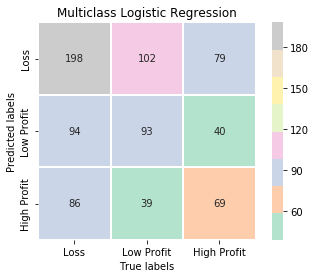

In [539]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Multiclass Logistic Regression')

### 3.2.2.1.2) Decision Tree Classifier

In [540]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))

DTC best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.1}
DTC Train score: 0.5077747989276139
DTC Test score: 0.50625


Text(0.5, 1, 'Decision Tree Classifier')

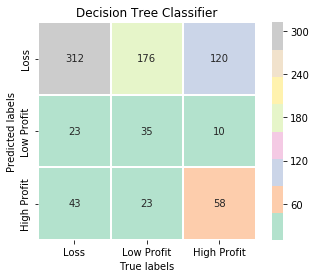

In [541]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.2.2.1.3) Random Forest Classifier

In [542]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}
RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))

RFC best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
RFC Train score: 0.8557640750670241
RFC Test score: 0.50375


Text(0.5, 1, 'Random Forest Classifier')

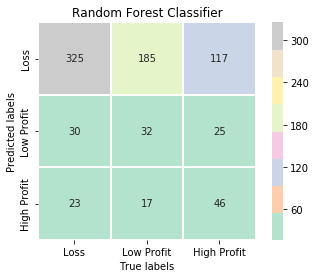

In [543]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.2.2.1.4) KNN Classifier

In [544]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [545]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring ='accuracy')
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))

KNN best parameters: {'n_neighbors': 50}
KNN Train score: 0.4906166219839142
KNN Test score: 0.4575


Text(0.5, 1, 'KNN Classifier')

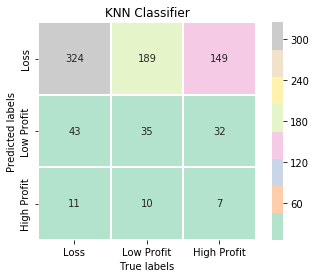

In [546]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Low Profit",'High Profit'])
ax.yaxis.set_ticklabels(["Loss","Low Profit",'High Profit'], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

## 3.2.2.2) Seperating into 2 classes

In [547]:
RatioClass = df2['gross_budget_ratio'].transform(lambda x: 0 if x <= 1 else 1)
RatioClass = RatioClass.to_frame()
Counts=RatioClass['gross_budget_ratio'].value_counts()
Counts

1    1406
0    1259
Name: gross_budget_ratio, dtype: int64

In [548]:
df22 = df2.copy()
df22['gross_budget_ratio'] = RatioClass['gross_budget_ratio']

In [549]:
X = df22.drop(columns=['gross_budget_ratio'])
y = df22['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 19)
Dimensionality of X_test : (800, 19)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 3.2.2.2.1) Logistic Regression

In [550]:
C_List = [0.001,0.01,0.1,1,10,100,1000]
penalty = ['l1','l2']
parameters = {'C': C_List,'penalty':penalty}
LR = LogisticRegression( solver='liblinear')
clf1 = GridSearchCV(LR, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
print("LR best parameters:", clf1.best_params_)
print("LR Train score:", clf1.score(X_train, y_train))
print("LR Test score:", clf1.score(X_test, y_test))
print("LR Test Accuracy score:", accuracy_score(y_pred, y_test))

LR best parameters: {'C': 10, 'penalty': 'l1'}
LR Train score: 0.4982973893303065
LR Test score: 0.47354497354497355
LR Test Accuracy score: 0.58625


Text(0.5, 1, 'Logistic Regression')

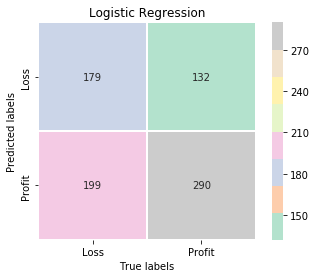

In [551]:
ax = plt.subplot()
Model_Predictions = clf1.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Logistic Regression')

### 3.2.2.2.2) Decision Tree Classifier

In [552]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTC = DecisionTreeClassifier(random_state=10)
clf2 = GridSearchCV(DTC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
print("DTC best parameters:", clf2.best_params_)
print("DTC Train score:", clf2.score(X_train, y_train))
print("DTC Test score:", clf2.score(X_test, y_test))
print("DTC Test Accuracy score:", accuracy_score(y_pred, y_test))

DTC best parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 0.005, 'min_samples_split': 0.001}
DTC Train score: 0.7185017026106697
DTC Test score: 0.5238095238095238
DTC Test Accuracy score: 0.5525


Text(0.5, 1, 'Decision Tree Classifier')

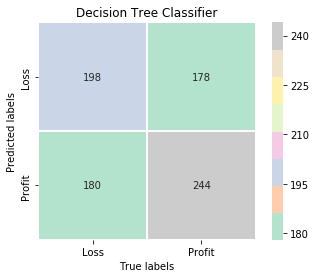

In [553]:
ax = plt.subplot()
Model_Predictions = clf2.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Decision Tree Classifier')

### 3.2.2.2.3) Random Forest Classifier

In [554]:
RFEstimatorList = [25,50,100,200]
criterion =['gini','entropy']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFC = RandomForestClassifier(random_state=10)
clf3 = GridSearchCV(RFC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)
print("RFC best parameters:", clf3.best_params_)
print("RFC Train score:", clf3.score(X_train, y_train))
print("RFC Test score:", clf3.score(X_test, y_test))
print("RFC Test Accuracy score:", accuracy_score(y_pred, y_test))

RFC best parameters: {'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 50}
RFC Train score: 1.0
RFC Test score: 0.582010582010582
RFC Test Accuracy score: 0.6225


Text(0.5, 1, 'Random Forest Classifier')

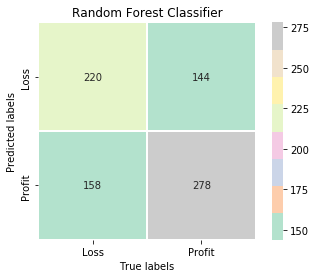

In [555]:
ax = plt.subplot()
Model_Predictions = clf3.predict(X_test)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Random Forest Classifier')

### 3.2.2.2.4) KNN Classifier

In [556]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [557]:
Neighbor_List=[3,5,10,20,50]
parameters = {'n_neighbors':Neighbor_List}
KNNC = KNeighborsClassifier()
clf4 = GridSearchCV(KNNC, parameters, cv=5, verbose=0,scoring =make_scorer(recall_score,pos_label=0))
clf4.fit(X_train_scaled, y_train)

y_pred = clf4.predict(X_test_scaled)
print("KNN best parameters:", clf4.best_params_)
print("KNN Train score:", clf4.score(X_train_scaled, y_train))
print("KNN Test score:", clf4.score(X_test_scaled, y_test))
print("KNN Test Accuracy score:", accuracy_score(y_pred, y_test))

KNN best parameters: {'n_neighbors': 10}
KNN Train score: 0.6662883087400681
KNN Test score: 0.6111111111111112
KNN Test Accuracy score: 0.56


Text(0.5, 1, 'KNN Classifier')

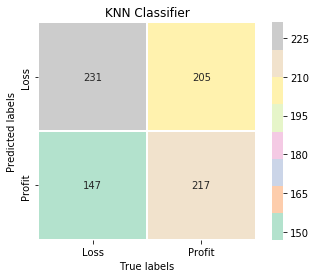

In [558]:
ax = plt.subplot()
Model_Predictions = clf4.predict(X_test_scaled)
Model_Confusion_Matrix = confusion_matrix(Model_Predictions,y_test)
sns.heatmap(Model_Confusion_Matrix,annot=True,fmt = "d",square = True,ax = ax, linewidths = 1,linecolor = "w",cmap = "Pastel2")
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
ax.xaxis.set_ticklabels(["Loss","Profit"])
ax.yaxis.set_ticklabels(["Loss","Profit"], va="center")
b, t = plt.ylim() 
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('KNN Classifier')

# Built-in Regressors <a name="gbrbr"></a>

# 1) Ranks + Facebook Likes

In [820]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [821]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes'])

In [822]:
classification_df

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3961      86.0                     63.0                   175.0   
3962      81.0                     26.0                   300.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3961                   489.0                       1278                   2.0   
3962                  2000.0                       3344                   0.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

     language      country content_rating        budget  ...  Sci-Fi_Fantasy  \
0     English          USA          PG-13  4.800000e+07  ...               1   
1     English          USA              R  6.000000e+06  ...               0   
2     English          USA             PG  4.867173e+07  ...               0   
3     English          USA              X  6.500000e+06  ...               0   
4     English          USA             PG  5.000000e+06  ...               0   
...       ...          ...            ...           ...  ...             ...   
3961  English          USA      Not Rated  9.900000e+05  ...               1   
3962  English          USA          PG-13  4.900000e+06  ...               0   
3963  English          USA             PG  5.000000e+06  ...               0   
3964   French       France      Not Rated  2.178331e+07  ...               0   
3965   Korean  South Korea      Not Rated  2.816008e+07  ...               1   

      Family_Animation  Action_Adventure  History_War  Others  director_rank  \
0                    0                 0            0       0              5   
1                    0                 0            0       1              3   
2                    0                 0            0       1              4   
3                    0                 0            0       0              3   
4                    0                 0            0       0              4   
...                ...               ...          ...     ...            ...   
3961                 0                 1            0       0              3   
3962                 0                 0            0       0              3   
3963                 0                 0            0       0              1   
3964                 0                 0            0       0              3   
3965                 0                 0            0       0              4   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0               6            3            5            0.981155  
1               7            3            5            6.633333  
2               3            4            4            1.641610  
3               2            3            

In [823]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'budget', 'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

## 1.1) All Movies

In [824]:
classification1_df=classification_df.drop(columns=['country','language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
3959     100.0                     24.0                   851.0   
3960      92.0                     89.0                   355.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
3959                 15000.0                      18786                   9.0   
3960                   729.0                       2848                   4.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
3959  2.000000e+07                  1000.0          0       1  ...   
3960  5.000000e+06                   706.0          0       1  ...   
3963  5.000000e+06                   420.0          0       0  ...   
3964  2.178331e+07                     8.0          0       1  ...   
3965  2.816008e+07                     5.0          0       0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
3959            5            5            5            2.773065   
3960            2            4            5            2.335036   
3963            2            3            4            4.154614   
3964            2            1            1            1.147809   
3965            1            1            0            0.027366   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0 

## 1.1.1) Without log and feature elimination

In [564]:
X = df1.drop(columns=['gross_budget_ratio'])
y = df1['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 29)
Dimensionality of X_test : (1057, 29)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 1.1.1.1) Ridge Regression

In [565]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [566]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 6.0}
ridge score: -1.3212992699946393
ridge MSE: 1.3212992699946393
ridge best estimator coef: [-0.08958568 -0.2160161   0.24896416  0.07388101  0.11635968  0.32588536
 -0.41020651  0.01957827 -0.03528058 -0.00669564 -0.12558814 -0.215969
 -0.13245912 -0.01216582 -0.1862557   0.16265674 -0.2237451  -0.25186858
 -0.13886728  0.93336262  0.04741896  0.25322823  0.23842858  0.30257448
  0.25585094  0.13951082 -0.17262211  0.          0.        ]


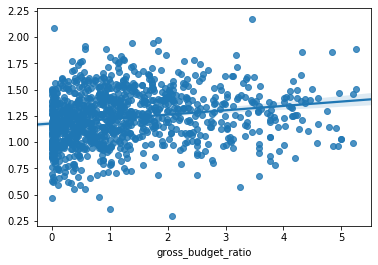

In [567]:
sns.regplot(y_test, y_pred )

### 1.1.1.2) Decision Tree Regressor

In [568]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.05, 'min_samples_split': 0.001}
DTR score: -1.2911314744905358
DTR MSE: 1.2911314744905358


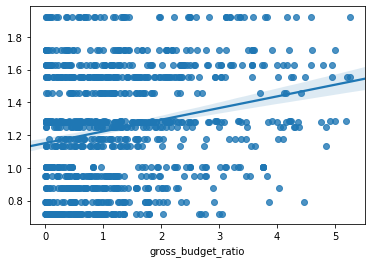

In [569]:
sns.regplot(y_test, y_pred )

### 1.1.1.3) Random Forest Regressor

In [570]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.21689917002837
RFR MSE: 1.21689917002837


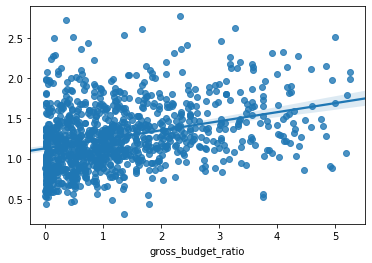

In [571]:
sns.regplot(y_test, y_pred )

## 1.1.2) With taking log and feature elimination

### log

In [825]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2  else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['gross_budget_ratio'] = df2['gross_budget_ratio'].transform(lambda x: np.log(0.1) if x <=0.1 else np.log(x))

### elimination

In [826]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_TV-14', 'content_rating_TV-G',
       'content_rating_TV-PG'],
      dtype='object')

In [827]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [828]:
X = df2.drop(columns=['gross_budget_ratio'])
y = df2['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 23)
Dimensionality of X_test : (1057, 23)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 1.1.2.1) Ridge Regression

In [576]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [577]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 0.1}
ridge score: -1.1811213972089298
ridge MSE: 1.1811213972089298
ridge best estimator coef: [ 6.59848449e-01 -8.97128366e-02  7.25118107e-01 -3.23976990e+00
  4.13999694e+00 -1.72146066e+00 -1.93228108e-01 -3.92828861e-03
 -3.26001578e-01 -7.54713277e-02  3.68535997e-01 -7.52529218e-02
 -1.18689379e-01  1.27926291e+00  3.88344771e-01 -5.11307491e-02
 -9.38883062e-02  3.16623294e-01  4.02212770e-01  1.19907465e-01
 -7.55951637e-01  0.00000000e+00  0.00000000e+00]


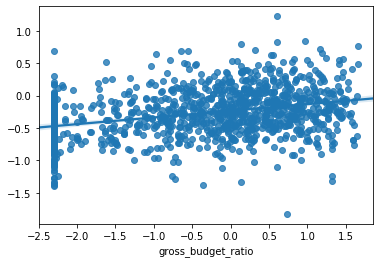

In [578]:
sns.regplot(y_test, y_pred )

### 1.1.2.2) Decision Tree Regressor

In [579]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.005, 'min_samples_split': 0.1}
DTR score: -1.2488840799056629
DTR MSE: 1.2488840799056629


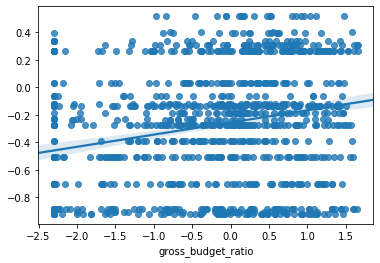

In [580]:
sns.regplot(y_test, y_pred )

### 1.1.2.3) Random Forest Regressor

In [581]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100}
RFR score: -1.1402343984953058
RFR MSE: 1.1402343984953058


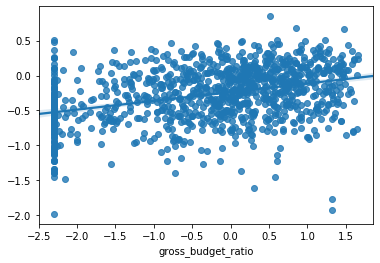

In [582]:
sns.regplot(y_test, y_pred )

Feature ranking:
1. feature 5 (0.171729)
2. feature 2 (0.120877)
3. feature 0 (0.102315)
4. feature 6 (0.101079)
5. feature 4 (0.094734)
6. feature 1 (0.086293)
7. feature 13 (0.067536)
8. feature 3 (0.063740)
9. feature 8 (0.036238)
10. feature 16 (0.023284)
11. feature 14 (0.020359)
12. feature 19 (0.019053)
13. feature 15 (0.017993)
14. feature 7 (0.014686)
15. feature 18 (0.011491)
16. feature 9 (0.011472)
17. feature 12 (0.011006)
18. feature 10 (0.009450)
19. feature 11 (0.009429)
20. feature 17 (0.007128)
21. feature 20 (0.000108)
22. feature 21 (0.000000)
23. feature 22 (0.000000)


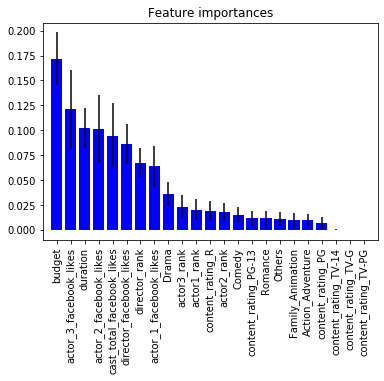

In [830]:
clf3=RandomForestRegressor(criterion= 'mse', max_depth= 10, n_estimators= 100,random_state=10)
clf3.fit(X_train, y_train)
features = X.columns
importances = clf3.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf3.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Additional XGBoost

In [583]:
params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01, 0.02],
    'subsample': [0.4, 0.6, 0.8],
    'objective' :['reg:squarederror']
    
}
clf = GridSearchCV(XGBRegressor(silent=False,random_state=10), params, scoring ='neg_mean_squared_error')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("XGBR best parameters:", clf.best_params_)
print("XGBR score:", clf.score(X_test, y_test))
print("XGBR MSE:", mean_squared_error(y_test, clf.predict(X_test)))

XGBR best parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 400, 'objective': 'reg:squarederror', 'subsample': 0.8}
XGBR score: -1.09501949668421
XGBR MSE: 1.09501949668421


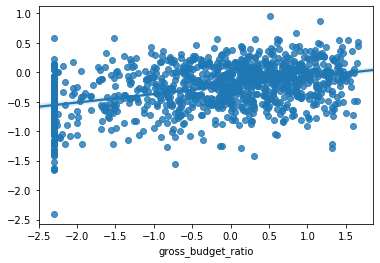

In [584]:
sns.regplot(y_test, y_pred )

Feature ranking:
1. feature 8 (0.088606)
2. feature 13 (0.075921)
3. feature 2 (0.063725)
4. feature 19 (0.063531)
5. feature 18 (0.060297)
6. feature 4 (0.060291)
7. feature 6 (0.059349)
8. feature 5 (0.056800)
9. feature 10 (0.056154)
10. feature 15 (0.052249)
11. feature 7 (0.044234)
12. feature 16 (0.039167)
13. feature 9 (0.038181)
14. feature 3 (0.037857)
15. feature 17 (0.037682)
16. feature 1 (0.036935)
17. feature 14 (0.036821)
18. feature 0 (0.035086)
19. feature 12 (0.031223)
20. feature 11 (0.025891)
21. feature 21 (0.000000)
22. feature 20 (0.000000)
23. feature 22 (0.000000)


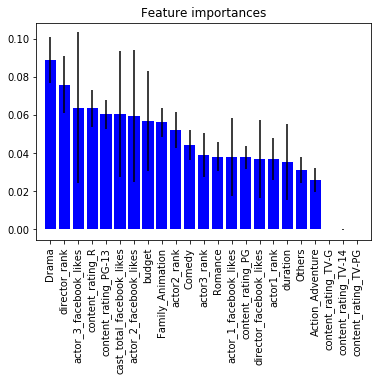

In [832]:
clf3=XGBRegressor(learning_rate= 0.02, max_depth= 3, n_estimators= 400, objective= 'reg:squarederror', subsample= 0.8,random_state=10)
clf3.fit(X_train, y_train)
features = X.columns
importances = clf3.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## 1.2) Only US Movies

In [585]:
movie_df = pd.read_csv(r'data/data_regression_onlyUS.csv')

In [586]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes'])

In [587]:
classification_df

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3004      86.0                     63.0                   175.0   
3005      81.0                     26.0                   300.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3004                   489.0                       1278                   2.0   
3005                  2000.0                       3344                   0.0   
3006                   634.0                       1810                  11.0   

     language content_rating       budget  actor_2_facebook_likes  ...  \
0     English          PG-13  48000000.00                  1000.0  ...   
1     English              R   6000000.00                   573.0  ...   
2     English             PG  48671729.12                   816.0  ...   
3     English              X   6500000.00                   567.0  ...   
4     English             PG   5000000.00                   754.0  ...   
...       ...            ...          ...                     ...  ...   
3002  English              R  20000000.00                  1000.0  ...   
3003  English              R   5000000.00                   706.0  ...   
3004  English      Not Rated    990000.00                   207.0  ...   
3005  English          PG-13   4900000.00                   509.0  ...   
3006  English             PG   5000000.00                   420.0  ...   

      Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  Others  \
0                  1                 0                 0            0       0   
1                  0                 0                 0            0       1   
2                  0                 0                 0            0       1   
3                  0                 0                 0            0       0   
4                  0                 0                 0            0       0   
...              ...               ...               ...          ...     ...   
3002               0                 0                 0            0       0   
3003               0                 0                 0            0       0   
3004               1                 0                 1            0       0   
3005               0                 0                 0            0       0   
3006               0                 0                 0            0       0   

      director_rank  actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0                 5            6            3            5            0.981155  
1                 3            7            3            5            6.633333  
2                 4            3            4            4            1.641610  
3                 3            2          

In [588]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'content_rating', 'budget',
       'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

In [589]:
classification1_df=classification_df.drop(columns=['language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
2999      92.0                     89.0                   190.0   
3001      97.0                     20.0                   538.0   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
2999                 17000.0                      17860                   0.0   
3001                   741.0                       2849                   1.0   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3006                   634.0                       1810                  11.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
2999  3.500000e+07                   329.0          0       1  ...   
3001  2.178331e+07                   615.0          0       0  ...   
3002  2.000000e+07                  1000.0          0       1  ...   
3003  5.000000e+06                   706.0          0       1  ...   
3006  5.000000e+06                   420.0          0       0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
2999            5            3            4            1.579766   
3001            2            3            4            1.147809   
3002            5            5            5            2.773065   
3003            2            4            5            2.335036   
3006            2            3            4            4.154614   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0 

## 1.2.1) Without log and feature elimination

In [590]:
X = df1.drop(columns=['gross_budget_ratio'])
y = df1['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 29)
Dimensionality of X_test : (800, 29)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 1.2.1.1) Ridge Regression

In [591]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [592]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.2000000000000002}
ridge score: -1.138711023834592
ridge MSE: 1.138711023834592
ridge best estimator coef: [ 1.34475818 -0.42243139  0.40464808 -0.58340196  0.01149973  0.24572515
 -2.28726116  0.39679972 -0.00966019  0.02105364 -0.07767981 -0.26243292
 -0.04503471 -0.07062147 -0.02261347  0.32421259  0.0218584  -0.23788245
 -0.20518036  1.57105887  0.15464031 -0.02375335  0.20052128  0.11629115
  0.18067622 -0.02159764 -0.60247107  0.97940238  0.        ]


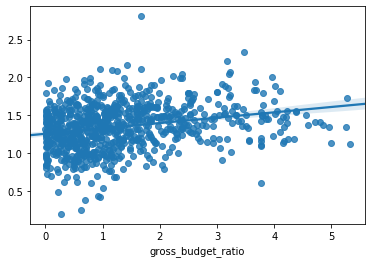

In [593]:
sns.regplot(y_test, y_pred )

### 1.2.1.2) Decision Tree Regressor

In [594]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.1, 'min_samples_split': 0.001}
DTR score: -1.1671388793835251
DTR MSE: 1.1671388793835251


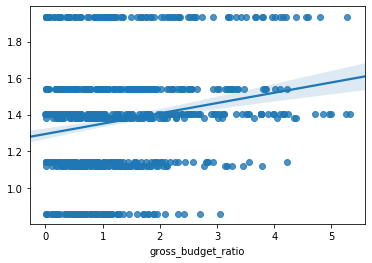

In [595]:
sns.regplot(y_test, y_pred )

### 1.2.1.3) Random Forest Regressor

In [596]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100}
RFR score: -1.108629510989992
RFR MSE: 1.108629510989992


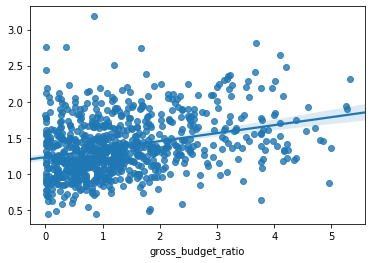

In [597]:
sns.regplot(y_test, y_pred )

## 1.2.2) With taking log and feature elimination

### log

In [598]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2  else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['gross_budget_ratio'] = df2['gross_budget_ratio'].transform(lambda x: np.log(0.1) if x <=0.1 else np.log(x))

### elimination

In [599]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_TV-14', 'content_rating_TV-G',
       'content_rating_TV-PG'],
      dtype='object')

In [600]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [601]:
X = df2.drop(columns=['gross_budget_ratio'])
y = df2['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 23)
Dimensionality of X_test : (800, 23)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 1.2.2.1) Ridge Regression

In [602]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [603]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 2.5}
ridge score: -0.9563971439482251
ridge MSE: 0.9563971439482251
ridge best estimator coef: [ 7.60122823e-01 -2.60585786e-04  5.77846131e-01 -3.58846189e-01
  2.21405543e-01 -5.96229400e-01  3.45766379e-01  7.45347561e-02
 -2.40482042e-01 -2.14109149e-02  2.72657394e-01 -3.66968803e-02
 -1.54359100e-01  1.12953982e+00  1.82705512e-01 -8.33299843e-02
 -3.65937265e-02  2.66835201e-01  3.85885593e-01  1.64450763e-01
 -2.29709154e-01  4.66318783e-01  0.00000000e+00]


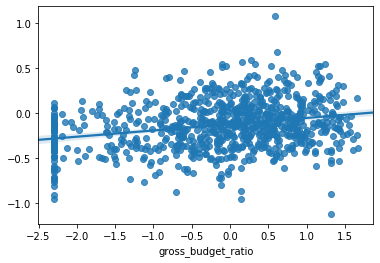

In [604]:
sns.regplot(y_test, y_pred )

### 1.2.2.2) Decision Tree Regressor

In [605]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.05, 'min_samples_split': 0.001}
DTR score: -0.934087222009075
DTR MSE: 0.934087222009075


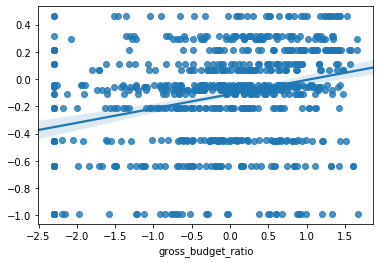

In [606]:
sns.regplot(y_test, y_pred )

### 1.2.2.3) Random Forest Regressor

In [607]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -0.9032334623725237
RFR MSE: 0.9032334623725237


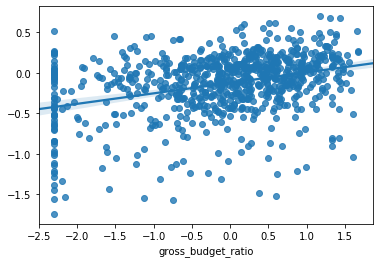

In [608]:
sns.regplot(y_test, y_pred )

# 2) Only Facebook Likes

In [609]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [610]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank'])

In [611]:
classification_df

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3961      86.0                     63.0                   175.0   
3962      81.0                     26.0                   300.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3961                   489.0                       1278                   2.0   
3962                  2000.0                       3344                   0.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

     language      country content_rating        budget  ...  Crime  Drama  \
0     English          USA          PG-13  4.800000e+07  ...      0      0   
1     English          USA              R  6.000000e+06  ...      0      0   
2     English          USA             PG  4.867173e+07  ...      0      1   
3     English          USA              X  6.500000e+06  ...      0      0   
4     English          USA             PG  5.000000e+06  ...      0      1   
...       ...          ...            ...           ...  ...    ...    ...   
3961  English          USA      Not Rated  9.900000e+05  ...      0      1   
3962  English          USA          PG-13  4.900000e+06  ...      0      0   
3963  English          USA             PG  5.000000e+06  ...      0      1   
3964   French       France      Not Rated  2.178331e+07  ...      0      1   
3965   Korean  South Korea      Not Rated  2.816008e+07  ...      0      0   

      Romance  Mystery_Thriller_Horror  Sci-Fi_Fantasy  Family_Animation  \
0           1                        0               1                 0   
1           0                        0               0                 0   
2           0                        0               0                 0   
3           1                        1               0                 0   
4           0                        0               0                 0   
...       ...                      ...             ...               ...   
3961        0                        0               1                 0   
3962        0                        1               0                 0   
3963        0                        0               0                 0   
3964        0                        0               0                 0   
3965        0                        1               1                 0   

      Action_Adventure  History_War  Others  gross_budget_ratio  
0                    0            0       0            0.981155  
1                    0            0       1            6.633333  
2                    0            0       1            1.641610  
3                    0            0       0            4.907538  
4                    0            0       0     

In [612]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'country', 'content_rating',
       'budget', 'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'gross_budget_ratio'],
      dtype='object')

## 2.1) All Movies

In [613]:
classification1_df=classification_df.drop(columns=['country','language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
3959     100.0                     24.0                   851.0   
3960      92.0                     89.0                   355.0   
3963     120.0                     18.0                   295.0   
3964     102.0                     12.0                     2.0   
3965     156.0                     43.0                     0.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
3959                 15000.0                      18786                   9.0   
3960                   729.0                       2848                   4.0   
3963                   634.0                       1810                  11.0   
3964                   541.0                        553                   2.0   
3965                    45.0                         50                   0.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
3959  2.000000e+07                  1000.0          0       1  ...   
3960  5.000000e+06                   706.0          0       1  ...   
3963  5.000000e+06                   420.0          0       0  ...   
3964  2.178331e+07                     8.0          0       1  ...   
3965  2.816008e+07                     5.0          0       0  ...   

      Action_Adventure  History_War  Others  gross_budget_ratio  \
0                    0            0       0            0.981155   
2                    0            0       1            1.641610   
3                    0            0       0            4.907538   
4                    0            0       0            5.202173   
6                    0            0       1            2.500307   
...                ...          ...     ...                 ...   
3959                 0            0       0            2.773065   
3960                 0            0       0            2.335036   
3963                 0            0       0            4.154614   
3964                 0            0       0            1.147809   
3965                 0            0       0            0.027366   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0 

## 2.1.1) Without log and feature elimination

In [614]:
X = df1.drop(columns=['gross_budget_ratio'])
y = df1['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 25)
Dimensionality of X_test : (1057, 25)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 2.1.1.1) Ridge Regression

In [615]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [616]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 6.0}
ridge score: -1.3475360466135322
ridge MSE: 1.3475360466135322
ridge best estimator coef: [ 0.26347431  0.17636456  0.54485496  0.24649323  0.36342141  0.33785633
 -0.38858257  0.28045639 -0.02594229  0.00606638 -0.11208062 -0.19140885
 -0.1431104  -0.01337557 -0.15289638  0.18850668 -0.20002371 -0.26607452
 -0.14388772  0.36893351  0.36128857  0.24065406 -0.13809096  0.
  0.        ]


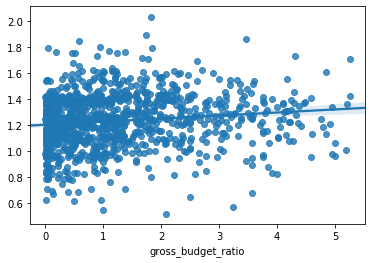

In [617]:
sns.regplot(y_test, y_pred )

### 2.1.1.2) Decision Tree Regressor

In [618]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.1, 'min_samples_split': 0.001}
DTR score: -1.3297459115187056
DTR MSE: 1.3297459115187056


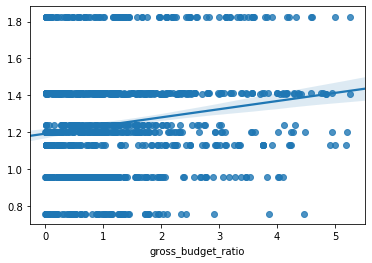

In [619]:
sns.regplot(y_test, y_pred )

### 2.1.1.3) Random Forest Regressor

In [620]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.2232771674557346
RFR MSE: 1.2232771674557346


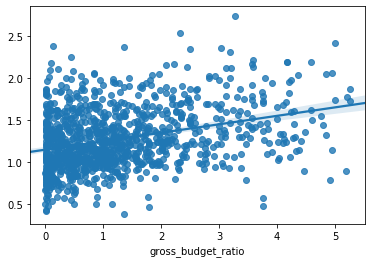

In [621]:
sns.regplot(y_test, y_pred )

## 2.1.2) With taking log and feature elimination

### log

In [622]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2  else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['gross_budget_ratio'] = df2['gross_budget_ratio'].transform(lambda x: np.log(0.1) if x <=0.1 else np.log(x))

### elimination

In [623]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'gross_budget_ratio', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R', 'content_rating_TV-14',
       'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [624]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [625]:
X = df2.drop(columns=['gross_budget_ratio'])
y = df2['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 19)
Dimensionality of X_test : (1057, 19)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 2.1.2.1) Ridge Regression

In [626]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [627]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 0.1}
ridge score: -1.2109607671281215
ridge MSE: 1.2109607671281215
ridge best estimator coef: [ 1.27576167e+00  3.22600715e-02  6.67423956e-01 -1.87113460e+00
  3.32445274e+00 -1.38474310e+00 -1.62544888e-01 -1.72442770e-03
 -3.02958661e-01 -1.07307070e-01  3.73835795e-01 -7.98323028e-02
 -1.13435462e-01  3.26305836e-01  4.26197124e-01  1.58302720e-01
 -7.17004240e-01  0.00000000e+00  0.00000000e+00]


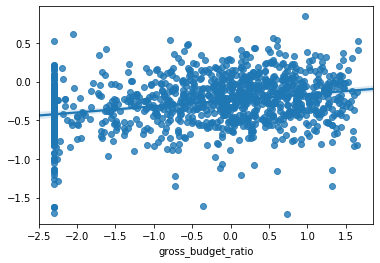

In [628]:
sns.regplot(y_test, y_pred )

### 2.1.2.2) Decision Tree Regressor

In [629]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.1, 'min_samples_split': 0.001}
DTR score: -1.2357825469247894
DTR MSE: 1.2357825469247894


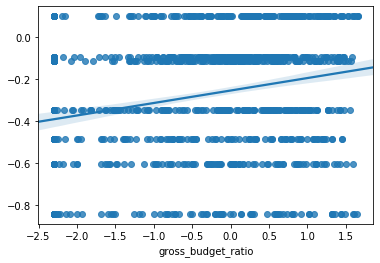

In [630]:
sns.regplot(y_test, y_pred )

### 2.1.2.3) Random Forest Regressor

In [631]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.1816027303017622
RFR MSE: 1.1816027303017622


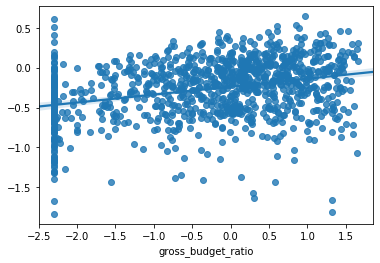

In [632]:
sns.regplot(y_test, y_pred )

## 2.2) Only US Movies

In [633]:
movie_df = pd.read_csv(r'data/data_regression_onlyUS.csv')

In [634]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank'])

In [635]:
classification_df

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
1         98.0                  11000.0                   484.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
...        ...                      ...                     ...   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3004      86.0                     63.0                   175.0   
3005      81.0                     26.0                   300.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
1                    13000.0                      14921                   3.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
...                      ...                        ...                   ...   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3004                   489.0                       1278                   2.0   
3005                  2000.0                       3344                   0.0   
3006                   634.0                       1810                  11.0   

     language content_rating       budget  actor_2_facebook_likes  ...  Crime  \
0     English          PG-13  48000000.00                  1000.0  ...      0   
1     English              R   6000000.00                   573.0  ...      0   
2     English             PG  48671729.12                   816.0  ...      0   
3     English              X   6500000.00                   567.0  ...      0   
4     English             PG   5000000.00                   754.0  ...      0   
...       ...            ...          ...                     ...  ...    ...   
3002  English              R  20000000.00                  1000.0  ...      0   
3003  English              R   5000000.00                   706.0  ...      0   
3004  English      Not Rated    990000.00                   207.0  ...      0   
3005  English          PG-13   4900000.00                   509.0  ...      0   
3006  English             PG   5000000.00                   420.0  ...      0   

      Drama  Romance  Mystery_Thriller_Horror  Sci-Fi_Fantasy  \
0         0        1                        0               1   
1         0        0                        0               0   
2         1        0                        0               0   
3         0        1                        1               0   
4         1        0                        0               0   
...     ...      ...                      ...             ...   
3002      0        0                        0               0   
3003      0        0                        0               0   
3004      1        0                        0               1   
3005      0        0                        1               0   
3006      1        0                        0               0   

      Family_Animation  Action_Adventure  History_War  Others  \
0                    0                 0            0       0   
1                    0                 0            0       1   
2                    0                 0            0       1   
3                    0                 0            0       0   
4                    0                 0            0       0   
...                ...               ...          ...     ...   
3002               

In [636]:
classification_df.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'language', 'content_rating', 'budget',
       'actor_2_facebook_likes', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'gross_budget_ratio'],
      dtype='object')

In [637]:
classification1_df=classification_df.drop(columns=['language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  director_facebook_likes  actor_3_facebook_likes  \
0        123.0                    446.0                   821.0   
2        124.0                    150.0                   572.0   
3        104.0                      0.0                   517.0   
4        124.0                      0.0                   452.0   
6        100.0                    394.0                   695.0   
...        ...                      ...                     ...   
2999      92.0                     89.0                   190.0   
3001      97.0                     20.0                   538.0   
3002     100.0                     24.0                   851.0   
3003      92.0                     89.0                   355.0   
3006     120.0                     18.0                   295.0   

      actor_1_facebook_likes  cast_total_facebook_likes  facenumber_in_poster  \
0                    20000.0                      22209                   1.0   
2                      874.0                       2667                   0.0   
3                      754.0                       2442                   0.0   
4                    12000.0                      13864                   1.0   
6                     2000.0                       6296                   0.0   
...                      ...                        ...                   ...   
2999                 17000.0                      17860                   0.0   
3001                   741.0                       2849                   1.0   
3002                 15000.0                      18786                   9.0   
3003                   729.0                       2848                   4.0   
3006                   634.0                       1810                  11.0   

            budget  actor_2_facebook_likes  Biography  Comedy  ...  \
0     4.800000e+07                  1000.0          0       1  ...   
2     4.867173e+07                   816.0          1       0  ...   
3     6.500000e+06                   567.0          0       0  ...   
4     5.000000e+06                   754.0          1       0  ...   
6     1.000000e+07                   926.0          0       0  ...   
...            ...                     ...        ...     ...  ...   
2999  3.500000e+07                   329.0          0       1  ...   
3001  2.178331e+07                   615.0          0       0  ...   
3002  2.000000e+07                  1000.0          0       1  ...   
3003  5.000000e+06                   706.0          0       1  ...   
3006  5.000000e+06                   420.0          0       0  ...   

      Action_Adventure  History_War  Others  gross_budget_ratio  \
0                    0            0       0            0.981155   
2                    0            0       1            1.641610   
3                    0            0       0            4.907538   
4                    0            0       0            5.202173   
6                    0            0       1            2.500307   
...                ...          ...     ...                 ...   
2999                 0            0       0            1.579766   
3001                 1            0       0            1.147809   
3002                 0            0       0            2.773065   
3003                 0            0       0            2.335036   
3006                 0            0       0            4.154614   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0 

## 2.2.1) Without log and feature elimination

In [638]:
X = df1.drop(columns=['gross_budget_ratio'])
y = df1['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 25)
Dimensionality of X_test : (800, 25)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 2.2.1.1) Ridge Regression

In [639]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [640]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.1}
ridge score: -1.1676706732548436
ridge MSE: 1.1676706732548436
ridge best estimator coef: [ 2.04434921  0.2392081   0.53842631 -0.33982767  0.31281917  0.25906704
 -1.87754107  0.49217935 -0.01599497  0.04391407 -0.06121177 -0.22750476
 -0.04958943 -0.08443883 -0.01660835  0.33232294  0.02024192 -0.18289955
 -0.22402888  0.14468583  0.24311378  0.06229074 -0.54616062  1.00527944
  0.        ]


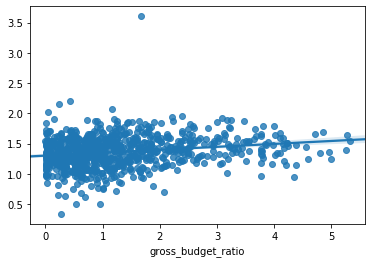

In [641]:
sns.regplot(y_test, y_pred )

### 2.2.1.2) Decision Tree Regressor

In [642]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.05, 'min_samples_split': 0.5}
DTR score: -1.1964834056298177
DTR MSE: 1.1964834056298177


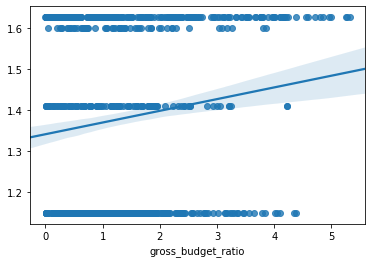

In [643]:
sns.regplot(y_test, y_pred )

### 2.2.1.3) Random Forest Regressor

In [644]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100}
RFR score: -1.142591559113232
RFR MSE: 1.142591559113232


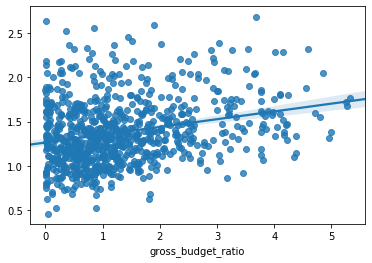

In [645]:
sns.regplot(y_test, y_pred )

## 2.2.2) With taking log and feature elimination

### log

In [646]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2  else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['gross_budget_ratio'] = df2['gross_budget_ratio'].transform(lambda x: np.log(0.1) if x <=0.1 else np.log(x))

### elimination

In [647]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'gross_budget_ratio', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R', 'content_rating_TV-14',
       'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [648]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [649]:
X = df2.drop(columns=['gross_budget_ratio'])
y = df2['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 19)
Dimensionality of X_test : (800, 19)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 2.2.2.1) Ridge Regression

In [650]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [651]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.1}
ridge score: -0.9717590197005842
ridge MSE: 0.9717590197005842
ridge best estimator coef: [ 1.67049912  0.11872387  0.49186435 -0.11079575  0.41024638 -0.43716786
  0.32952376  0.07998199 -0.22881921 -0.03796292  0.28045912 -0.04008623
 -0.16408693  0.27490693  0.40255829  0.18967862 -0.3680127   0.73836214
  0.        ]


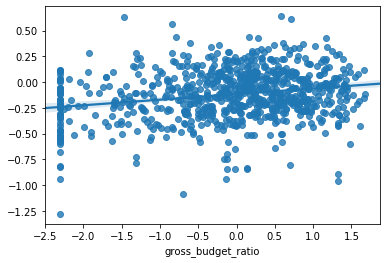

In [652]:
sns.regplot(y_test, y_pred )

### 2.2.2.2) Decision Tree Regressor

In [653]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.001}
DTR score: -0.9804303996055314
DTR MSE: 0.9804303996055314


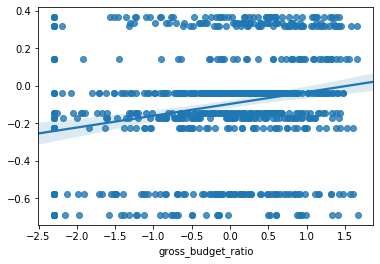

In [654]:
sns.regplot(y_test, y_pred )

### 2.2.2.3) Random Forest Regressor

In [655]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100}
RFR score: -0.9431611755226627
RFR MSE: 0.9431611755226627


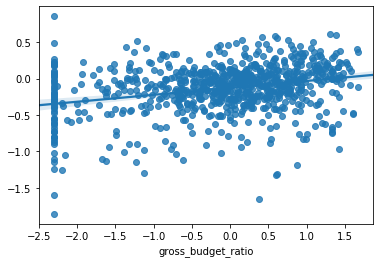

In [656]:
sns.regplot(y_test, y_pred )

# 3) Only Ranks 

In [657]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [658]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes'])

In [659]:
classification_df

duration  cast_total_facebook_likes  facenumber_in_poster language  \
0        123.0                      22209                   1.0  English   
1         98.0                      14921                   3.0  English   
2        124.0                       2667                   0.0  English   
3        104.0                       2442                   0.0  English   
4        124.0                      13864                   1.0  English   
...        ...                        ...                   ...      ...   
3961      86.0                       1278                   2.0  English   
3962      81.0                       3344                   0.0  English   
3963     120.0                       1810                  11.0  English   
3964     102.0                        553                   2.0   French   
3965     156.0                         50                   0.0   Korean   

          country content_rating        budget  Biography  Comedy  Crime  ...  \
0             USA          PG-13  4.800000e+07          0       1      0  ...   
1             USA              R  6.000000e+06          0       1      0  ...   
2             USA             PG  4.867173e+07          1       0      0  ...   
3             USA              X  6.500000e+06          0       0      0  ...   
4             USA             PG  5.000000e+06          1       0      0  ...   
...           ...            ...           ...        ...     ...    ...  ...   
3961          USA      Not Rated  9.900000e+05          0       1      0  ...   
3962          USA          PG-13  4.900000e+06          0       0      0  ...   
3963          USA             PG  5.000000e+06          0       0      0  ...   
3964       France      Not Rated  2.178331e+07          0       1      0  ...   
3965  South Korea      Not Rated  2.816008e+07          0       0      0  ...   

      Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  Others  \
0                  1                 0                 0            0       0   
1                  0                 0                 0            0       1   
2                  0                 0                 0            0       1   
3                  0                 0                 0            0       0   
4                  0                 0                 0            0       0   
...              ...               ...               ...          ...     ...   
3961               1                 0                 1            0       0   
3962               0                 0                 0            0       0   
3963               0                 0                 0            0       0   
3964               0                 0                 0            0       0   
3965               1                 0                 0            0       0   

      director_rank  actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0                 5            6            3            5            0.981155  
1                 3            7            3            5            6.633333  
2                 4            3            4            4            1.641610  
3                 3            2            3            4            4.907538  
4                 4            6            4            5            5.202173  
...             ...          ...          ...          ...                 ...  
3961              3            3            2            4           25.255628  
3962              3            3            3            5           11.537962  
3963              1            2            3            4            4.154614  
3964              3            2            1            1            1.147809  
3965              4            1            1            0            0.027366  

[3966 rows x 23 columns]

In [660]:
classification_df.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'language', 'country', 'content_rating', 'budget', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

## 3.1) All Movies

In [661]:
classification1_df=classification_df.drop(columns=['country','language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  cast_total_facebook_likes  facenumber_in_poster        budget  \
0        123.0                      22209                   1.0  4.800000e+07   
2        124.0                       2667                   0.0  4.867173e+07   
3        104.0                       2442                   0.0  6.500000e+06   
4        124.0                      13864                   1.0  5.000000e+06   
6        100.0                       6296                   0.0  1.000000e+07   
...        ...                        ...                   ...           ...   
3959     100.0                      18786                   9.0  2.000000e+07   
3960      92.0                       2848                   4.0  5.000000e+06   
3963     120.0                       1810                  11.0  5.000000e+06   
3964     102.0                        553                   2.0  2.178331e+07   
3965     156.0                         50                   0.0  2.816008e+07   

      Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  ...  \
0             0       1      0      0        1                        0  ...   
2             1       0      0      1        0                        0  ...   
3             0       0      0      0        1                        1  ...   
4             1       0      0      1        0                        0  ...   
6             0       0      0      0        0                        0  ...   
...         ...     ...    ...    ...      ...                      ...  ...   
3959          0       1      0      0        0                        0  ...   
3960          0       1      0      0        0                        0  ...   
3963          0       0      0      1        0                        0  ...   
3964          0       1      0      1        0                        0  ...   
3965          0       0      0      0        0                        1  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
3959            5            5            5            2.773065   
3960            2            4            5            2.335036   
3963            2            3            4            4.154614   
3964            2            1            1            1.147809   
3965            1            1            0            0.027366   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
3959                  0                     0                 1   
3960                  0                     0                 1   
3963                  1                     0                 0   
3964                  0                     0                 0   
3965                  0                     0                 0   

      content_rating_TV-14  content_rating_TV-G  content_rating_TV-PG  
0                        0                    0                     0  
2                        0                    0                     0  
3                        0                    0                     0  
4                        0                    0                     0  
6                        0                    0                     0  
...                    ...    

## 3.1.1) Without log and feature elimination

In [662]:
X = df1.drop(columns=['gross_budget_ratio'])
y = df1['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 25)
Dimensionality of X_test : (1057, 25)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 3.1.1.1) Ridge Regression

In [663]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [664]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.0}
ridge score: -1.3208458295779975
ridge MSE: 1.3208458295779975
ridge best estimator coef: [-0.17693178  0.43313161  0.63601054 -1.3813377  -0.03843434 -0.01574011
 -0.13362885 -0.21619392 -0.13254287 -0.0108225  -0.18468752  0.17375761
 -0.22262185 -0.25636361 -0.1393304   0.97148354  0.00290386  0.28451994
  0.27797229  0.31497117  0.26942917  0.15250768 -0.56358432  0.
  0.        ]


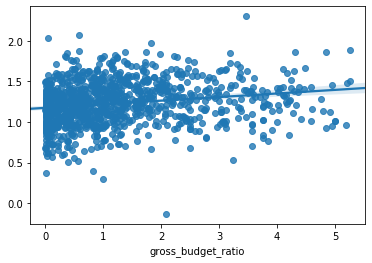

In [665]:
sns.regplot(y_test, y_pred )

### 3.1.1.2) Decision Tree Regressor

In [666]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.05, 'min_samples_split': 0.001}
DTR score: -1.2838412576133509
DTR MSE: 1.2838412576133509


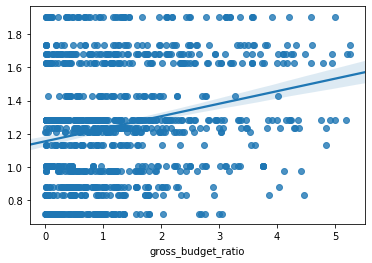

In [667]:
sns.regplot(y_test, y_pred )

### 3.1.1.3) Random Forest Regressor

In [668]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.2128620661489207
RFR MSE: 1.2128620661489207


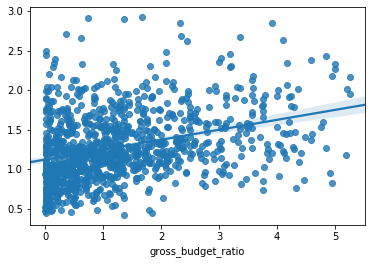

In [669]:
sns.regplot(y_test, y_pred )

## 3.1.2) With taking log and feature elimination

### log

In [670]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['gross_budget_ratio'] = df2['gross_budget_ratio'].transform(lambda x: np.log(0.1) if x <=0.1 else np.log(x))

### elimination

In [671]:
df2.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank', 'gross_budget_ratio',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R',
       'content_rating_TV-14', 'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [672]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [673]:
X = df2.drop(columns=['gross_budget_ratio'])
y = df2['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2466, 19)
Dimensionality of X_test : (1057, 19)
Dimensionality of y_train: (2466,)
Dimensionality of y_test : (1057,)


### 3.1.2.1) Ridge Regression

In [674]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [675]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 0.7000000000000001}
ridge score: -1.1853375514154865
ridge MSE: 1.1853375514154865
ridge best estimator coef: [ 0.62749156  1.06676434 -1.6074848   0.01674195 -0.33325495 -0.08388035
  0.35472793 -0.08554139 -0.12085274  1.19686273 -0.0871611   0.19032712
  0.44704695  0.34429278  0.42254064  0.13479946 -0.50735622  0.
  0.        ]


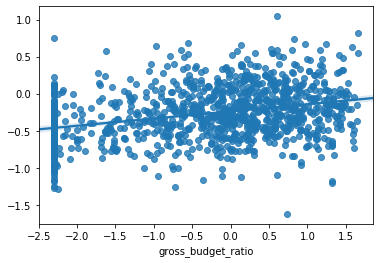

In [676]:
sns.regplot(y_test, y_pred )

### 3.1.2.2) Decision Tree Regressor

In [677]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}
DTR score: -1.216590449596622
DTR MSE: 1.216590449596622


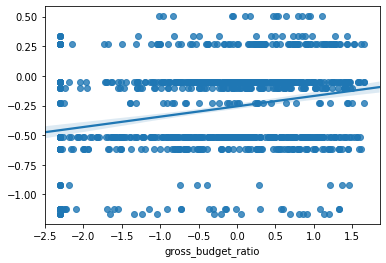

In [678]:
sns.regplot(y_test, y_pred )

### 3.1.2.3) Random Forest Regressor

In [679]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.1236578918396531
RFR MSE: 1.1236578918396531


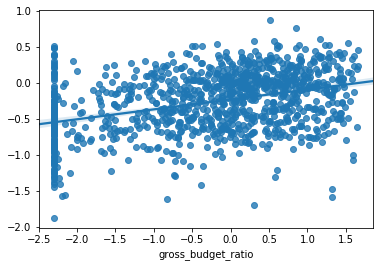

In [680]:
sns.regplot(y_test, y_pred )

## 3.2) Only US Movies

In [681]:
movie_df = pd.read_csv(r'data/data_regression_onlyUS.csv')

In [682]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes','director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes'])

In [683]:
classification_df

duration  cast_total_facebook_likes  facenumber_in_poster language  \
0        123.0                      22209                   1.0  English   
1         98.0                      14921                   3.0  English   
2        124.0                       2667                   0.0  English   
3        104.0                       2442                   0.0  English   
4        124.0                      13864                   1.0  English   
...        ...                        ...                   ...      ...   
3002     100.0                      18786                   9.0  English   
3003      92.0                       2848                   4.0  English   
3004      86.0                       1278                   2.0  English   
3005      81.0                       3344                   0.0  English   
3006     120.0                       1810                  11.0  English   

     content_rating       budget  Biography  Comedy  Crime  Drama  ...  \
0             PG-13  48000000.00          0       1      0      0  ...   
1                 R   6000000.00          0       1      0      0  ...   
2                PG  48671729.12          1       0      0      1  ...   
3                 X   6500000.00          0       0      0      0  ...   
4                PG   5000000.00          1       0      0      1  ...   
...             ...          ...        ...     ...    ...    ...  ...   
3002              R  20000000.00          0       1      0      0  ...   
3003              R   5000000.00          0       1      0      0  ...   
3004      Not Rated    990000.00          0       1      0      1  ...   
3005          PG-13   4900000.00          0       0      0      0  ...   
3006             PG   5000000.00          0       0      0      1  ...   

      Sci-Fi_Fantasy  Family_Animation  Action_Adventure  History_War  Others  \
0                  1                 0                 0            0       0   
1                  0                 0                 0            0       1   
2                  0                 0                 0            0       1   
3                  0                 0                 0            0       0   
4                  0                 0                 0            0       0   
...              ...               ...               ...          ...     ...   
3002               0                 0                 0            0       0   
3003               0                 0                 0            0       0   
3004               1                 0                 1            0       0   
3005               0                 0                 0            0       0   
3006               0                 0                 0            0       0   

      director_rank  actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  
0                 5            6            3            5            0.981155  
1                 3            7            3            5            6.633333  
2                 4            3            4            4            1.641610  
3                 3            2            3            4            4.907538  
4                 4            6            4            5            5.202173  
...             ...          ...          ...          ...                 ...  
3002              4            5            5            5            2.773065  
3003              3            2            4            5            2.335036  
3004              3            3            2            4           25.255628  
3005              3            3            3            5           11.537962  
3006              1            2            3            4            4.154614  

[3007 rows x 22 columns]

In [684]:
classification_df.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'language', 'content_rating', 'budget', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

In [685]:
classification1_df=classification_df.drop(columns=['language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

duration  cast_total_facebook_likes  facenumber_in_poster        budget  \
0        123.0                      22209                   1.0  4.800000e+07   
2        124.0                       2667                   0.0  4.867173e+07   
3        104.0                       2442                   0.0  6.500000e+06   
4        124.0                      13864                   1.0  5.000000e+06   
6        100.0                       6296                   0.0  1.000000e+07   
...        ...                        ...                   ...           ...   
2999      92.0                      17860                   0.0  3.500000e+07   
3001      97.0                       2849                   1.0  2.178331e+07   
3002     100.0                      18786                   9.0  2.000000e+07   
3003      92.0                       2848                   4.0  5.000000e+06   
3006     120.0                       1810                  11.0  5.000000e+06   

      Biography  Comedy  Crime  Drama  Romance  Mystery_Thriller_Horror  ...  \
0             0       1      0      0        1                        0  ...   
2             1       0      0      1        0                        0  ...   
3             0       0      0      0        1                        1  ...   
4             1       0      0      1        0                        0  ...   
6             0       0      0      0        0                        0  ...   
...         ...     ...    ...    ...      ...                      ...  ...   
2999          0       1      0      0        0                        0  ...   
3001          0       0      0      0        0                        1  ...   
3002          0       1      0      0        0                        0  ...   
3003          0       1      0      0        0                        0  ...   
3006          0       0      0      1        0                        0  ...   

      actor1_rank  actor2_rank  actor3_rank  gross_budget_ratio  \
0               6            3            5            0.981155   
2               3            4            4            1.641610   
3               2            3            4            4.907538   
4               6            4            5            5.202173   
6               5            3            6            2.500307   
...           ...          ...          ...                 ...   
2999            5            3            4            1.579766   
3001            2            3            4            1.147809   
3002            5            5            5            2.773065   
3003            2            4            5            2.335036   
3006            2            3            4            4.154614   

      content_rating_PG  content_rating_PG-13  content_rating_R  \
0                     0                     1                 0   
2                     1                     0                 0   
3                     0                     0                 0   
4                     1                     0                 0   
6                     0                     0                 1   
...                 ...                   ...               ...   
2999                  0                     0                 1   
3001                  0                     0                 0   
3002                  0                     0                 1   
3003                  0                     0                 1   
3006                  1                     0                 0   

      content_rating_TV-14  content_rating_TV-G  content_rating_TV-PG  
0                        0                    0                     0  
2                        0                    0                     0  
3                        0                    0                     0  
4                        0                    0                     0  
6                        0                    0                     0  
...                    ...    

## 3.2.1) Without log and feature elimination

In [686]:
X = df1.drop(columns=['gross_budget_ratio'])
y = df1['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 25)
Dimensionality of X_test : (800, 25)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 3.2.1.1) Ridge Regression

In [687]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [688]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.7000000000000002}
ridge score: -1.1282229815223936
ridge MSE: 1.1282229815223936
ridge best estimator coef: [ 1.15961352  0.24634428  0.35295289 -2.10259638 -0.02074919  0.02172145
 -0.0816833  -0.24757859 -0.0379348  -0.07396757 -0.01871911  0.309786
  0.017603   -0.22450176 -0.19545088  1.38560482  0.055843    0.21882929
  0.26578339  0.10471123  0.17153273 -0.02398982 -0.42506816  0.79429122
  0.        ]


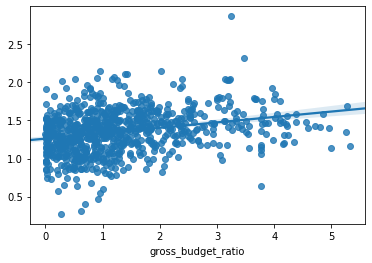

In [689]:
sns.regplot(y_test, y_pred )

### 3.2.1.2) Decision Tree Regressor

In [690]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.5}
DTR score: -1.1692195523240794
DTR MSE: 1.1692195523240794


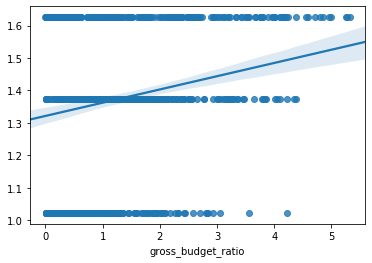

In [691]:
sns.regplot(y_test, y_pred )

### 3.2.1.3) Random Forest Regressor

In [692]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.092850423585562
RFR MSE: 1.092850423585562


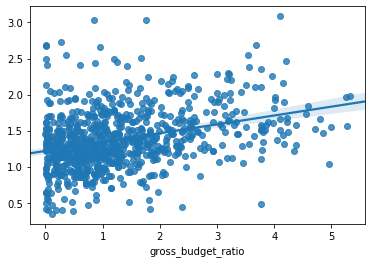

In [693]:
sns.regplot(y_test, y_pred )

## 3.2.2) With taking log and feature elimination

### log

In [694]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: np.log(0.2) if x <=0.2 else np.log(x))
df2['gross_budget_ratio'] = df2['gross_budget_ratio'].transform(lambda x: np.log(0.1) if x <=0.1 else np.log(x))

### elimination

In [695]:
df2.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank', 'gross_budget_ratio',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R',
       'content_rating_TV-14', 'content_rating_TV-G', 'content_rating_TV-PG'],
      dtype='object')

In [696]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [697]:
X = df2.drop(columns=['gross_budget_ratio'])
y = df2['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (1865, 19)
Dimensionality of X_test : (800, 19)
Dimensionality of y_train: (1865,)
Dimensionality of y_test : (800,)


### 3.2.2.1) Ridge Regression

In [698]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [699]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 3.0}
ridge score: -0.9602321886287107
ridge MSE: 0.9602321886287107
ridge best estimator coef: [ 0.71556884  0.38179899 -0.55269341  0.08084448 -0.23952351 -0.02260712
  0.27230988 -0.0370306  -0.16028443  1.11319646  0.0307095   0.15542796
  0.23276389  0.26528489  0.389832    0.16357693 -0.1971319   0.4211456
  0.        ]


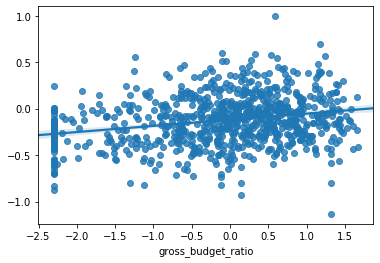

In [700]:
sns.regplot(y_test, y_pred )

### 3.2.2.2) Decision Tree Regressor

In [701]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.05, 'min_samples_split': 0.001}
DTR score: -0.9359882808576339
DTR MSE: 0.9359882808576339


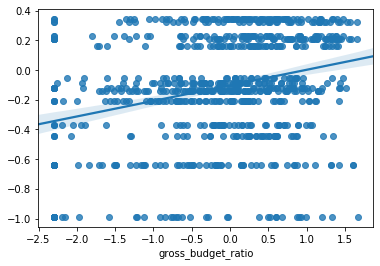

In [702]:
sns.regplot(y_test, y_pred )

### 3.2.2.3) Random Forest Regressor

In [703]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -0.9042317077249501
RFR MSE: 0.9042317077249501


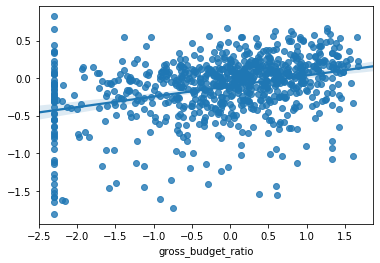

In [704]:
sns.regplot(y_test, y_pred )

# Neural Networks <a name="gbrnn"></a>

# IMDb Score Prediction <a name="imdbsp"></a>

# Built-in Regressor <a name="imdbsbr"></a>

In [859]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [860]:
print(movie_df.shape)
movie_df.dtypes

(3966, 42)


imdb_id                       object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
movie_facebook_likes           int64
Biography                      int64
C

In [861]:
movie_df.describe()

num_critic_for_reviews     duration  director_facebook_likes  \
count             3966.000000  3966.000000              3966.000000   
mean               156.002521   108.126576               737.732980   
std                123.516388    21.246351              2947.447455   
min                  1.000000    14.000000                 0.000000   
25%                 65.000000    94.000000                 8.000000   
50%                128.000000   104.000000                54.000000   
75%                215.000000   118.000000               214.000000   
max                813.000000   330.000000             23000.000000   

       actor_3_facebook_likes  actor_1_facebook_likes         gross  \
count             3966.000000             3966.000000  3.966000e+03   
mean               706.133384             7375.525719  4.785363e+07   
std               1783.490418            15949.037026  6.876485e+07   
min                  0.000000                0.000000  6.180800e+01   
25%                157.000000              680.000000  7.446117e+06   
50%                405.000000             1000.000000  2.500307e+07   
75%                664.000000            12000.000000  5.838524e+07   
max              23000.000000           640000.000000  1.200264e+09   

       num_voted_users  cast_total_facebook_likes  facenumber_in_poster  \
count     3.966000e+03                3966.000000           3966.000000   
mean      9.304042e+04               10872.025466              1.400908   
std       1.450373e+05               19308.720843              2.074560   
min       5.000000e+00                   0.000000              0.000000   
25%       1.238425e+04                1621.750000              0.000000   
50%       4.263250e+04                3638.000000              1.000000   
75%       1.098888e+05               15389.750000              2.000000   
max       1.689764e+06              656730.000000             43.000000   

       num_user_for_reviews  ...  Sci-Fi_Fantasy  Family_Animation  \
count           3966.000000  ...     3966.000000       3966.000000   
mean             295.587746  ...        0.222642          0.116994   
std              393.473976  ...        0.416073          0.321454   
min                1.000000  ...        0.000000          0.000000   
25%               79.000000  ...        0.000000          0.000000   
50%              175.000000  ...        0.000000          0.000000   
75%              361.000000  ...        0.000000          0.000000   
max             5060.000000  ...        1.000000          1.000000   

       Action_Adventure  History_War       Others  director_rank  actor1_rank  \
count       3966.000000  3966.000000  3966.000000    3966.000000  3966.000000   
mean           0.319213     0.064297     0.132123       3.840898     3.942007   
std            0.466231     0.245311     0.338667       1.328000     1.976958   
min            0.000000     0.000000     0.000000       1.000000     0.000000   
25%            0.000000     0.000000     0.000000       3.000000     3.000000   
50%            0.000000     0.000000     0.000000       4.000000     3.000000   
75%            1.000000     0.000000     0.000000       5.000000     5.000000   
max            1.000000     1.000000     1.000000      10.000000    10.000000   

       actor2_rank  actor3_rank  gross_budget_ratio  
count  3966.000000  3966.000000         3966.000000  
mean      3.380484     4.517398            8.689927  
std       1.380539     1.597310          130.490720  
min       0.000000     0.000000            0.000017  
25%       3.000000     4.000000            0.446382  
50%       3.000000     5.000000            1.108586  
75%       4.000000     5.000000            2.372303  
max      10.000000    10.000000         7194.485533  

[8 rows x 31 columns]

##  1 Basic model 

Here we use varaiables: duration,budget,genres,director rank, actor1 rank,actor2 rank,actor3 rank, movie facebook likes,cast total facebook likes, facenumber in poster

In [862]:
data1 = movie_df[['duration','budget','Biography','Comedy','Crime','Drama','Romance',
                  'Mystery_Thriller_Horror','Sci-Fi_Fantasy','Family_Animation','Action_Adventure',
                  'History_War','Others','director_rank',
                 'actor1_rank','actor2_rank','actor3_rank','movie_facebook_likes','cast_total_facebook_likes'
                 ,'facenumber_in_poster']]

In [863]:
data1.head()

duration       budget  Biography  Comedy  Crime  Drama  Romance  \
0     123.0  48000000.00          0       1      0      0        1   
1      98.0   6000000.00          0       1      0      0        0   
2     124.0  48671729.12          1       0      0      1        0   
3     104.0   6500000.00          0       0      0      0        1   
4     124.0   5000000.00          1       0      0      1        0   

   Mystery_Thriller_Horror  Sci-Fi_Fantasy  Family_Animation  \
0                        0               1                 0   
1                        0               0                 0   
2                        0               0                 0   
3                        1               0                 0   
4                        0               0                 0   

   Action_Adventure  History_War  Others  director_rank  actor1_rank  \
0                 0            0       0              5            6   
1                 0            0       1              3            7   
2                 0            0       1              4            3   
3                 0            0       0              3            2   
4                 0            0       0              4            6   

   actor2_rank  actor3_rank  movie_facebook_likes  cast_total_facebook_likes  \
0            3            5                     0                      22209   
1            3            5                     0                      14921   
2            4            4                     0                       2667   
3            3            4                     0                       2442   
4            4            5                  9000                      13864   

   facenumber_in_poster  
0                   1.0  
1                   3.0  
2                   0.0  
3                   0.0  
4                   1.0

In [864]:
y = movie_df['imdb_score']

In [865]:
X_train, X_test, y_train, y_test = train_test_split(data1, y, test_size=0.30)

MM = MinMaxScaler(feature_range=(0, 1), copy=True)
X_train_MM = MM.fit_transform(X_train) # standardize X_train
X_test_MM = MM.transform(X_test) # standardize X_test
X_train_scaled = pd.DataFrame(data=X_train_MM,  columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_MM,  columns=X_test.columns)

### 1.1) linear regression

In [714]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred= lr.predict(X_test_scaled)
print("linear regression R2:", r2_score(y_test, y_pred))
print("linear regression MSE:", mean_squared_error(y_test, y_pred, multioutput='raw_values'))


linear regression R2: 0.28020961285498924
linear regression MSE: [0.81584828]


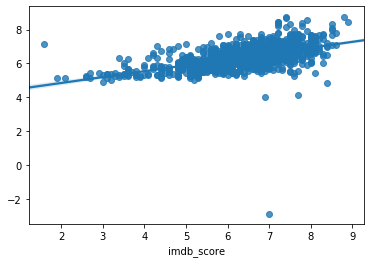

In [715]:
sns.regplot(y_test, y_pred )

### 1.2) Ridge Regression

In [716]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = linear_model.Ridge()
gridridge = GridSearchCV(ridge, parameters, scoring ='r2')
gridridge.fit(X_train_scaled, y_train)

y_pred = gridridge.predict(X_test_scaled)

print("ridge best parameters:", gridridge.best_params_)
print("ridge score:", gridridge.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, gridridge.predict(X_test_scaled)))
print("ridge best estimator coef:", gridridge.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.4000000000000001}
ridge score: 0.35132915608342163
ridge MSE: 0.7352376468584045
ridge best estimator coef: [ 1.76777614e+00 -8.95738329e-01  1.44212122e-01 -1.20021636e-01
  2.08516681e-01  3.51169527e-01 -8.53609274e-02 -2.90888601e-01
  1.72280396e-02 -6.62266954e-05 -1.29076554e-01  1.51444716e-01
  6.30081156e-02  2.94185271e+00  3.23667612e-01 -1.69155127e-01
 -6.67928955e-01  1.27310236e+00  2.99773040e-01 -8.24647551e-01]


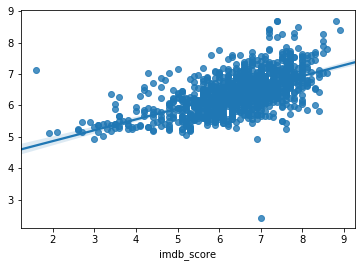

In [717]:
sns.regplot(y_test, y_pred )

### 1.3) Lasso Regression


In [718]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
lasso = linear_model.Lasso()
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.3438198168455504
lasso MSE: 0.743749126852446
lasso best estimator coef: [ 0.         -0.          0.12683093 -0.18252984  0.12030544  0.41378991
 -0.01347253 -0.2288303  -0.         -0.         -0.03445028  0.0809841
  0.          3.04605731  0.         -0.         -0.08802118  0.
  0.         -0.        ]


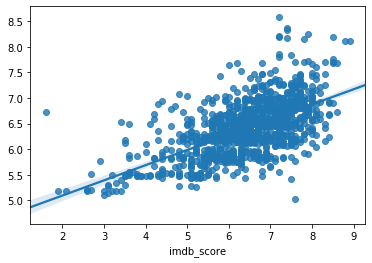

In [719]:
sns.regplot(y_test, y_pred )

### 1.4) ElasticNet Regression

In [720]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
en = linear_model.ElasticNet()
griden = GridSearchCV(en, parameters, scoring ='r2')
griden.fit(X_train_scaled, y_train)

y_pred = griden.predict(X_test_scaled)

print("Elastic Net best parameters:", griden.best_params_)
print("Elastic Net score:", griden.score(X_test_scaled, y_test))
print("Elastic Net MSE:", mean_squared_error(y_test, griden.predict(X_test_scaled)))
print("Elastic Net best estimator coef:", griden.best_estimator_.coef_)

Elastic Net best parameters: {'alpha': 0.01}
Elastic Net score: 0.34460369393073575
Elastic Net MSE: 0.7428606393414949
Elastic Net best estimator coef: [ 0.47517017 -0.          0.16286948 -0.18811329  0.16345559  0.39875745
 -0.0467727  -0.26048262  0.         -0.00726098 -0.0618717   0.13689175
  0.02339309  2.53863957  0.15693787 -0.         -0.27696752  0.30309435
  0.         -0.        ]


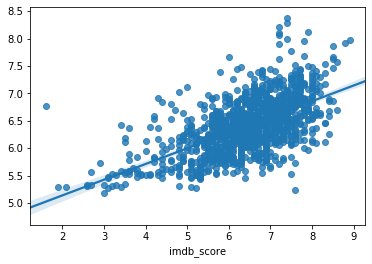

In [721]:
sns.regplot(y_test, y_pred )

### 1.5) Decision Tree Regressor

In [722]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
gridrf = GridSearchCV(DTR, parameters, scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("DTR best parameters:", gridrf.best_params_)
print("DTR score:", gridrf.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}
DTR score: 0.4771643763071206
DTR MSE: 0.5926093908224668


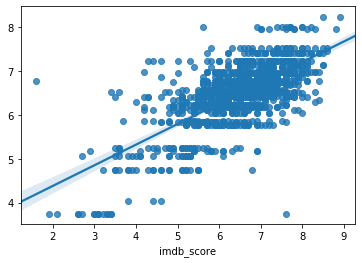

In [723]:
sns.regplot(y_test, y_pred )

### 1.6) Random Forest Regressor

In [724]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
gridrf = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("RFR best parameters:", gridrf.best_params_)
print("RFR score:", gridrf.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100}
RFR score: 0.5565556470206104
RFR MSE: 0.5026231495601855


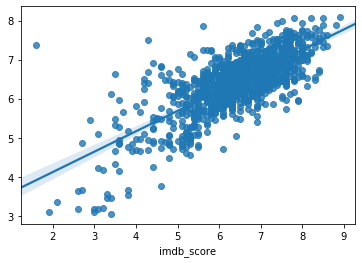

In [725]:
sns.regplot(y_test, y_pred)

## 2) Model without genres

Here we exclude genre from 1 Model

In [726]:
data2 = movie_df[['duration','budget','director_rank',
                 'actor1_rank','actor2_rank','actor3_rank'
                  ,'movie_facebook_likes','cast_total_facebook_likes','facenumber_in_poster']]

In [727]:
y = movie_df['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.30)

MM = MinMaxScaler(feature_range=(0, 1), copy=True)
X_train_MM = MM.fit_transform(X_train) # standardize X_train
X_test_MM = MM.transform(X_test) # standardize X_test
X_train_scaled = pd.DataFrame(data=X_train_MM,  columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_MM,  columns=X_test.columns)

### 2.1) linear regression

In [728]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred= lr.predict(X_test_scaled)
print("linear regression MSE:", mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("linear regression R2:", r2_score(y_test, y_pred))

linear regression MSE: [0.83693184]
linear regression R2: 0.319200158479796


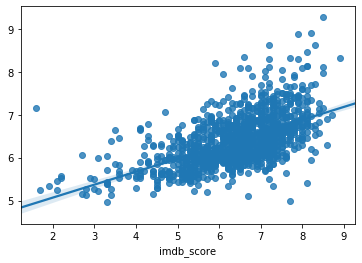

In [729]:
sns.regplot(y_test, y_pred)

### 2.2) ridge

In [730]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = linear_model.Ridge()
gridridge = GridSearchCV(ridge, parameters, scoring ='r2')
gridridge.fit(X_train_scaled, y_train)

y_pred = gridridge.predict(X_test_scaled)

print("ridge best parameters:", gridridge.best_params_)
print("ridge score:", gridridge.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, gridridge.predict(X_test_scaled)))
print("ridge best estimator coef:", gridridge.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.2000000000000002}
ridge score: 0.3177929334677372
ridge MSE: 0.8386617932503194
ridge best estimator coef: [ 2.64282404 -0.35326658  3.10639489  0.3274712  -0.4462957  -0.66920726
  0.98416697  0.19245059 -0.70024621]


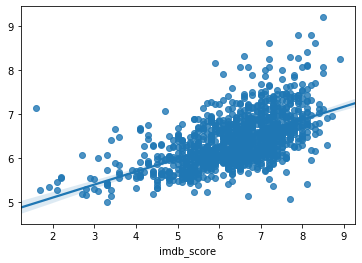

In [731]:
sns.regplot(y_test, y_pred)

### 2.3) lasso

In [732]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
lasso = linear_model.Lasso()
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.273540127332607
lasso MSE: 0.8930633665707153
lasso best estimator coef: [ 0.8395955  -0.          3.18350041  0.         -0.         -0.23644044
  0.          0.         -0.        ]


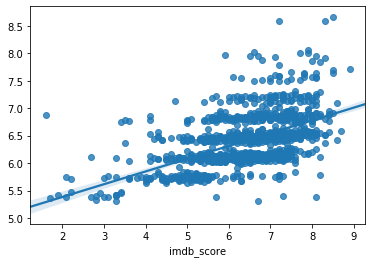

In [733]:
sns.regplot(y_test, y_pred)

### 2.4 elastic net

In [734]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
en = linear_model.ElasticNet()
gridlasso = GridSearchCV(en, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.27529057512472244
lasso MSE: 0.890911477860754
lasso best estimator coef: [ 1.07761382 -0.          2.69046905  0.12220309 -0.         -0.37304552
  0.19948224  0.         -0.22922782]


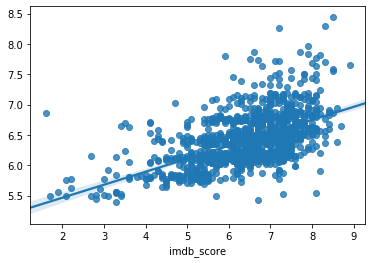

In [735]:
sns.regplot(y_test, y_pred)

### 2.5) decision tree

In [736]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
gridrf = GridSearchCV(DTR, parameters, scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("DTR best parameters:", gridrf.best_params_)
print("DTR score:", gridrf.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}
DTR score: 0.4364296974171332
DTR MSE: 0.6928173332904344


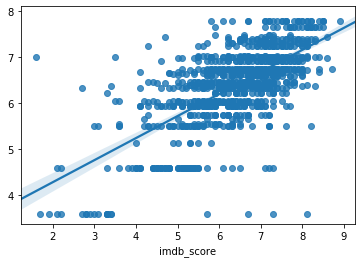

In [737]:
sns.regplot(y_test, y_pred )

### 2.6) random forest

In [738]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
gridrf = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("RFR best parameters:", gridrf.best_params_)
print("RFR score:", gridrf.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: 0.4756202020729531
RFR MSE: 0.6446390300663053


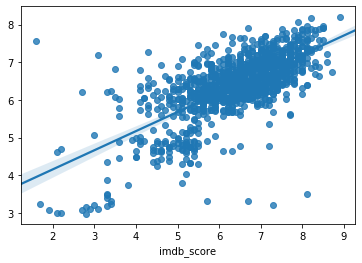

In [739]:
sns.regplot(y_test, y_pred)

##  3) Model with logs


Here we will transform  budget s to log values. 

In [740]:
data3 = movie_df[['duration','Biography','Comedy','Crime','Drama','Romance',
                  'Mystery_Thriller_Horror','Sci-Fi_Fantasy','Family_Animation','Action_Adventure',
                  'History_War','Others','director_rank',
                 'actor1_rank','actor2_rank','actor3_rank','movie_facebook_likes','cast_total_facebook_likes'
                 ,'facenumber_in_poster']]

In [741]:
budget = np.log(movie_df['budget'])
data3['log_budget'] = budget

In [742]:
y = movie_df['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(data3, y, test_size=0.30)
MM = MinMaxScaler(feature_range=(0, 1), copy=True)
X_train_MM = MM.fit_transform(X_train) # standardize X_train
X_test_MM = MM.transform(X_test) # standardize X_test
X_train_scaled = pd.DataFrame(data=X_train_MM,  columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_MM,  columns=X_test.columns)

### 3.1) linear regression

In [743]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred= lr.predict(X_test_scaled)
print("linear regression MSE:", mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("linear regression R2:", r2_score(y_test, y_pred))

linear regression MSE: [0.71648943]
linear regression R2: 0.3606388946026696


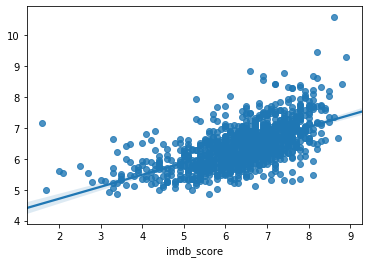

In [744]:
sns.regplot(y_test, y_pred)

### 3.2) ridge

In [745]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = linear_model.Ridge()
gridridge = GridSearchCV(ridge, parameters, scoring ='r2')
gridridge.fit(X_train_scaled, y_train)

y_pred = gridridge.predict(X_test_scaled)

print("ridge best parameters:", gridridge.best_params_)
print("ridge score:", gridridge.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, gridridge.predict(X_test_scaled)))
print("ridge best estimator coef:", gridridge.best_estimator_.coef_)

ridge best parameters: {'alpha': 0.7000000000000001}
ridge score: 0.3610943954658906
ridge MSE: 0.7159789834663975
ridge best estimator coef: [ 2.40226841e+00  1.43918199e-01 -1.06900789e-01  1.66571489e-01
  3.85021063e-01 -1.14344869e-01 -2.06562200e-01 -1.82430568e-03
  1.52525447e-01 -8.03163821e-02  7.76362697e-02  8.58414958e-02
  3.09230802e+00  4.08733763e-01 -9.38884258e-02 -6.32833566e-01
  9.40777431e-01  2.61380766e-01 -1.31099463e+00 -1.29603948e+00]


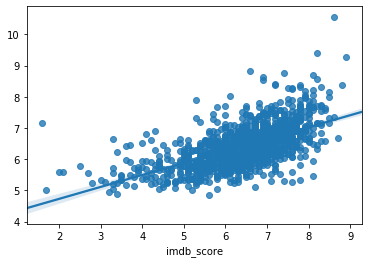

In [746]:
sns.regplot(y_test, y_pred)

### 3.3) lasso


In [747]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
lasso = linear_model.Lasso()
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.32818170383437295
lasso MSE: 0.7528620462071924
lasso best estimator coef: [ 0.          0.07600106 -0.19870945  0.04657024  0.47549074 -0.05978701
 -0.17125869 -0.          0.         -0.01623954  0.02500241  0.02132726
  3.08778246  0.         -0.         -0.08562841  0.09172929  0.
 -0.         -0.        ]


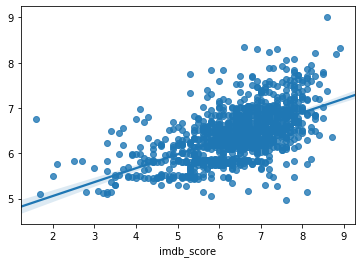

In [748]:
sns.regplot(y_test, y_pred)

### 3.4) elastic net

In [749]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
en = linear_model.ElasticNet()
gridlasso = GridSearchCV(en, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.3358669904089878
lasso MSE: 0.7442496570994883
lasso best estimator coef: [ 0.48059036  0.12195659 -0.19750269  0.10419078  0.45744829 -0.08910572
 -0.20277128 -0.          0.         -0.04965985  0.08611172  0.04815946
  2.49109735  0.16018306 -0.         -0.29709363  0.59108558  0.
 -0.         -0.        ]


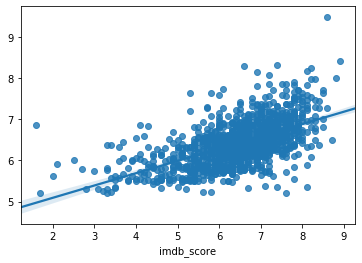

In [750]:
sns.regplot(y_test, y_pred)

### 3.5) decision tree

In [751]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
gridrf = GridSearchCV(DTR, parameters, scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("DTR best parameters:", gridrf.best_params_)
print("DTR score:", gridrf.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}
DTR score: 0.3797252592535939
DTR MSE: 0.6951006145474902


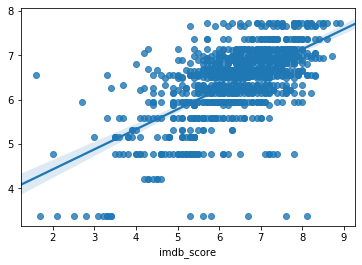

In [752]:
sns.regplot(y_test, y_pred )

### 3.6) random forest

In [753]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
gridrf = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("RFR best parameters:", gridrf.best_params_)
print("RFR score:", gridrf.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: 0.48283778286320134
RFR MSE: 0.5795492728269931


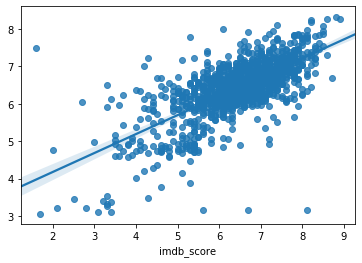

In [754]:
sns.regplot(y_test, y_pred)

## 4) Model only with films with likes

### All years

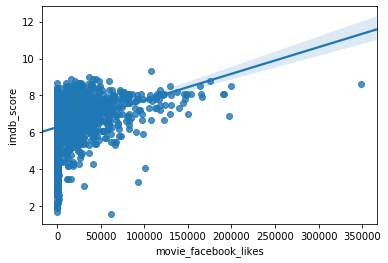

In [755]:
sns.regplot(movie_df['movie_facebook_likes'], movie_df['imdb_score'])

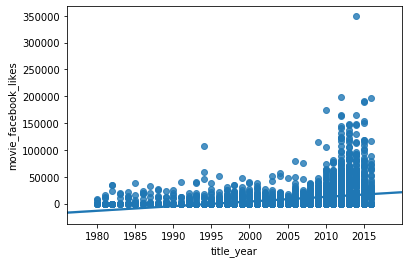

In [756]:
sns.regplot(movie_df['title_year'],movie_df['movie_facebook_likes'])

Here we include only movies with facebook likes and facebook cast likes

In [757]:
new = movie_df.query("movie_facebook_likes != 0")
y = new['imdb_score']
new = new.query("cast_total_facebook_likes != 0")

In [758]:
data4 = new[['duration','budget','Biography','Comedy','Crime','Drama','Romance',
                  'Mystery_Thriller_Horror','Sci-Fi_Fantasy','Family_Animation','Action_Adventure',
                  'History_War','Others','director_rank',
                 'actor1_rank','actor2_rank','actor3_rank'
                  ,'movie_facebook_likes','cast_total_facebook_likes','facenumber_in_poster']]

In [759]:
y = new['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(data4, y, test_size=0.30)
MM = MinMaxScaler(feature_range=(0, 1), copy=True)
X_train_MM = MM.fit_transform(X_train) # standardize X_train
X_test_MM = MM.transform(X_test) # standardize X_test
X_train_scaled = pd.DataFrame(data=X_train_MM,  columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_MM,  columns=X_test.columns)

### 4.1) linear regression

In [760]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred= lr.predict(X_test_scaled)
print("linear regression MSE:", mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("linear regression R2:", r2_score(y_test, y_pred))

linear regression MSE: [0.79783981]
linear regression R2: 0.43603416729757216


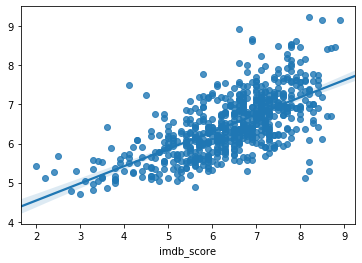

In [761]:
sns.regplot(y_test, y_pred)

### 4.2) ridge

In [762]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = linear_model.Ridge()
gridridge = GridSearchCV(ridge, parameters, scoring ='r2')
gridridge.fit(X_train_scaled, y_train)

y_pred = gridridge.predict(X_test_scaled)

print("ridge best parameters:", gridridge.best_params_)
print("ridge score:", gridridge.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, gridridge.predict(X_test_scaled)))
print("ridge best estimator coef:", gridridge.best_estimator_.coef_)

ridge best parameters: {'alpha': 1.2000000000000002}
ridge score: 0.43572764208126846
ridge MSE: 0.7982734488924703
ridge best estimator coef: [ 1.44270272  0.25789252  0.10673489 -0.14592166  0.17466509  0.44941975
 -0.09419208 -0.24192429  0.07304063  0.05592543 -0.16118499  0.03350575
  0.06537566  3.396434    0.4052443  -0.45818943 -0.60983419  1.3332839
  0.10944284 -0.83027989]


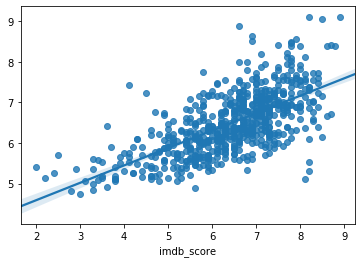

In [763]:
sns.regplot(y_test, y_pred)

### 4.3) lasso

In [764]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
lasso = linear_model.Lasso()
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.41273126592813403
lasso MSE: 0.8308063139994921
lasso best estimator coef: [ 0.00000000e+00  0.00000000e+00  5.10071860e-02 -2.02673882e-01
  3.85076488e-02  4.78735715e-01 -3.17978326e-02 -1.71215132e-01
  0.00000000e+00 -0.00000000e+00 -3.55126760e-02  1.66126080e-03
  0.00000000e+00  3.66316299e+00  0.00000000e+00 -0.00000000e+00
 -6.58567752e-02  0.00000000e+00  0.00000000e+00 -0.00000000e+00]


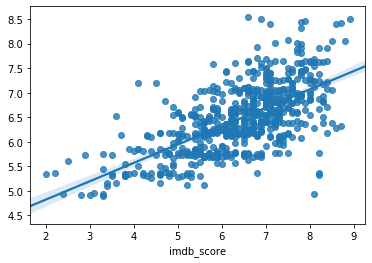

In [765]:
sns.regplot(y_test, y_pred)

### 4.4) elastic net

In [766]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
en = linear_model.ElasticNet()
gridlasso = GridSearchCV(en, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.4186024597731224
lasso MSE: 0.8225003637008773
lasso best estimator coef: [ 0.54965428  0.          0.11188255 -0.20763066  0.10654487  0.47653216
 -0.0655171  -0.2148187   0.05312144 -0.         -0.07745863  0.05350606
  0.01558511  2.95865389  0.1923934  -0.         -0.26863536  0.60557241
  0.         -0.        ]


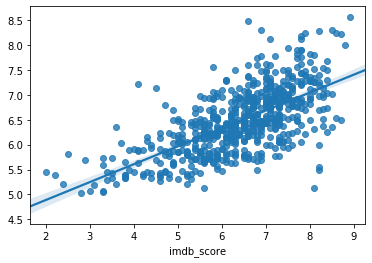

In [767]:
sns.regplot(y_test, y_pred)

### 4.5) decision tree

In [768]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
gridrf = GridSearchCV(DTR, parameters, scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("DTR best parameters:", gridrf.best_params_)
print("DTR score:", gridrf.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 7, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.05}
DTR score: 0.5342576301326627
DTR MSE: 0.658883538546289


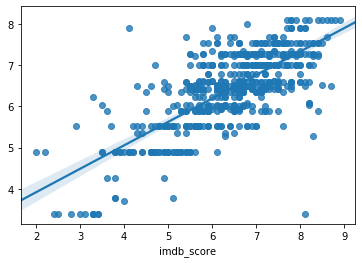

In [769]:
sns.regplot(y_test, y_pred )

### 4.6) random forest

In [770]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
gridrf = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("RFR best parameters:", gridrf.best_params_)
print("RFR score:", gridrf.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 100, 'n_estimators': 200}
RFR score: 0.6163235122111232
RFR MSE: 0.5427853214285713


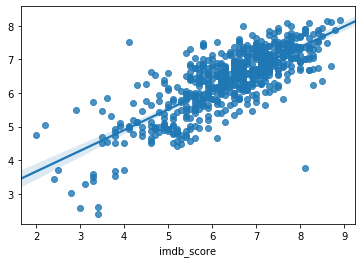

In [771]:
sns.regplot(y_test, y_pred )

## 5) Model using data from 2009 (facebook likes effect)

In [866]:
years = movie_df.query("title_year >= 2009")


In [867]:
data5 = years[['duration','budget','Biography','Comedy','Crime','Drama','Romance',
                  'Mystery_Thriller_Horror','Sci-Fi_Fantasy','Family_Animation','Action_Adventure',
                  'History_War','Others','director_rank',
                 'actor1_rank','actor2_rank','actor3_rank'
                  ,'movie_facebook_likes','cast_total_facebook_likes','facenumber_in_poster']]

In [868]:
y = years['imdb_score']
X_train, X_test, y_train, y_test = train_test_split(data5, y, test_size=0.30)
MM = MinMaxScaler(feature_range=(0, 1), copy=True)
X_train_MM = MM.fit_transform(X_train) # standardize X_train
X_test_MM = MM.transform(X_test) # standardize X_test
X_train_scaled = pd.DataFrame(data=X_train_MM,  columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_MM,  columns=X_test.columns)

### 5.1) linear regression

In [775]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred= lr.predict(X_test_scaled)
print("linear regression MSE:", mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("linear regression R2:", r2_score(y_test, y_pred))

linear regression MSE: [0.63986359]
linear regression R2: 0.4421736854695779


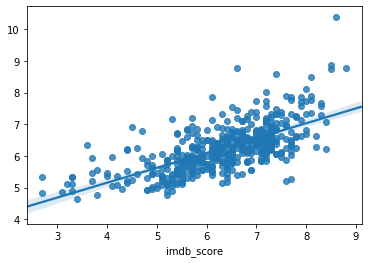

In [776]:
sns.regplot(y_test, y_pred)

### 5.2) ridge

In [777]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = linear_model.Ridge()
gridridge = GridSearchCV(ridge, parameters, scoring ='r2')
gridridge.fit(X_train_scaled, y_train)

y_pred = gridridge.predict(X_test_scaled)

print("ridge best parameters:", gridridge.best_params_)
print("ridge score:", gridridge.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, gridridge.predict(X_test_scaled)))
print("ridge best estimator coef:", gridridge.best_estimator_.coef_)

ridge best parameters: {'alpha': 2.0}
ridge score: 0.446419970061371
ridge MSE: 0.6349928194825852
ridge best estimator coef: [ 0.9194692   0.01008344  0.29315899 -0.05869752  0.25726148  0.35394283
 -0.00734072 -0.26447303 -0.07433153  0.26045335 -0.07063842 -0.0384793
  0.06756075  2.42513645  0.24641827 -0.25122821 -0.4753394   1.02064027
 -0.25850819 -0.78446456]


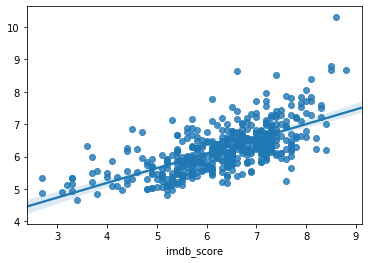

In [778]:
sns.regplot(y_test, y_pred)

### 5.3) lasso

In [779]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
lasso = linear_model.Lasso()
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.4322936530889413
lasso MSE: 0.6511966371026361
lasso best estimator coef: [ 0.          0.          0.23221195 -0.06141191  0.15466607  0.38933818
 -0.         -0.21759993 -0.          0.07137087 -0.          0.
  0.02743995  2.57815174  0.         -0.         -0.07154367  0.55536607
 -0.         -0.        ]


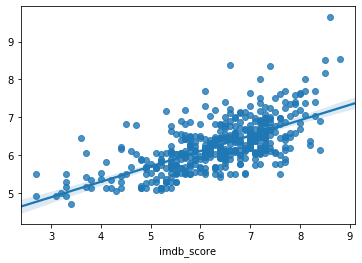

In [780]:
sns.regplot(y_test, y_pred)

### 5.4) elastic net

In [781]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
en = linear_model.ElasticNet()
gridlasso = GridSearchCV(en, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.4367834876058905
lasso MSE: 0.6460465006729605
lasso best estimator coef: [ 0.25828957  0.          0.27313106 -0.07680734  0.2180208   0.39075611
 -0.         -0.24325505 -0.01327923  0.15261643 -0.01285126  0.
  0.05546885  2.21311433  0.         -0.         -0.19237417  0.8623858
 -0.         -0.07472323]


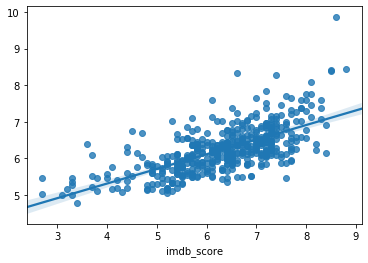

In [782]:
sns.regplot(y_test, y_pred)

### 5.5) decision tree

In [783]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
gridrf = GridSearchCV(DTR, parameters, scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("DTR best parameters:", gridrf.best_params_)
print("DTR score:", gridrf.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.005, 'min_samples_split': 0.1}
DTR score: 0.5057409244818649
DTR MSE: 0.5669477707729282


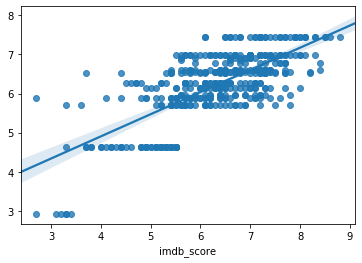

In [784]:
sns.regplot(y_test, y_pred )

### 5.6) random forest

In [785]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
gridrf = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("RFR best parameters:", gridrf.best_params_)
print("RFR score:", gridrf.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100}
RFR score: 0.5615796490942587
RFR MSE: 0.5028970694102609


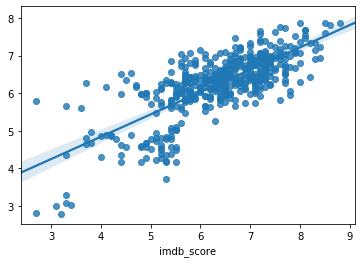

In [786]:
sns.regplot(y_test, y_pred)

Feature ranking:
1. feature 13 (0.471930)
2. feature 17 (0.143457)
3. feature 18 (0.073392)
4. feature 1 (0.071667)
5. feature 0 (0.061015)
6. feature 5 (0.036961)
7. feature 16 (0.034484)
8. feature 19 (0.022379)
9. feature 15 (0.014127)
10. feature 14 (0.013979)
11. feature 12 (0.011187)
12. feature 7 (0.009953)
13. feature 8 (0.007310)
14. feature 2 (0.005362)
15. feature 10 (0.005043)
16. feature 3 (0.004750)
17. feature 9 (0.004434)
18. feature 6 (0.003718)
19. feature 11 (0.002818)
20. feature 4 (0.002034)


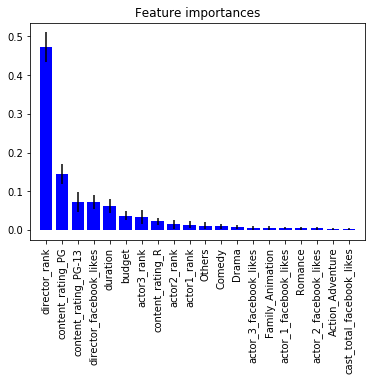

In [869]:
clf3=RandomForestRegressor(criterion= 'mse', max_depth= 10, n_estimators= 100,random_state=10)
clf3.fit(X_train, y_train)
features = X.columns
importances = clf3.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf3.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# 6) Model without facebook likes

MSE lower than in the model with likes, but R2 is lower

In [787]:
data5 = movie_df[['duration','budget','Biography','Comedy','Crime','Drama','Romance',
                  'Mystery_Thriller_Horror','Sci-Fi_Fantasy','Family_Animation','Action_Adventure',
                  'History_War','Others','director_rank',
                 'actor1_rank','actor2_rank','actor3_rank'
                 ,'facenumber_in_poster']]

In [788]:
y = movie_df['imdb_score']

In [789]:
X_train, X_test, y_train, y_test = train_test_split(data5, y, test_size=0.30)

MM = MinMaxScaler(feature_range=(0, 1), copy=True)
X_train_MM = MM.fit_transform(X_train) # standardize X_train
X_test_MM = MM.transform(X_test) # standardize X_test
X_train_scaled = pd.DataFrame(data=X_train_MM,  columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_MM,  columns=X_test.columns)

### 6.1) linear regression

In [790]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred= lr.predict(X_test_scaled)
print("linear regression R2:", r2_score(y_test, y_pred))
print("linear regression MSE:", mean_squared_error(y_test, y_pred, multioutput='raw_values'))


linear regression R2: 0.3820030910663601
linear regression MSE: [0.72730843]


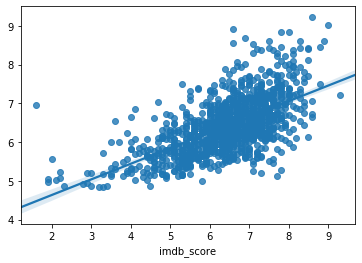

In [791]:
sns.regplot(y_test, y_pred)

### 6.2) ridge

In [792]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = linear_model.Ridge()
gridridge = GridSearchCV(ridge, parameters, scoring ='r2')
gridridge.fit(X_train_scaled, y_train)

y_pred = gridridge.predict(X_test_scaled)

print("ridge best parameters:", gridridge.best_params_)
print("ridge score:", gridridge.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, gridridge.predict(X_test_scaled)))
print("ridge best estimator coef:", gridridge.best_estimator_.coef_)

ridge best parameters: {'alpha': 0.8}
ridge score: 0.38259506435737745
ridge MSE: 0.7266117482456841
ridge best estimator coef: [ 1.97292378  0.15019896  0.17232265 -0.13806469  0.14875358  0.38394476
 -0.08393185 -0.27624079  0.02184743 -0.00798895 -0.08171314  0.00489973
  0.05794856  3.24089953  0.40749297 -0.29131817 -0.59341107 -0.69695369]


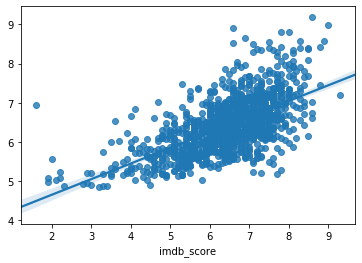

In [793]:
sns.regplot(y_test, y_pred)

### 6.3) lasso


In [794]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
lasso = linear_model.Lasso()
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2')
gridlasso.fit(X_train_scaled, y_train)

y_pred = gridlasso.predict(X_test_scaled)

print("lasso best parameters:", gridlasso.best_params_)
print("lasso score:", gridlasso.score(X_test_scaled, y_test))
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test_scaled)))
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)

lasso best parameters: {'alpha': 0.01}
lasso score: 0.35436994120349485
lasso MSE: 0.7598293415873149
lasso best estimator coef: [ 0.00000000e+00  0.00000000e+00  1.40208525e-01 -2.16130139e-01
  5.65534474e-02  4.49711609e-01 -6.87598193e-03 -2.21978030e-01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  5.70120332e-04  3.06993243e+00  0.00000000e+00 -0.00000000e+00
 -1.88659310e-02 -0.00000000e+00]


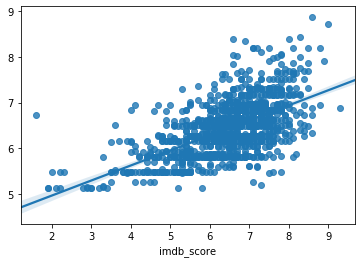

In [795]:
sns.regplot(y_test, y_pred)

### 6.4) elastic net

In [796]:
parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
en = lasso = linear_model.ElasticNet()
griden = GridSearchCV(en, parameters, scoring ='r2')
griden.fit(X_train_scaled, y_train)

y_pred = griden.predict(X_test_scaled)

print("Elastic Net best parameters:", griden.best_params_)
print("Elastic Net score:", griden.score(X_test_scaled, y_test))
print("Elastic Net MSE:", mean_squared_error(y_test, griden.predict(X_test_scaled)))
print("Elastic Net best estimator coef:", griden.best_estimator_.coef_)

Elastic Net best parameters: {'alpha': 0.01}
Elastic Net score: 0.36056288135706005
Elastic Net MSE: 0.7525409918965577
Elastic Net best estimator coef: [ 4.97153924e-01  0.00000000e+00  1.73879281e-01 -2.18082672e-01
  9.98505707e-02  4.37161315e-01 -3.80141878e-02 -2.57858153e-01
  0.00000000e+00 -4.09136779e-05 -1.02548816e-02  3.71277368e-02
  2.09513754e-02  2.57291933e+00  1.76100475e-01 -0.00000000e+00
 -2.25911736e-01 -1.44906827e-01]


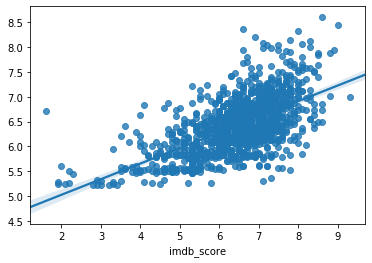

In [797]:
sns.regplot(y_test, y_pred)

### 6.5) decision tree

In [798]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
gridrf = GridSearchCV(DTR, parameters, scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("DTR best parameters:", gridrf.best_params_)
print("DTR score:", gridrf.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.05}
DTR score: 0.43389602651475834
DTR MSE: 0.6662366529914457


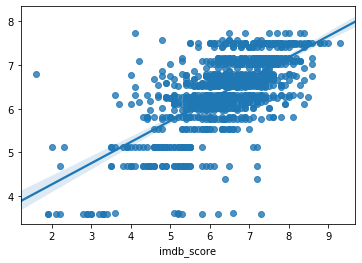

In [799]:
sns.regplot(y_test, y_pred )

### 6.6) random forest

In [800]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
gridrf = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='r2')
gridrf.fit(X_train, y_train)

y_pred = gridrf.predict(X_test)

print("RFR best parameters:", gridrf.best_params_)
print("RFR score:", gridrf.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, gridrf.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: 0.497149958344539
RFR MSE: 0.5917943423830735


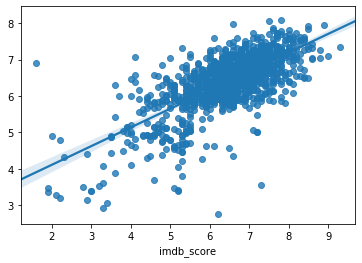

In [801]:
sns.regplot(y_test, y_pred )

# Neural Networks <a name="imdbsnn"></a>